# Using Pf6 data to map SNPs onto Pfcarl and other candidate genes

In [13]:
%run _standard_imports.ipynb
%run _plotting_setup.ipynb
import zarr
import numcodecs
zarr.codecs.codec_registry[numcodecs.MsgPack.codec_id] = numcodecs.MsgPack
zarr.codecs.codec_registry[numcodecs.Pickle.codec_id] = numcodecs.Pickle
import pybedtools as pbt

scikit-allel 1.2.0
python 3.7.1 (default, Dec 14 2018, 13:28:58) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
numpy 1.15.4
scipy 1.1.0
pandas 0.23.4
numexpr 2.6.8
pysam 0.15.2
petl 1.2.0
petlx 1.0.3
vcf 0.6.8
vcfnp 2.3.0
h5py 2.8.0
tables 3.4.4


In [14]:
# file with only QC+ samples (~6K)
Pf6_qcplus_samples_fn = '/Users/aa22/Documents/cloned_repo_environment/agam-report-base/Pf6_mut.csv'

# pickle file with variants (~6M)
pandas_fn = '/Users/aa22/Documents/malaria_1/Pf_60_public_wg.final.variants.pickle'

# calldata genotypes
zarr_fn = '/Users/aa22/Documents/malaria_1/Pf_60_public_wg.final.zarr'

# gene structures
gff_fn = '/Users/aa22/Documents/malaria_1/Pfalciparum.noseq.ascii.gff3'

Let's work with QC+ samples

In [15]:
df_qcplus_samples = pd.read_csv(Pf6_qcplus_samples_fn)

In [16]:
df_qcplus_samples.shape

(5970, 247)

In [33]:
#df_qcplus_samples.head()

Here in the column 'Unnamed: 0' we have kept the old indexes from the big Pf6 calldata dataset in order to fish them out later

In [34]:
df_qcplus_samples = df_qcplus_samples.rename(index=str, columns={"Unnamed: 0": "old_index_samples"})
#df_qcplus_samples

In [19]:
#np.unique(df_qcplus_samples['Unnamed: 0'], return_counts = True)

# Reading Pf6 dataset and adding AF (allele frequency) column

In [20]:
%%time
df_variants = pd.read_pickle(pandas_fn)           # these are unfiltered variants (including indels etc.)

CPU times: user 3min 2s, sys: 11 s, total: 3min 13s
Wall time: 3min 19s


In [21]:
print(len(set(list(df_variants.SNPEFF_TRANSCRIPT_ID))))

5342


In [23]:
#df_variants_1 = df_variants_filtered[df_variants.SNPEFF_TRANSCRIPT_ID == 'PF3D7_0312500.1']
#df_variants_1.SNPEFF_AMINO_ACID_CHANGE

In [24]:
df_variants.reset_index(inplace=True)  # because here indexes are actually repetitive

In [35]:
df_variants = df_variants.eval('AF = AC_1 / AN')    # adding AF column as AC_1 / AN (only biallelic SNPs)
#df_variants

In [26]:
#print(df_variants.AC_1[0], '/', df_variants.AN[0], '=', df_variants.AF[0])   # just a quick check

The column 'index' represents a repetitve index that is of no use to me, removing it:

In [27]:
df_variants.drop(columns='index',inplace=True)

In [36]:
#df_variants

# Filtering variants

In [29]:
print(list(df_variants))

['CHROM', 'POS', 'ID', 'REF', 'ALT_1', 'ALT_2', 'ALT_3', 'ALT_4', 'ALT_5', 'ALT_6', 'QUAL', 'RegionType', 'AC_1', 'AC_2', 'AC_3', 'AC_4', 'AC_5', 'AC_6', 'SNPEFF_EFFECT', 'DP', 'SNPEFF_EXON_ID', 'SNPEFF_GENE_NAME', 'SNPEFF_AMINO_ACID_CHANGE', 'VQSLOD', 'SNPEFF_IMPACT', 'SNPEFF_TRANSCRIPT_ID', 'SNPEFF_CODON_CHANGE', 'SNPEFF_FUNCTIONAL_CLASS', 'CDS', 'AN', 'FILTER_PASS', 'FILTER_SubtelomericHypervariable', 'FILTER_SubtelomericRepeat', 'FILTER_InternalHypervariable', 'FILTER_Low_VQSLOD', 'FILTER_Centromere', 'numalt', 'svlen_1', 'svlen_2', 'svlen_3', 'svlen_4', 'svlen_5', 'svlen_6', 'is_snp', 'AF']


In [30]:
# here I was trying to figure out what's wrong with CYTB gene (ID in Pf6: mal_mito_3:mRNA, elsewhere - mal_mito_3)
df_mal_mito_3 = df_variants[df_variants.SNPEFF_TRANSCRIPT_ID == 'mal_mito_3:mRNA']  
#df_mal_mito_3

Now let's look at the range of values in each column

In [37]:
#for elem in df_variants:
#    print('column', elem, np.unique(df_variants[elem], return_counts=True))

Filtering varinants applying following filters:
<br>
1) Core chromosome region, VQSLOD > 0 (FILTER_PASS == True)
<br>
2) SNPs
<br>
3) biallelic (numalt == 1)
<br>
[4) non-synonymous coding] - not for now, we need all types of SNPs

In [32]:
df_variants_filtered = df_variants[ (df_variants.FILTER_PASS == True)  # filters applied: Core region, SNP, biallelic
                                   & (df_variants.is_snp == True) 
                                   & (df_variants.numalt == 1) ]
                               #    & (df_variants.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING') ]
print(list(df_variants_filtered))
#df_variants_filtered.sort_values(by='POS')
#print(df_variants_filtered[:])

['CHROM', 'POS', 'ID', 'REF', 'ALT_1', 'ALT_2', 'ALT_3', 'ALT_4', 'ALT_5', 'ALT_6', 'QUAL', 'RegionType', 'AC_1', 'AC_2', 'AC_3', 'AC_4', 'AC_5', 'AC_6', 'SNPEFF_EFFECT', 'DP', 'SNPEFF_EXON_ID', 'SNPEFF_GENE_NAME', 'SNPEFF_AMINO_ACID_CHANGE', 'VQSLOD', 'SNPEFF_IMPACT', 'SNPEFF_TRANSCRIPT_ID', 'SNPEFF_CODON_CHANGE', 'SNPEFF_FUNCTIONAL_CLASS', 'CDS', 'AN', 'FILTER_PASS', 'FILTER_SubtelomericHypervariable', 'FILTER_SubtelomericRepeat', 'FILTER_InternalHypervariable', 'FILTER_Low_VQSLOD', 'FILTER_Centromere', 'numalt', 'svlen_1', 'svlen_2', 'svlen_3', 'svlen_4', 'svlen_5', 'svlen_6', 'is_snp', 'AF']


In [38]:
#for elem in df_variants_filtered:
#    print('column', elem, np.unique(df_variants_filtered[elem], return_counts=True))

Now we have practically all SNPs (causing multiple effects, look at SNPEFF_EFFECT), but eventually we will be choosing candidates only from non-synonymous coding

In [18]:
df_variants_filtered.reset_index(inplace=True) # this allows to keep old indexes as 'index' column

And here the old index for variants is in the column 'index', let's rename it to 'old_index_variants'

In [39]:
df_variants_filtered = df_variants_filtered.rename(index=str, columns={"index": "old_index_variants"})
#df_variants_filtered

In [41]:
print(df_variants_filtered.shape)
#df_variants_filtered.head()

(1626886, 45)


Here I was looking at GENE IDs (here SNPEFF_TRANSCRIPT_ID attribute) trying to find Pfcarl (and found it being listed as PF3D7_0321900.1 instead of PF3D7_0321900)

In [42]:
#np.set_printoptions(threshold=np.nan)
#np.unique(df_variants_filtered.SNPEFF_TRANSCRIPT_ID, return_counts=True)

# Applying filters to genotypes dataset
<br>
Fishing out rows (variants) and columns (samples) to find 1/1 and 0/1 on intersection (aka anything but 0/0 or ./.)

Filtered variants (1626886) need to be further intersected with QC+ samples (5970)

In [23]:
callset = zarr.open_group(zarr_fn, mode='r') 
print(callset)

<zarr.hierarchy.Group '/' read-only>


In [24]:
genotypes = allel.GenotypeChunkedArray(callset['calldata']['GT'])   # this is all that huge table, NOTHING filtered!
genotypes

<GenotypeChunkedArray shape=(6051696, 7113, 2) dtype=int8 chunks=(65536, 64, 2)
   nbytes=80.2G cbytes=10.1G cratio=7.9
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [43]:
#df_qcplus_samples.head()

In [26]:
df_qcplus_samples.shape

(5970, 247)

Now let's create lists of indexes for fishing our data out

In [27]:
old_index_var = list(df_variants_filtered['old_index_variants'])
print(len(old_index_var))
#np.unique(df_variants_filtered['level_0'],return_counts=True)

1626886


In [28]:
variant_selection = [False]*len(df_variants)
for i in old_index_var:
    variant_selection[i] = True
np.unique(variant_selection,return_counts=True)

(array([False,  True], dtype=bool), array([4424810, 1626886]))

In [29]:
old_index_sam = list(df_qcplus_samples['old_index_samples'])
print(len(old_index_sam))
#old_index_sam

5970


In [30]:
sample_selection = [False]*7113
for i in old_index_sam:
    sample_selection[i] = True
np.unique(sample_selection, return_counts=True)

(array([False,  True], dtype=bool), array([1143, 5970]))

In [31]:
%%time
genotypes_subset = genotypes.subset(variant_selection, sample_selection)

CPU times: user 5min 4s, sys: 1min 6s, total: 6min 10s
Wall time: 8min 49s


In [32]:
#print(genotypes_subset[1][5968])
genotypes_subset
#genotypes_subset[0]

<GenotypeChunkedArray shape=(1626886, 5970, 2) dtype=int8 chunks=(398, 5970, 2)
   nbytes=18.1G cbytes=427.4M cratio=43.3
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [33]:
ac = genotypes_subset.count_alleles()
ac

<AlleleCountsChunkedArray shape=(1626886, 2) dtype=int32 chunks=(101681, 2)
   nbytes=12.4M cbytes=3.2M cratio=3.9
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [34]:
final_var_selection = ac.is_segregating()               # final indexes for fishing variants from df_variants_filtered
print(np.unique(final_var_selection, return_counts=True))

(array([False,  True], dtype=bool), array([  25972, 1600914]))


In [35]:
#print(final_var_selection[692768:692771])

In [36]:
%%time
final_fishing = []
final_drop_list = []
for i in range(0,692771):
    #print(i)
    if final_var_selection[i]:
        final_fishing.append(str(i))
    else:
        final_drop_list.append(str(i))

CPU times: user 2min 17s, sys: 39.2 s, total: 2min 56s
Wall time: 1min 52s


In [44]:
#print(final_drop_list)

In [45]:
#df_variants_filtered

YES! Finally the final final final fishing indexes are in final_fishing and whatever you need to drop is in final_drop_list

In [48]:
# converting list elements into integers
final_drop_list = [int(i) for i in final_drop_list]
print(final_drop_list)

[8, 457, 646, 1294, 1386, 1388, 1435, 1820, 1910, 1961, 2146, 2196, 2359, 2446, 2508, 2510, 2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2527, 2555, 2869, 3036, 3038, 3058, 3276, 3330, 3334, 3336, 3339, 3359, 3415, 3543, 3693, 3928, 4166, 4260, 4268, 4335, 4520, 4522, 5079, 5093, 5102, 5167, 5186, 5287, 5451, 5546, 5619, 5707, 6547, 6557, 6697, 6717, 6822, 6827, 6918, 6919, 6926, 7445, 7471, 7514, 7624, 7755, 7803, 7839, 7897, 8118, 8149, 8307, 8522, 8581, 8703, 8771, 8778, 8779, 9031, 9165, 9266, 9311, 9318, 9673, 9689, 10079, 10080, 10081, 10134, 10143, 10144, 10145, 10465, 10503, 10593, 10631, 10690, 10852, 10880, 10998, 11011, 11216, 11277, 11289, 11315, 11381, 11387, 11411, 11519, 11708, 11836, 12029, 12118, 12199, 12303, 12316, 12347, 12349, 12470, 12570, 12798, 12814, 12815, 12819, 12820, 12823, 12862, 12883, 12958, 13037, 13133, 13136, 13179, 13198, 13396, 13426, 13540, 13633, 13635, 13636, 13954, 14022, 14086, 14168, 14323, 14688, 14745, 14753, 14796, 14898, 14918, 14

In [49]:
df_variants_filtered_final = df_variants_filtered.drop(labels=list(final_drop_list), axis=0)
print(df_variants_filtered_final.shape)

(1616257, 47)


In [46]:
#df_variants_filtered_final

In [51]:
df_variants_filtered_final.reset_index(inplace=True)  # again, to prevent further confusion

In [47]:
#df_variants_filtered_final

In [53]:
# writer = pd.ExcelWriter('/Users/aa22/Documents/cloned_repo_environment/agam-report-base/Pf6_final.xlsx')
# exporting into excel file
df_variants_filtered_final.to_pickle('/Users/aa22/Documents/cloned_repo_environment/agam-report-base/Pf6_final_1.pkl')
#writer.save()

# Sorting the results

To eventually choose a small subset of candidate mutations and genes let's sort the Cowell+ dataset (the merged dataframe - Cowell and scores for genes) by the local differentiation score and then visualize the data only for some of the top picks

In [54]:
# file with Cowell data + information about genes from eLife supplementary
merged_table = '/Users/aa22/Documents/cloned_repo_environment/agam-report-base/MALDA_lds.xlsx'

# pickle file with filtered variants (final)
final_variants = '/Users/aa22/Documents/cloned_repo_environment/agam-report-base/Pf6_final_1.pkl'

In [55]:
df_merged = pd.read_excel(merged_table)

In [56]:
list(df_merged)

['index',
 'Compound',
 'Chromosome',
 'Position',
 'Gene_ID',
 'Gene_Descrip',
 'Type',
 'Ref_Base',
 'Alt_Base',
 'Effect',
 'Codon_Change',
 'CodingChangeConversion',
 'Gene Name',
 'start',
 'end',
 'global diff score',
 'local diff score',
 'distance to higher local diff score',
 'Conservation score']

Here sorting by local differentiation score

In [48]:
df_merged.rename(index=str, columns={"index": "old_index"}, inplace=True)
df_merged.sort_values(by='local diff score',ascending=False,inplace=True,na_position='first')
#df_merged.drop(columns='index',inplace=True)              # dropping the column with indexes before sorting
df_merged.reset_index(inplace=True)
#df_merged.head(60)

Now taking only those variants that have a local differentiation score > 0.4 [to capture PfCARL]

In [58]:
df_Cowell_lds_filtered = df_merged[df_merged['local diff score'] > 0.4]
df_Cowell_lds_filtered.reset_index(inplace=True)     # to allow normal indexation

In [59]:
df_Cowell_lds_filtered

,level_0,index,old_index,Compound,Chromosome,Position,Gene_ID,Gene_Descrip,Type,Ref_Base,...,Effect,Codon_Change,CodingChangeConversion,Gene Name,start,end,global diff score,local diff score,distance to higher local diff score,Conservation score
0,55,200,400,MMV006767,Pf3D7_07_v3,403990,PF3D7_0709000,chloroquine+resistance+transporter+%28CRT%29,SNP,C,...,non_synonymous_coding,gCc/gTc,A138V,CRT,403222.0,406317.0,0.815128,0.853722,NaN,3.125000
1,56,199,394,MMV006767,Pf3D7_07_v3,403591,PF3D7_0709000,chloroquine+resistance+transporter+%28CRT%29,SNP,A,...,non_synonymous_coding,Agt/Cgt,S65R,CRT,403222.0,406317.0,0.815128,0.853722,NaN,3.125000
2,57,41,44,Atovaquone,Pf3D7_07_v3,402967,PF3D7_0709000,chloroquine resistance transporter (CRT),SNP,T,...,intergenic,NaN,n.402967T>C,CRT,403222.0,406317.0,0.815128,0.853722,NaN,3.125000
3,58,40,43,Atovaquone,Pf3D7_07_v3,402965,PF3D7_0709000,chloroquine resistance transporter (CRT),SNP,T,...,intergenic,NaN,n.402965T>G,CRT,403222.0,406317.0,0.815128,0.853722,NaN,3.125000
4,59,246,486,MMV011895,Pf3D7_07_v3,403624,PF3D7_0709000,chloroquine+resistance+transporter+%28CRT%29,SNP,A,...,non_synonymous_coding,Aaa/Caa,K76Q,CRT,403222.0,406317.0,0.815128,0.853722,NaN,3.125000
5,60,39,42,Atovaquone,Pf3D7_07_v3,402964,PF3D7_0709000,chloroquine resistance transporter (CRT),SNP,A,...,intergenic,NaN,n.402964A>T,CRT,403222.0,406317.0,0.815128,0.853722,NaN,3.125000
6,61,290,635,MMV024114,Pf3D7_07_v3,403667,PF3D7_0709000,chloroquine+resistance+transporter+%28CRT%29,SNP,G,...,non_synonymous_coding,aGt/aAt,S90N,CRT,403222.0,406317.0,0.815128,0.853722,NaN,3.125000
7,62,295,649,MMV026596,Pf3D7_05_v3,960307,PF3D7_0523000,multidrug+resistance+protein+%28MDR1%29,SNP,T,...,NON_SYNONYMOUS_CODING,ttT/ttG,F806L,MDR1,957890.0,962149.0,0.490442,0.843685,NaN,3.286117
8,63,0,0,ACT-451840,Pf3D7_05_v3,958835,PF3D7_0523000,multidrug+resistance+protein+%28MDR1%29,SNP,G,...,non_synonymous_coding,Ggt/Cgt,G316R,MDR1,957890.0,962149.0,0.490442,0.843685,NaN,3.286117
9,64,1,1,ACT-451840,Pf3D7_05_v3,960308,PF3D7_0523000,multidrug+resistance+protein+%28MDR1%29,SNP,G,...,non_synonymous_coding,Gct/Act,A807T,MDR1,957890.0,962149.0,0.490442,0.843685,NaN,3.286117


In [60]:
df_Cowell_lds_filtered.to_excel('/Users/aa22/Documents/cloned_repo_environment/agam-report-base/Cowell_data_top_picks1.xlsx')

Reading the dataframe with results of this notebook from pickle file (not to rerun everything again)

In [61]:
df_variants_filtered_final = pd.read_pickle(final_variants)

Making a list of picked gene candidates

In [62]:
np.unique(df_variants_filtered_final[df_variants_filtered_final.SNPEFF_EFFECT == 'SYNONYMOUS_CODING'].SNPEFF_FUNCTIONAL_CLASS, return_counts=True)

(array(['SILENT'], dtype=object), array([339094]))

In [63]:
gene_picks = list(set(list(df_Cowell_lds_filtered.Gene_ID)))  
# set - removes duplicates from list, but does not support indexing, 
                                #  therefore converting back to list (without duplicates)

In [64]:
print(gene_picks, len(gene_picks))

['PF3D7_0519900', 'PF3D7_1224200', 'PF3D7_1354900', 'PF3D7_0908500', 'PF3D7_1116700', 'PF3D7_0927200', 'PF3D7_0829500', 'PF3D7_1468400', 'PF3D7_1438700', 'PF3D7_1217500', 'PF3D7_1136600', 'PF3D7_0417200', 'PF3D7_0903500', 'PF3D7_0628200', 'PF3D7_1238800', 'PF3D7_1449900', 'PF3D7_1330700', 'PF3D7_0602100', 'PF3D7_1342900', 'PF3D7_0515400', 'PF3D7_1009600', 'PF3D7_0937000', 'PF3D7_1439100', 'PF3D7_1455800', 'PF3D7_0305500', 'PF3D7_0105700', 'PF3D7_0815100', 'PF3D7_1453400', 'PF3D7_0106300', 'PF3D7_0505100', 'PF3D7_1314600', 'PF3D7_1477500', 'PF3D7_1248700', 'PF3D7_1426600', 'PF3D7_1470100', 'PF3D7_1227400', 'PF3D7_1455600', 'PF3D7_1359400', 'PF3D7_1229100', 'PF3D7_1450900', 'PF3D7_0920200', 'PF3D7_0916400', 'PF3D7_1114900', 'PF3D7_1322500', 'PF3D7_1141100', 'PF3D7_0826900', 'PF3D7_1125100', 'PF3D7_1115400', 'PF3D7_0930300', 'PF3D7_1147500', 'PF3D7_1002200', 'PF3D7_0825000', 'PF3D7_0504700', 'PF3D7_0727900', 'PF3D7_0819300', 'PF3D7_0603000', 'PF3D7_1475400', 'PF3D7_1447900', 'PF3D7_021390

In [65]:
genes_MALDA = list(set(list(df_merged.Gene_ID)))  
# set - removes duplicates from list, but does not support indexing, 
                                #  therefore converting back to list (without duplicates)

In [66]:
genes_MALDA.remove(genes_MALDA[0]) # it was a nan
print(genes_MALDA, len(genes_MALDA))

['PF3D7_1247600', 'PF3D7_1243600', 'PF3D7_0519900', 'PF3D7_1143300', 'PF3D7_1224200', 'PF3D7_0801800', 'PF3D7_1354900', 'PF3D7_0908500', 'PF3D7_0932000', 'PF3D7_1116700', 'PF3D7_0608600', 'PF3D7_0825400', 'PF3D7_0607300', 'PF3D7_0927200', 'PF3D7_0829500', 'PF3D7_1468400', 'PF3D7_1438700', 'PF3D7_1217500', 'PF3D7_0902700', 'PF3D7_1136600', 'PF3D7_0417200', 'PF3D7_0831750', 'PF3D7_0531500', 'PF3D7_0903500', 'PF3D7_0628200', 'PF3D7_1238800', 'PF3D7_1019500.1', 'PF3D7_1449900', 'PF3D7_1038300', 'PF3D7_1330700', 'PF3D7_1021400', 'PF3D7_0602100', 'PF3D7_1241700', 'PF3D7_1342900', 'PF3D7_0515400', 'PF3D7_1009600', 'PF3D7_0937000', 'PF3D7_1342100', 'PF3D7_1439100', 'PF3D7_1317100', 'PF3D7_1455800', 'PF3D7_0305500', 'PF3D7_0105700', 'PF3D7_0815100', 'PF3D7_1453400', 'PF3D7_0106300', 'PF3D7_1444700', 'PF3D7_0505100', 'PF3D7_1246200', 'PF3D7_0833500', 'PF3D7_1478400', 'PF3D7_1314600', 'PF3D7_1477500', 'PF3D7_1248700', 'PF3D7_1426600', 'PF3D7_1470100', 'PF3D7_0310100', 'PF3D7_1252600', 'PF3D7_1227

# Visualizing the data (actual mapping, trial, skip)

Let's plot (AF,Position) for the Pf6 dataset and somewhere at the bottom plot the position of SNPs in Cowell data

Cowell data: no Y axis, X = Position (SNPs along a gene), colors corresponding different types of SNPs
<br>
Pf6 data: Y = AF, X = POS, colors corresponding different types of SNPs

step # 0 PF3D7_1205500 start 242811.0 end 248168.0 "zinc finger protein, putative" Gene name PF3D7_1205500 Conservation score -0.304761905


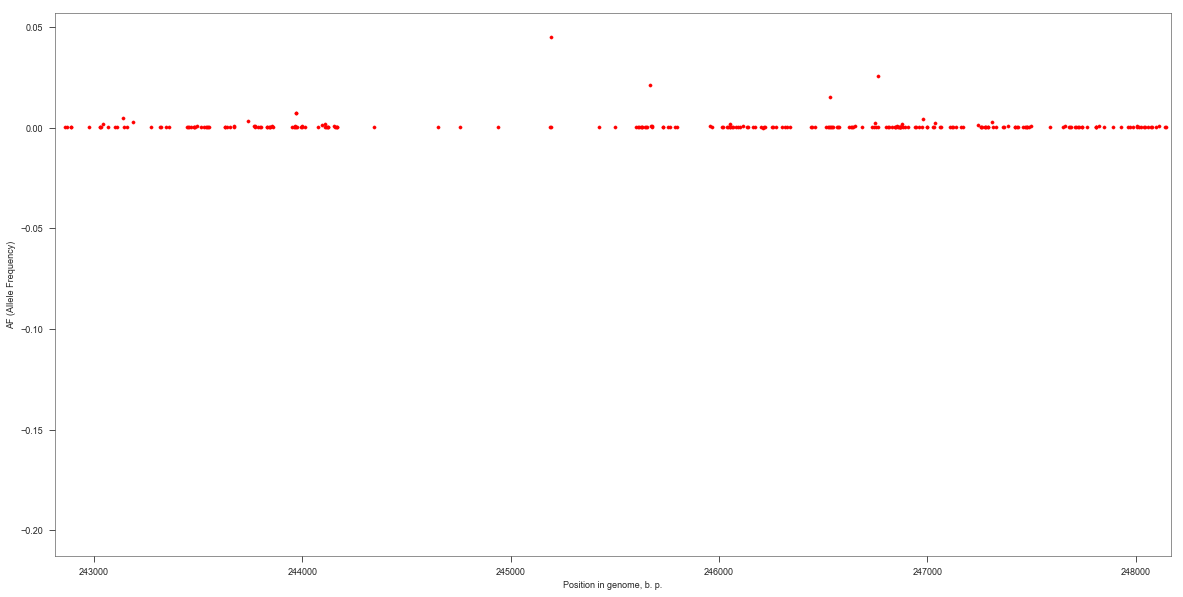

step # 1 PF3D7_1249800 start 2030004.0 end 2039852.0 "THO complex subunit 2, putative (THO2)" Gene name THO2 Conservation score 0.283292123


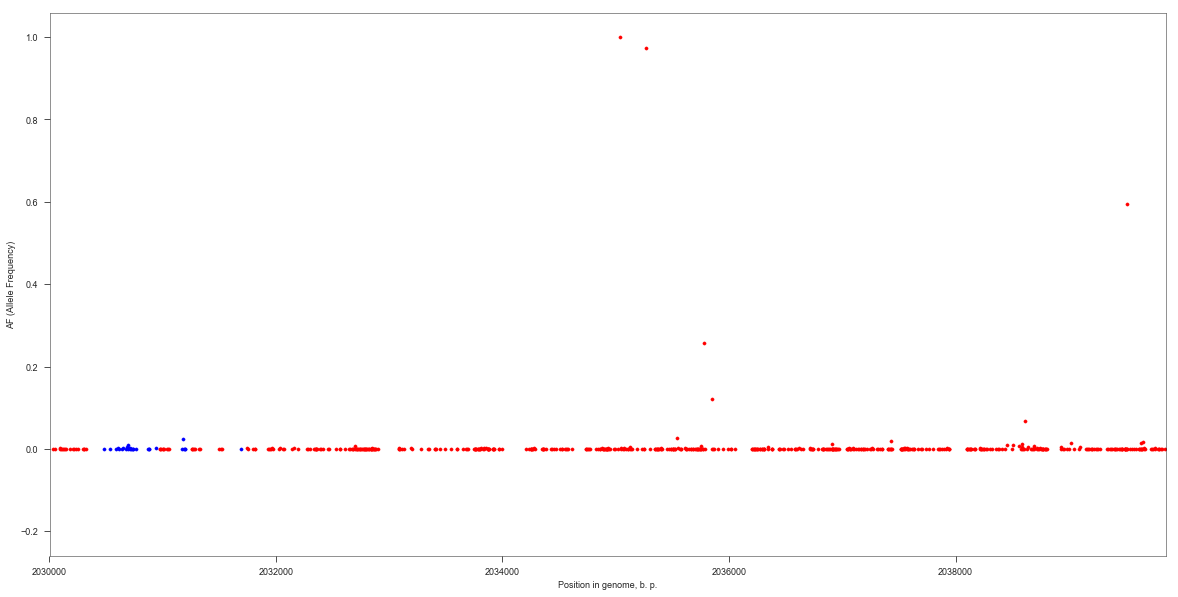

step # 2 PF3D7_1009100 start 372519.0 end 374072.0 conserved+Plasmodium+membrane+protein%2C+unknown+function Gene name PF3D7_1009100 Conservation score -0.255319149


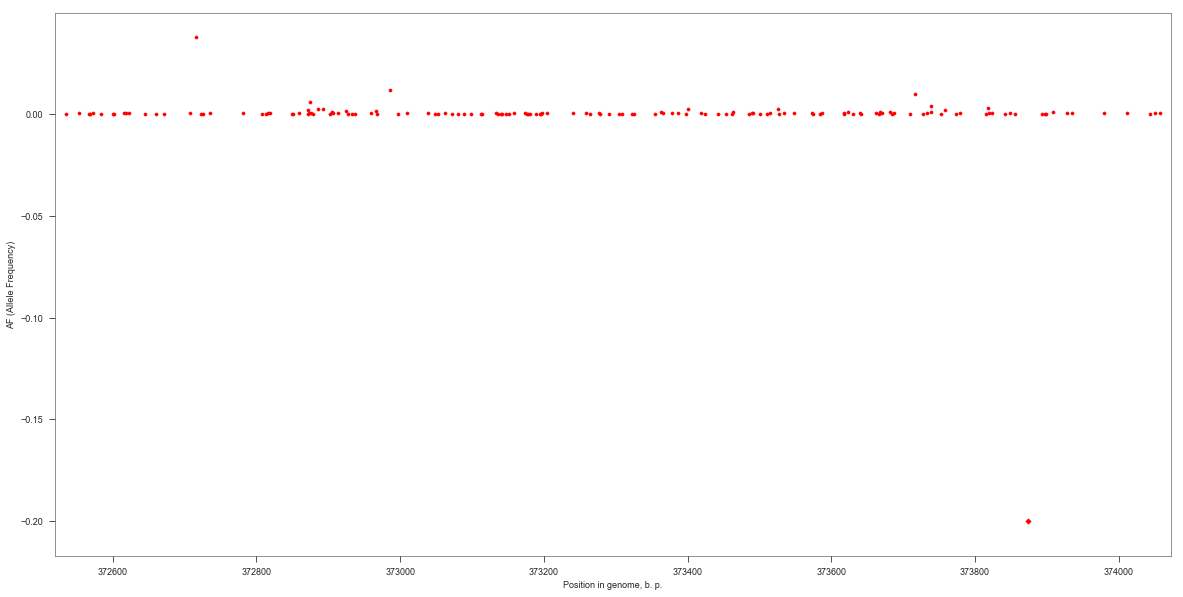

step # 3 PF3D7_0402300 start 137640.0 end 146653.0 reticulocyte+binding+protein+homologue+1%2Cnormocyte+binding+protein+1+%28RH1%29 Gene name RH1 Conservation score nan


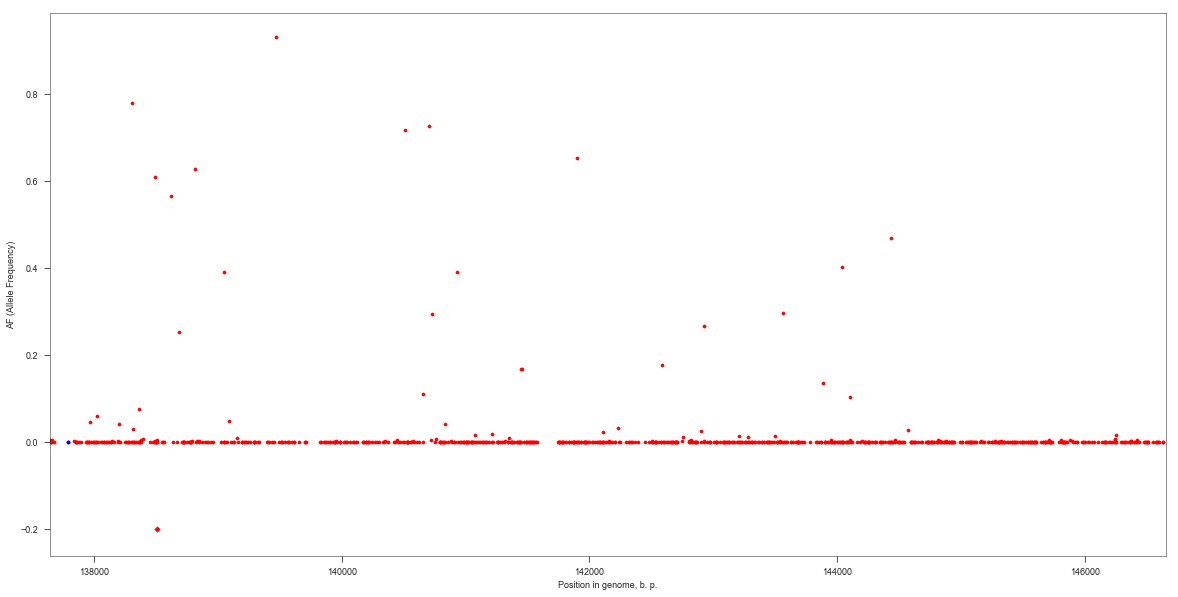

step # 4 PF3D7_0605400 start 224613.0 end 225095.0 "calcium-binding protein, putative" Gene name PF3D7_0605400 Conservation score 3.375


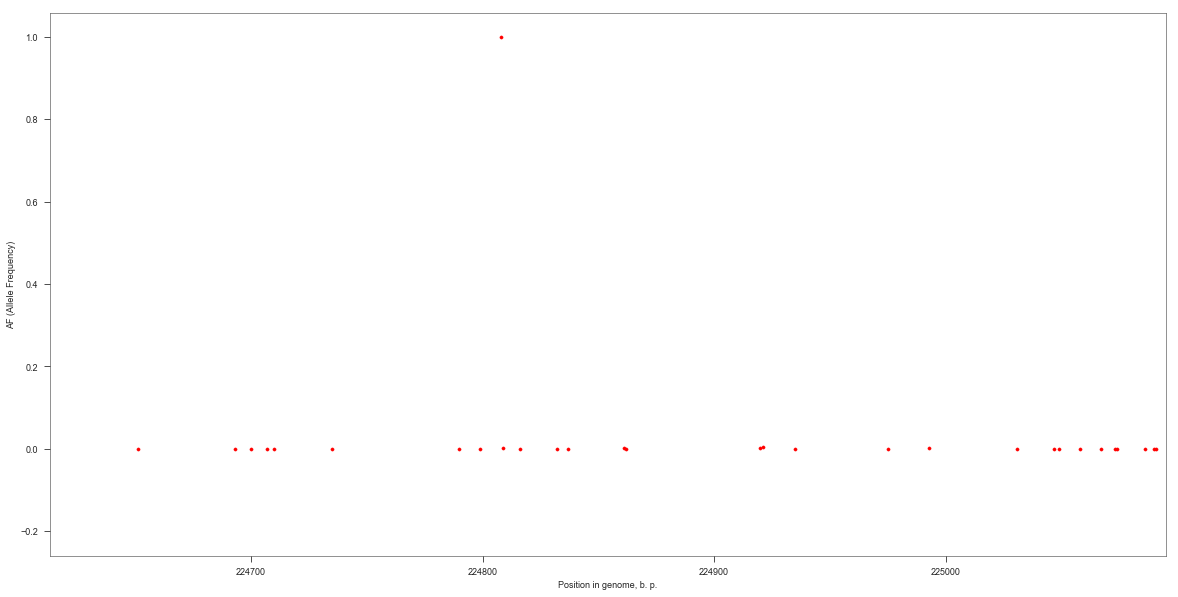

step # 5 PF3D7_0515400 start 637354.0 end 640381.0 "conserved Plasmodium protein, unknown function" Gene name PF3D7_0515400 Conservation score 1.060446781


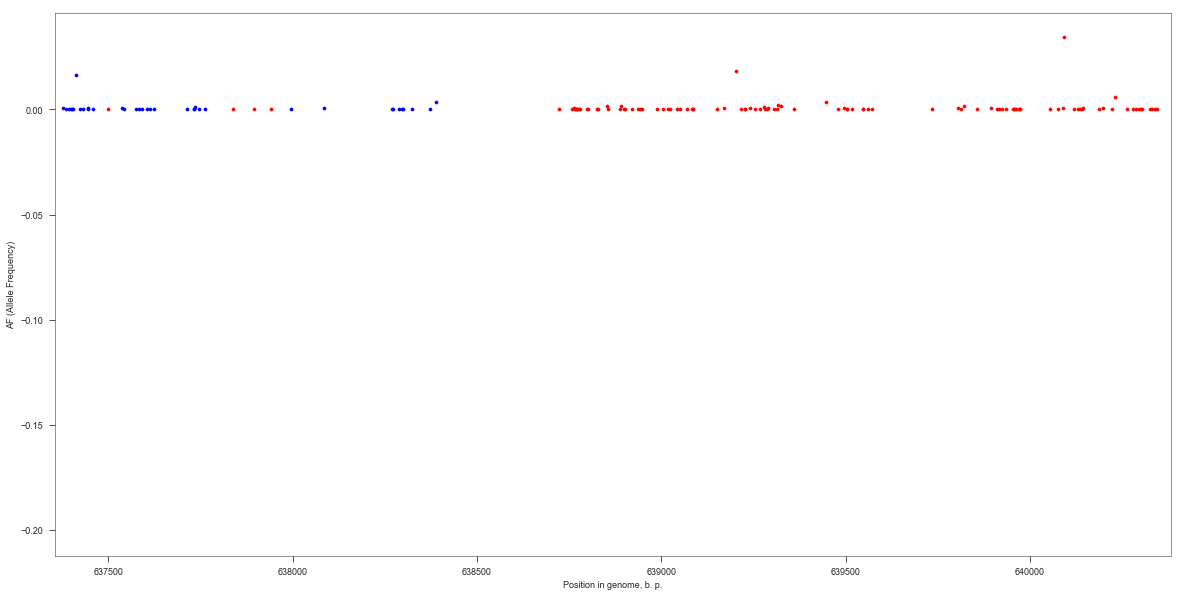

step # 6 PF3D7_0927200 start 1107143.0 end 1112656.0 zinc finger protein, putative Gene name PF3D7_0927200 Conservation score -0.59127228


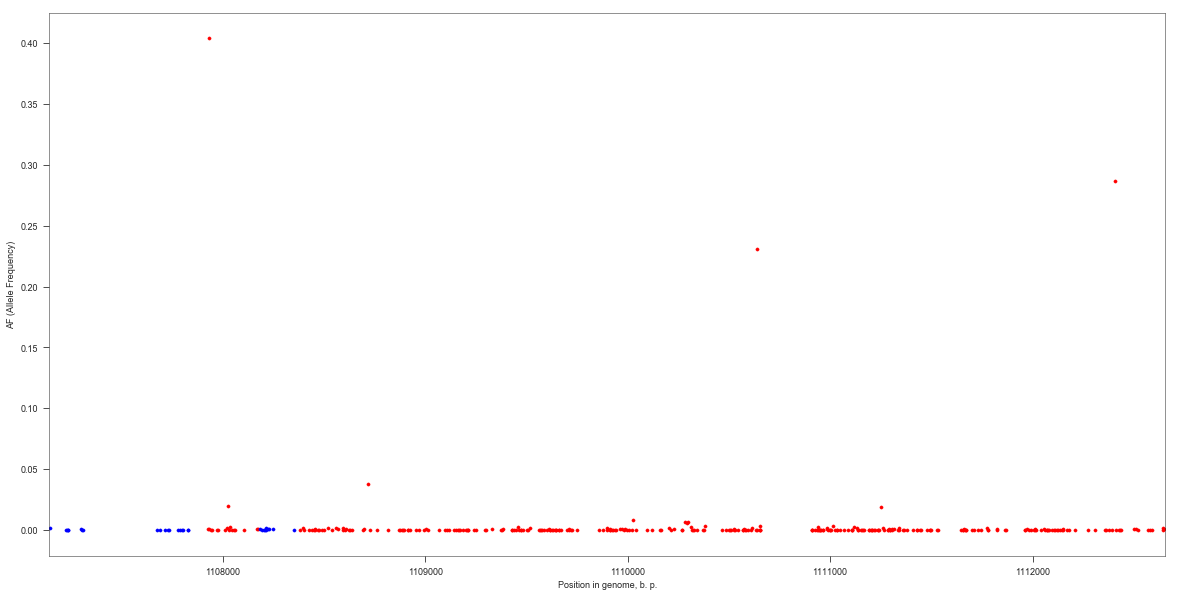

step # 7 PF3D7_1477500 start 3188888.0 end 3190548.0 "Plasmodium exported protein (PHISTb), unknown function" Gene name PF3D7_1477500 Conservation score nan


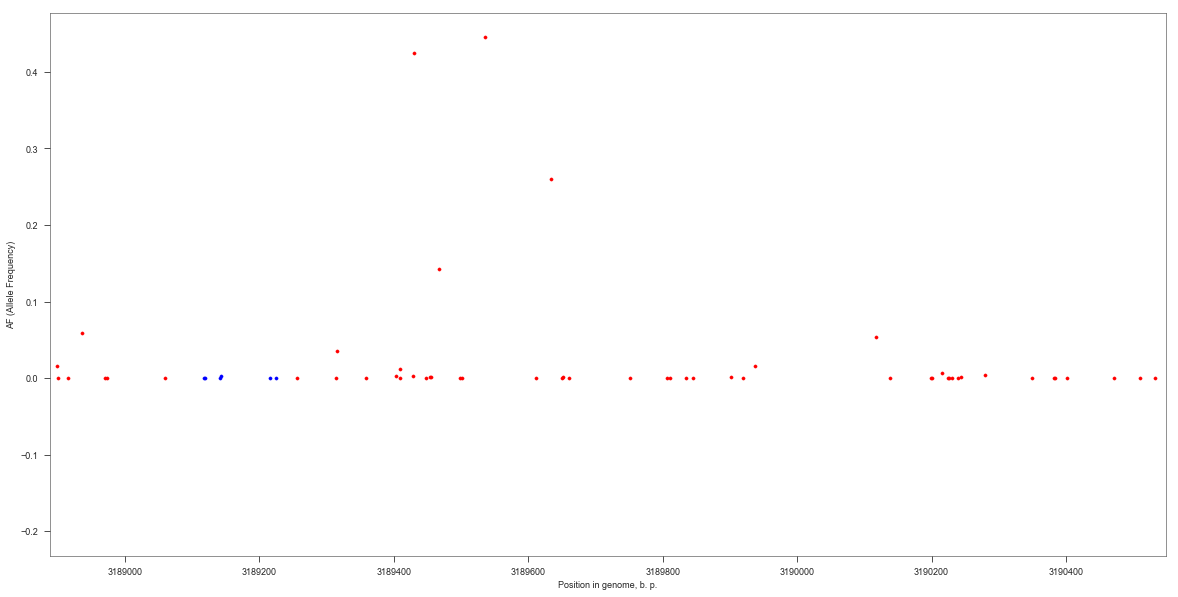

step # 8 PF3D7_1213900 start 595167.0 end 598776.0 "conserved Plasmodium protein, unknown function" Gene name PF3D7_1213900 Conservation score 1.113456464


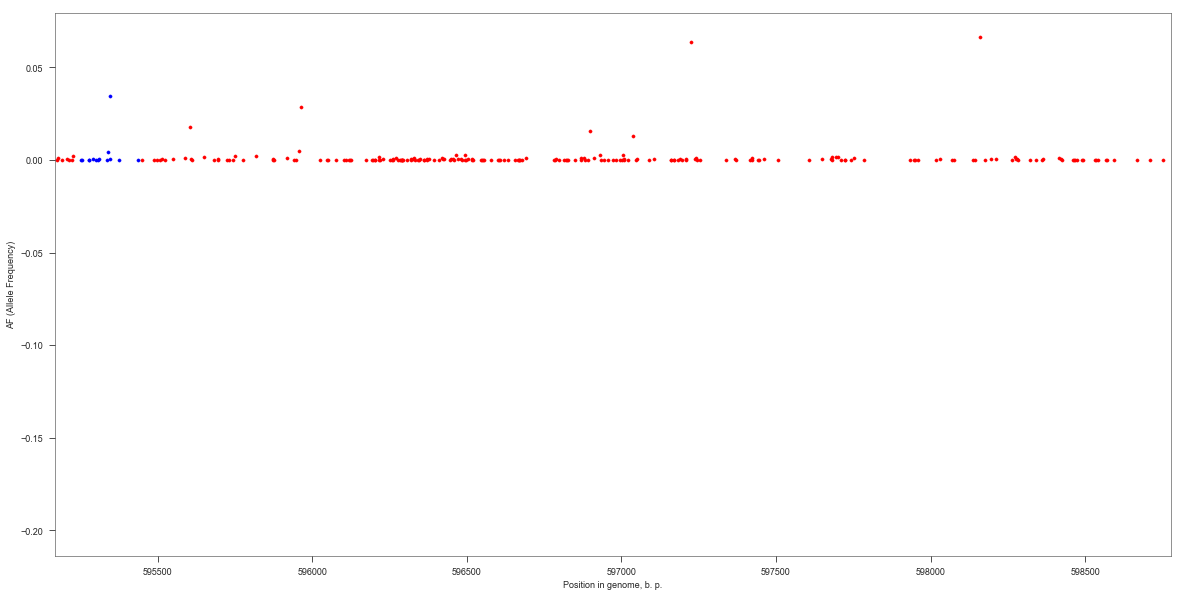

step # 9 PF3D7_0916400 start 683562.0 end 691121.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_0916400 Conservation score -0.675664946


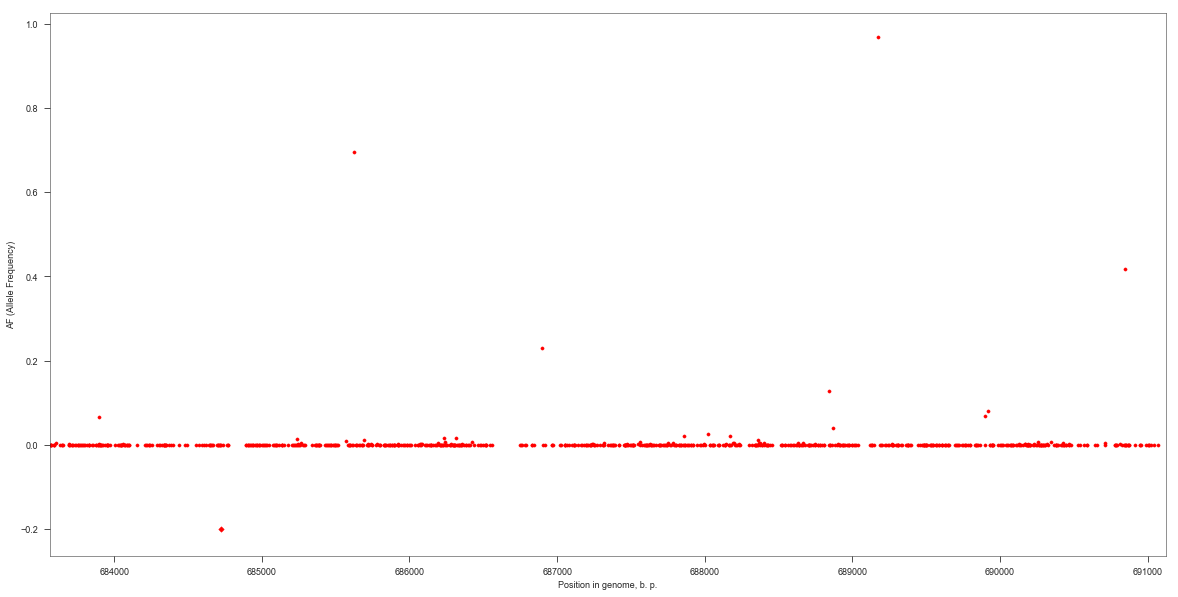

step # 10 PF3D7_1136600 start 1441503.0 end 1445471.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_1136600 Conservation score -0.39107413


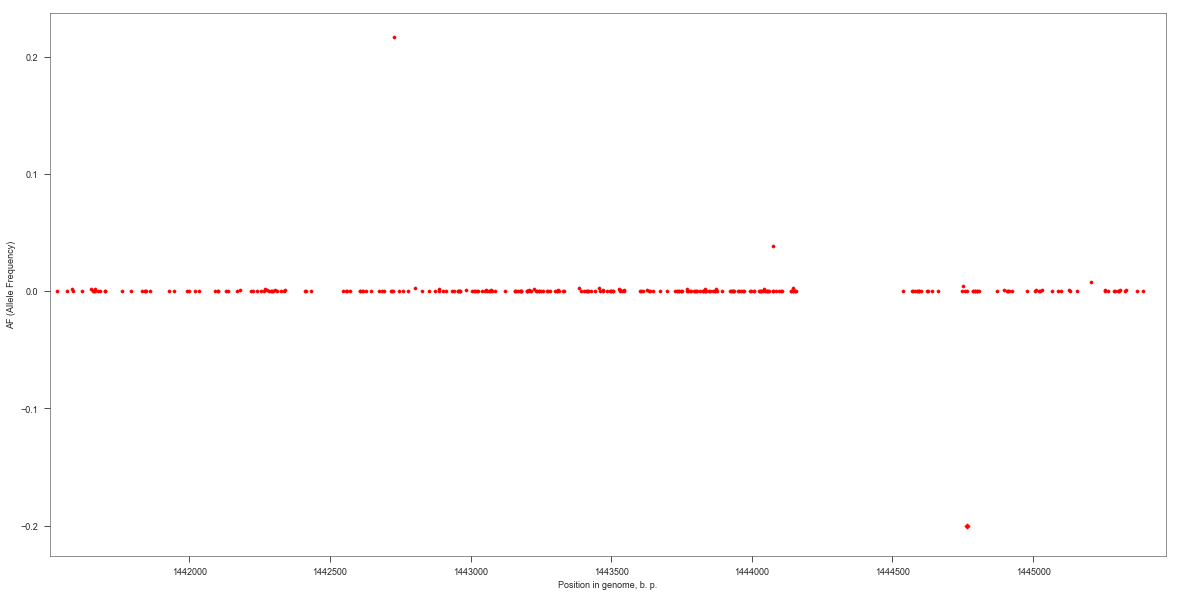

step # 11 PF3D7_0313400 start 545828.0 end 548182.0 "conserved Plasmodium protein, unknown function" Gene name PF3D7_0313400 Conservation score -0.192602041


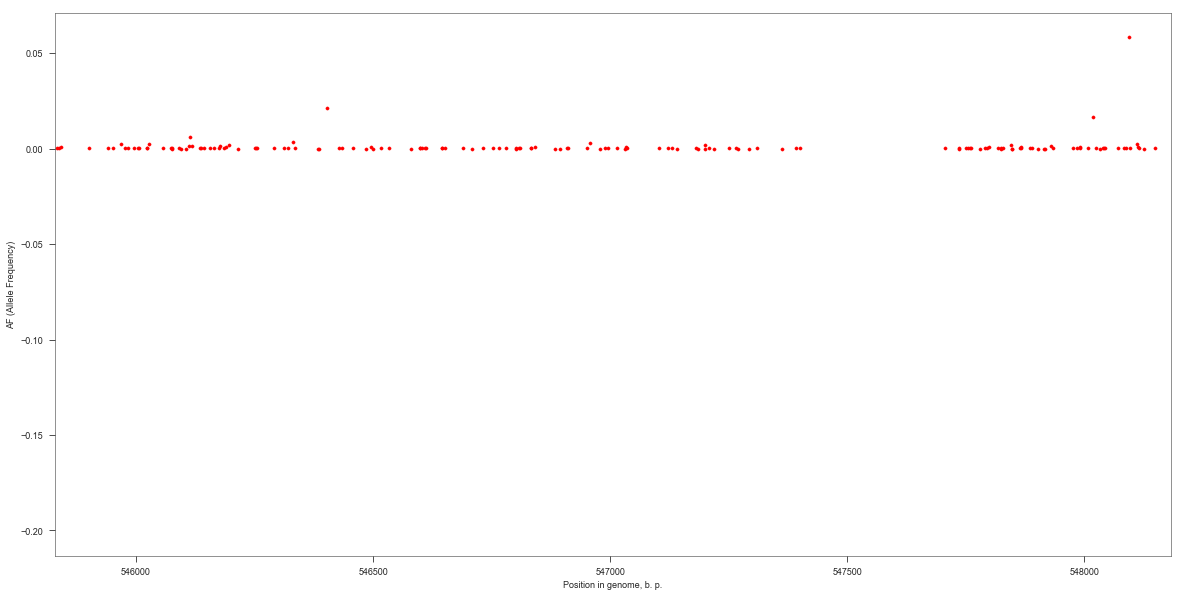

step # 12 PF3D7_0421700 start 987842.0 end 994360.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_0421700 Conservation score 0.44214876


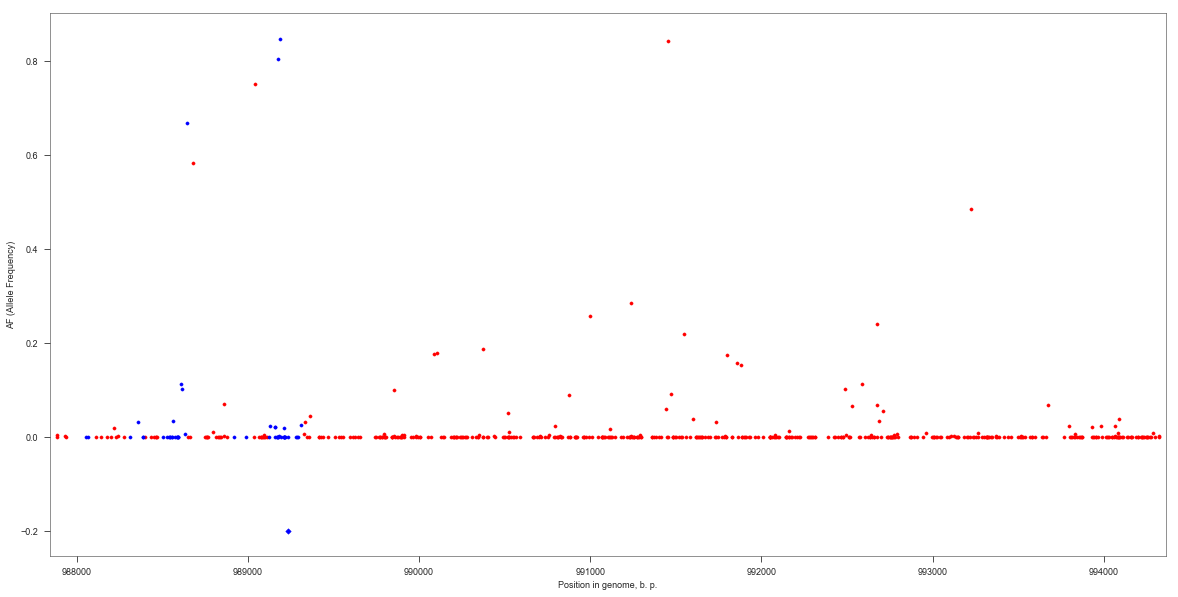

step # 13 PF3D7_1468400 start 2809478.0 end 2812066.0 "zinc finger protein, putative (D13)" Gene name D13 Conservation score 0.791183295


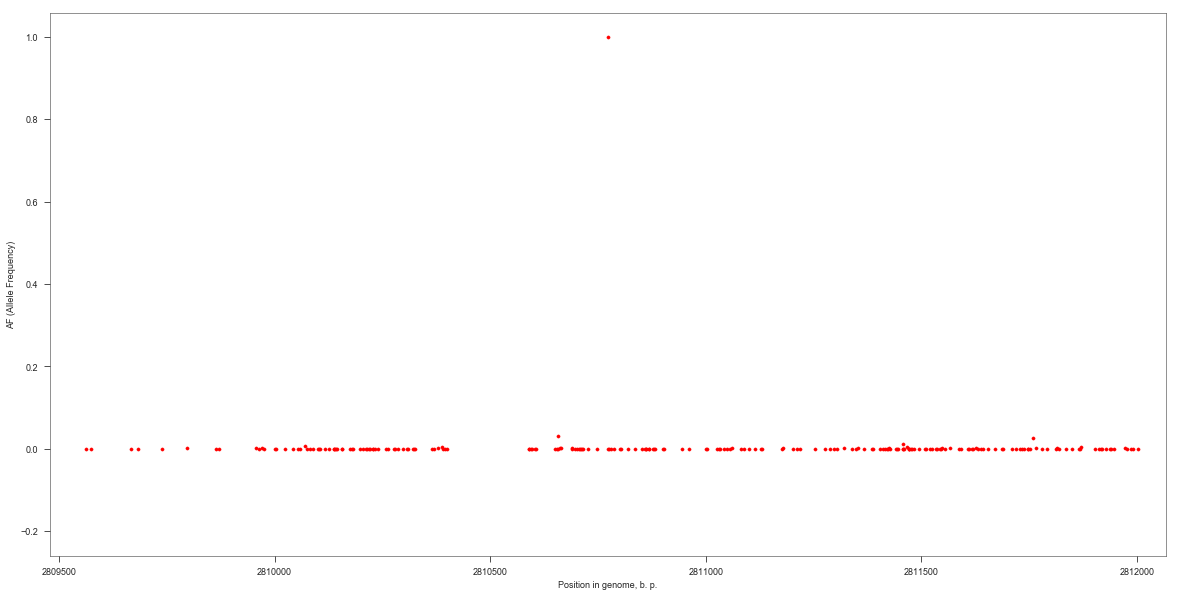

step # 14 PF3D7_0103100 start 134353.0 end 139257.0 vacuolar protein sorting-associated protein 51, putative Gene name VPS51 Conservation score -0.447368421


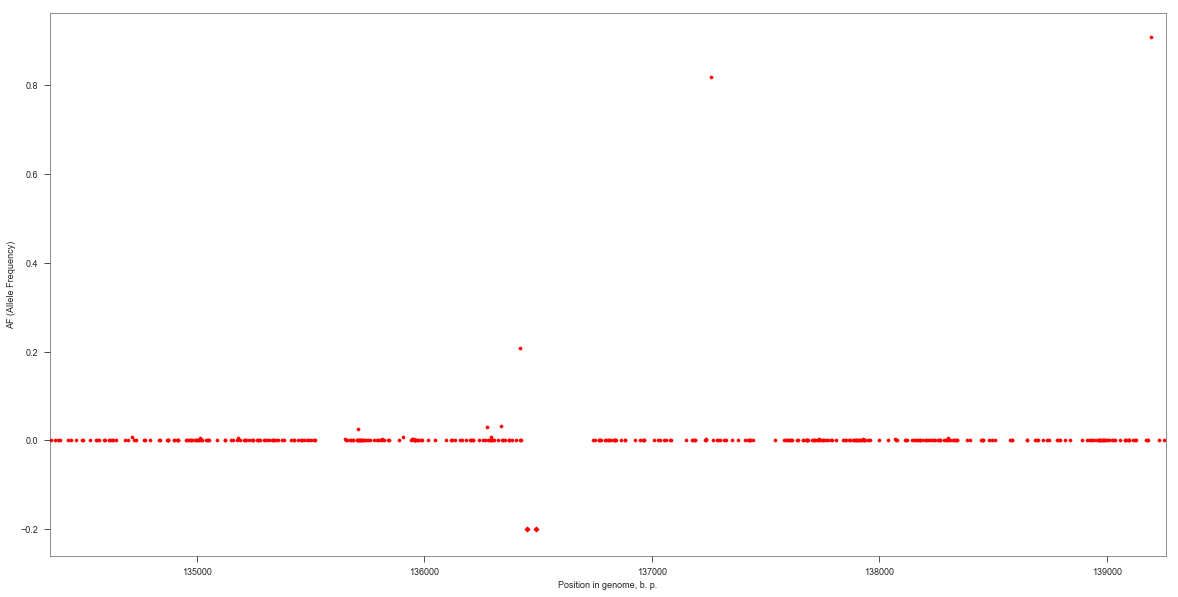

step # 15 PF3D7_0525100 start 1041745.0 end 1043766.0 acyl-CoA synthetase (ACS10) Gene name ACS10 Conservation score 3.127786033


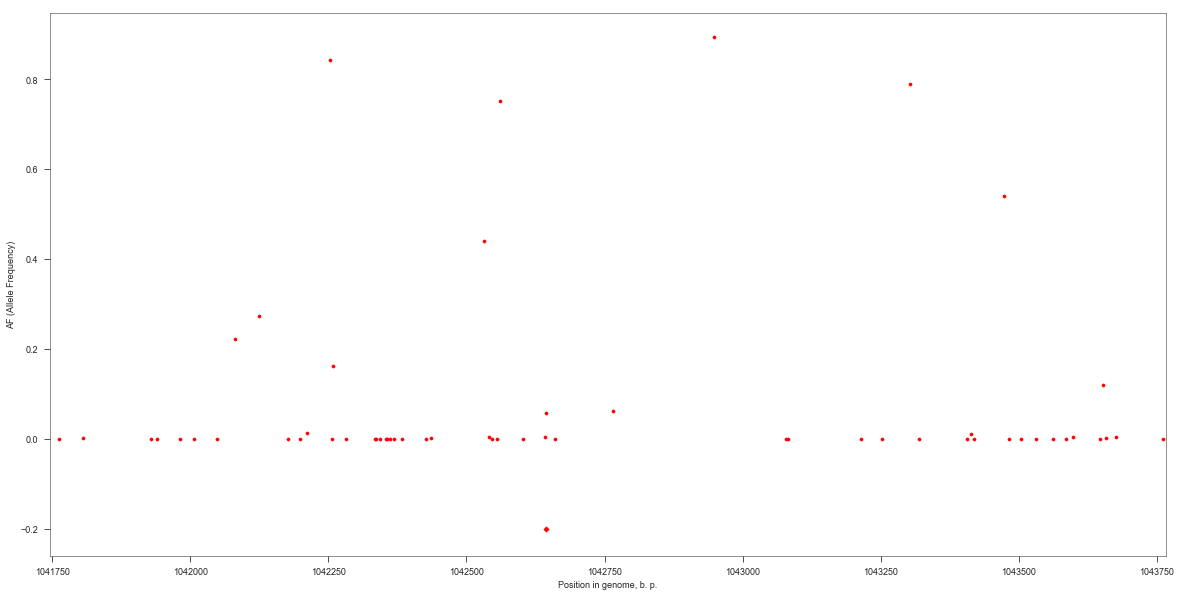

step # 16 PF3D7_1229100 start 1192888.0 end 1199214.0 ABC+transporter%2C+%28CT+family%29+%28MRP2%29 Gene name MRP2 Conservation score nan


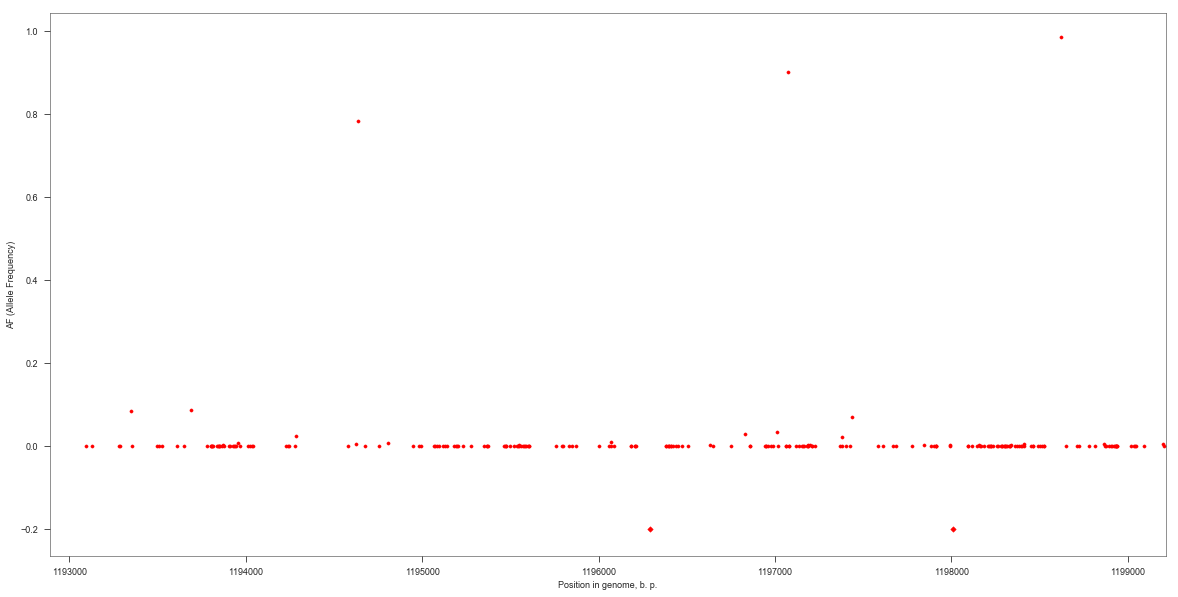

step # 17 PF3D7_1313100 start 556285.0 end 565251.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_1313100 Conservation score 0.069910898


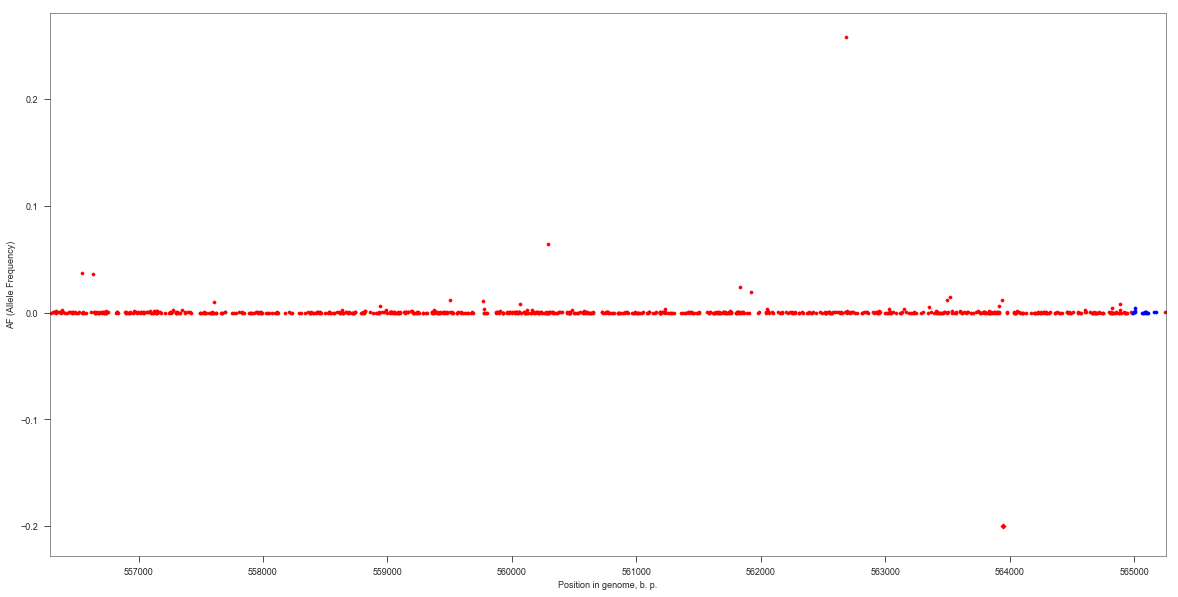

step # 18 PF3D7_1354900 start 2184037.0 end 2185950.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_1354900 Conservation score 0.472527473


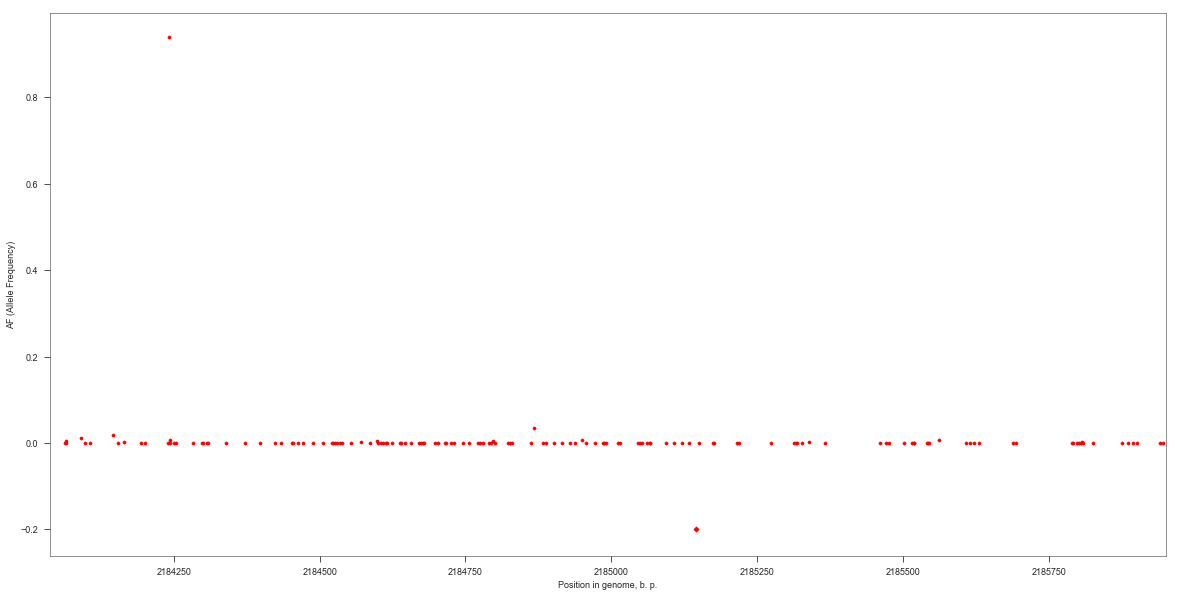

step # 19 PF3D7_1036800 start 1448692.0 end 1451646.0 acetyl-CoA+transporter%2C+putative Gene name ACT Conservation score 2.766101695


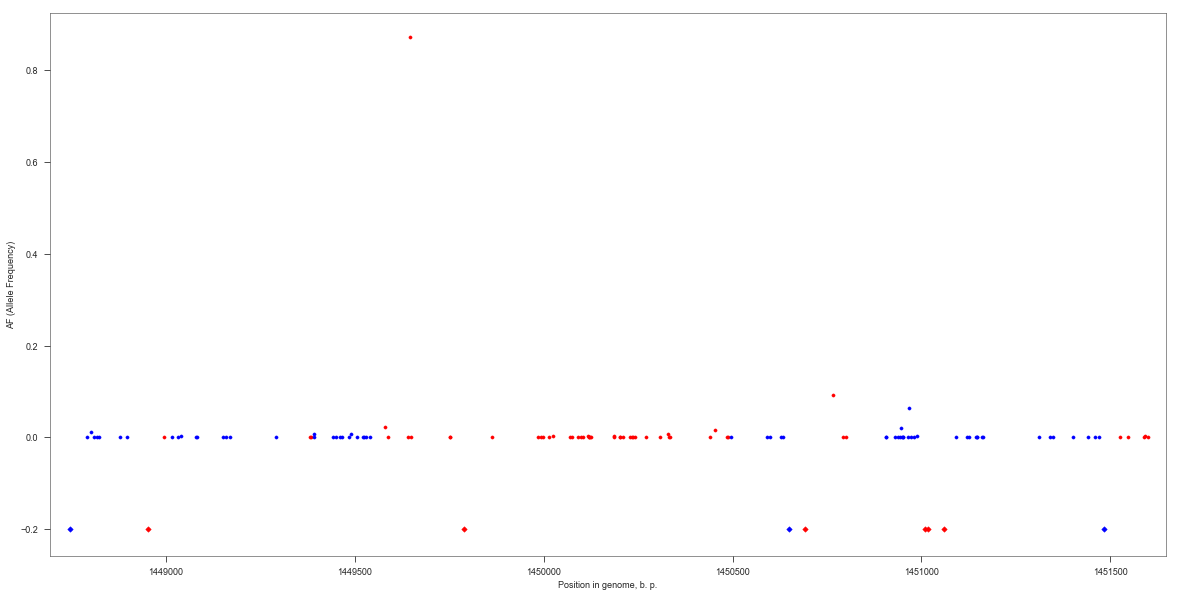

step # 20 PF3D7_0404600 start 247731.0 end 260147.0 conserved+Plasmodium+membrane+protein%2C+unknown+function Gene name PF3D7_0404600 Conservation score 0.274045433


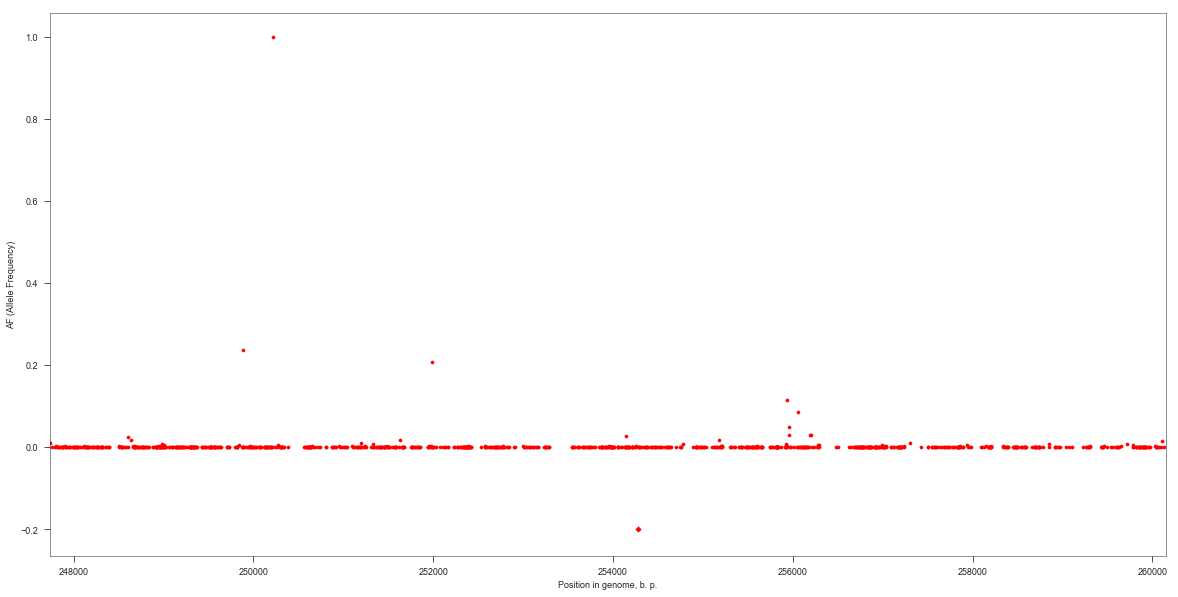

step # 21 PF3D7_0826100 start 1113369.0 end 1139144.0 E3+ubiquitin-protein+ligase%2C+putative Gene name PF3D7_0826100 Conservation score 1.216040042


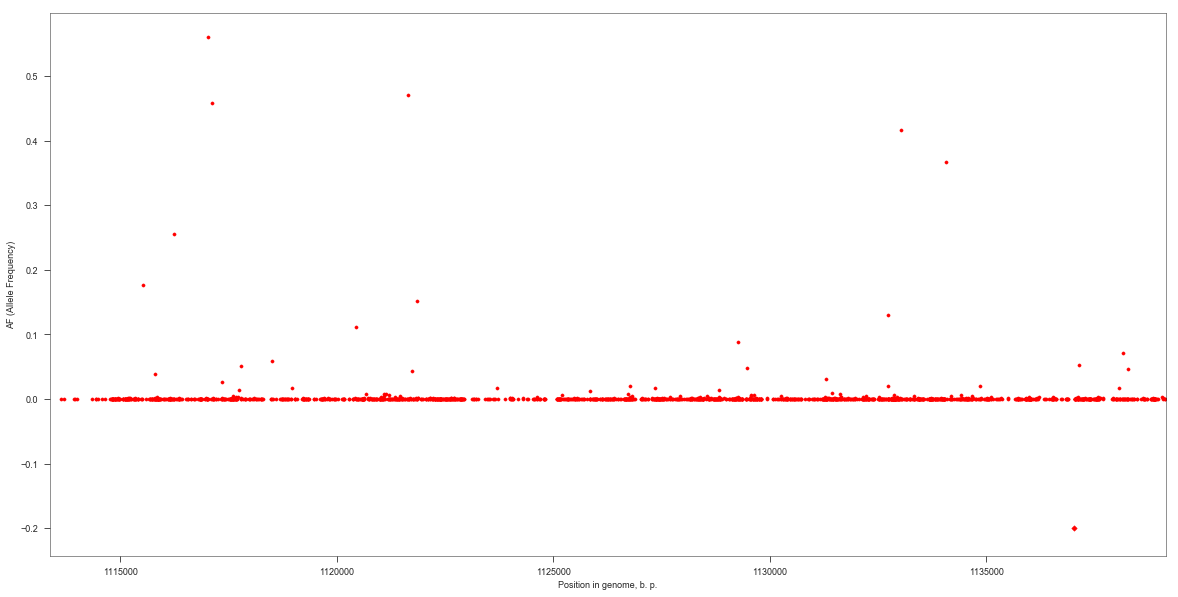

step # 22 PF3D7_1361100 start 2450461.0 end 2453760.0 Sec24+subunit+a+%28SEC24a%29 Gene name SEC24A Conservation score 3.711702128


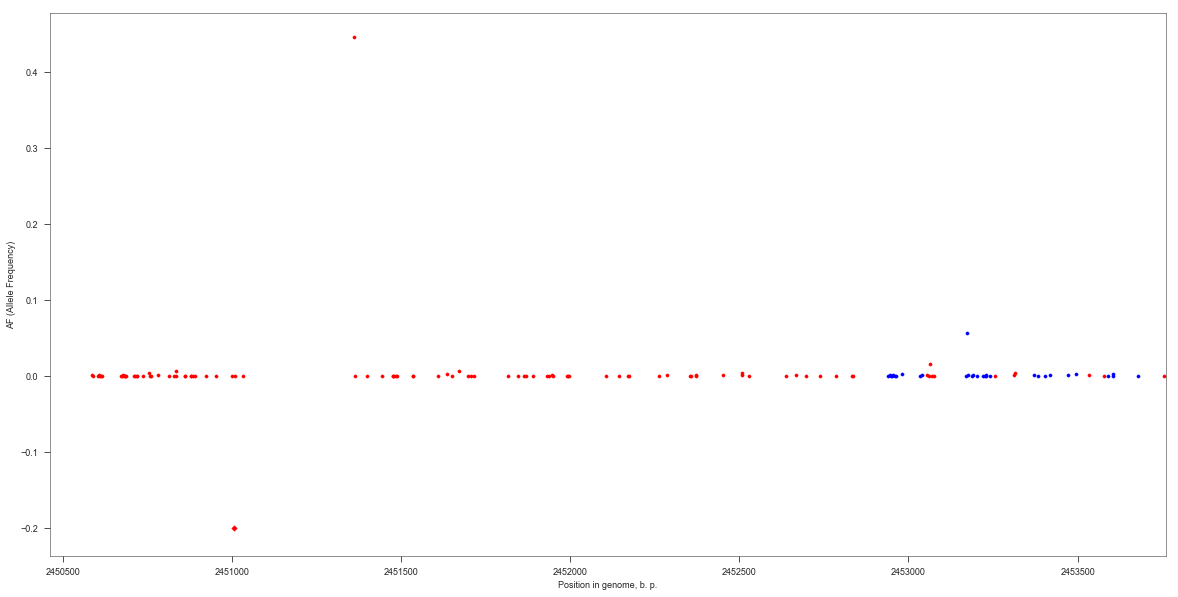

step # 23 PF3D7_1475400 start 3087061.0 end 3105071.0 cysteine+repeat+modular+protein+4+%28CRMP4%29 Gene name CRMP4 Conservation score 1.185573993


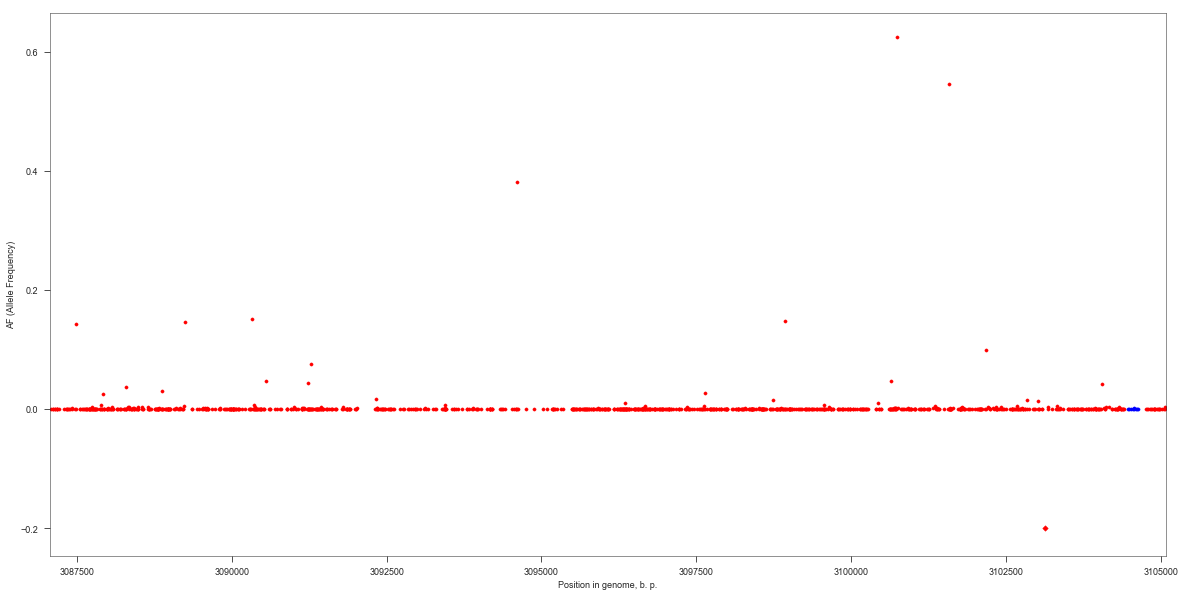

step # 24 PF3D7_1224200 start 981301.0 end 984475.0 "conserved Plasmodium protein, unknown function" Gene name PF3D7_1224200 Conservation score 2.474969475


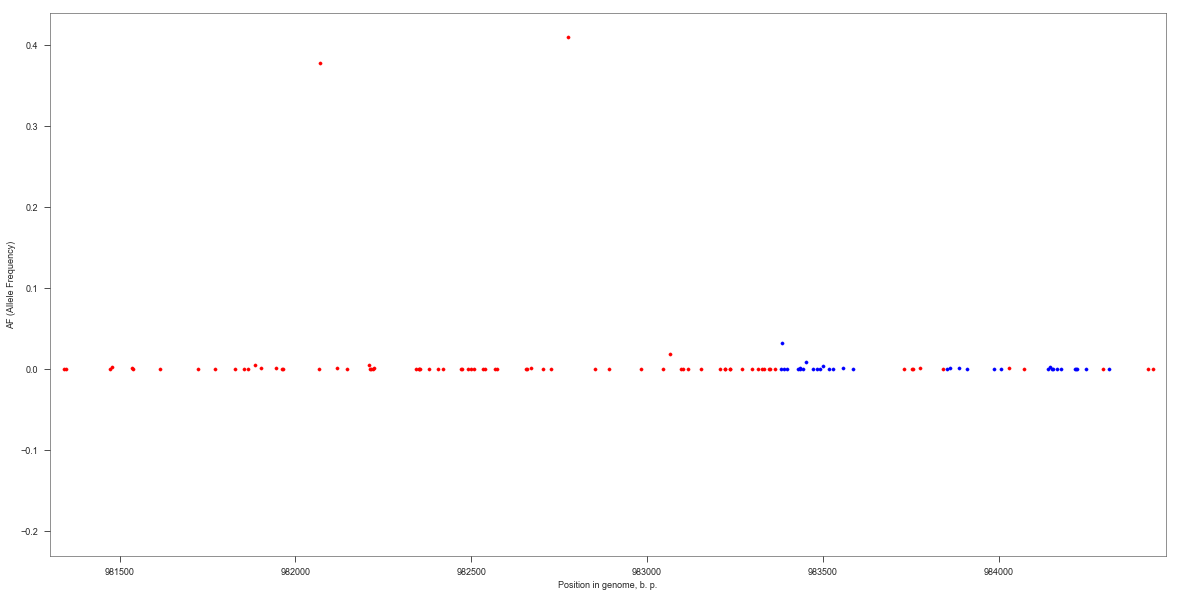

step # 25 PF3D7_1139300 start 1556744.0 end 1565045.0 transcription factor with AP2 domain(s) (ApiAP2) Gene name ApiAP2 Conservation score 0.153411233


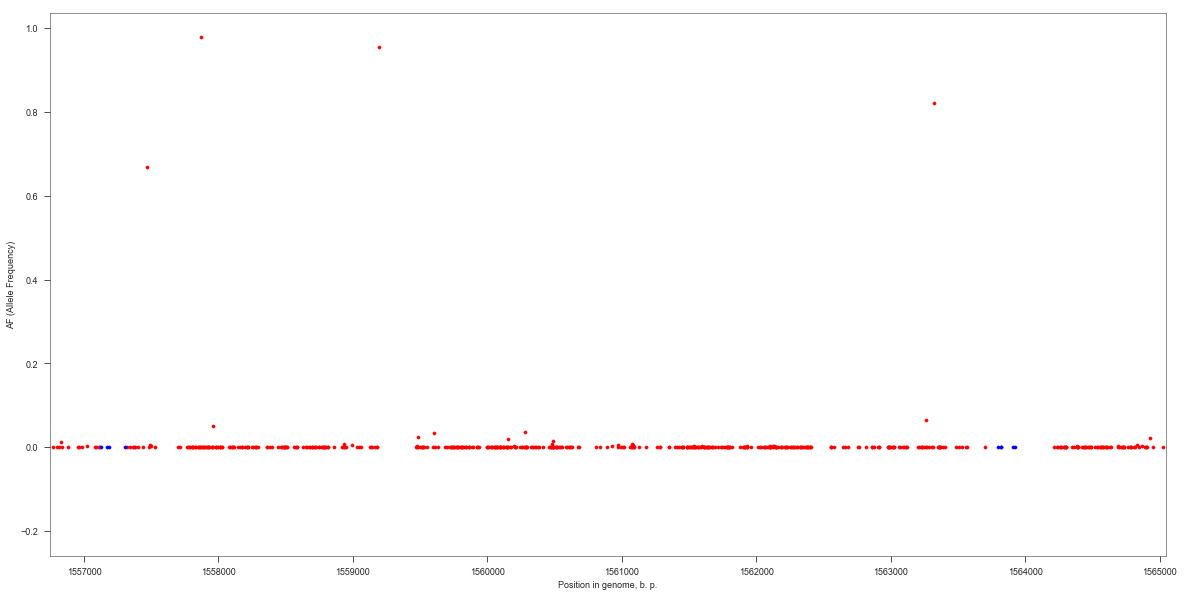

step # 26 PF3D7_0205300 start 219690.0 end 222256.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_0205300 Conservation score 0.152597403


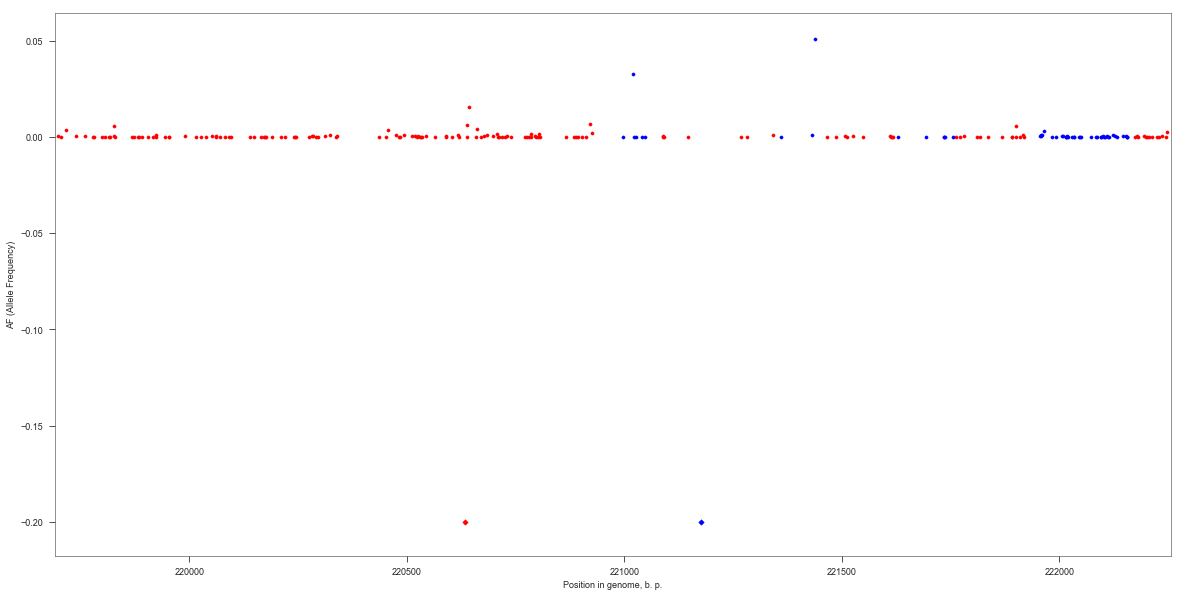

step # 27 PF3D7_1302100 start 121636.0 end 122289.0 gamete antigen 27/25 (G27/25) Gene name G27/25 Conservation score nan


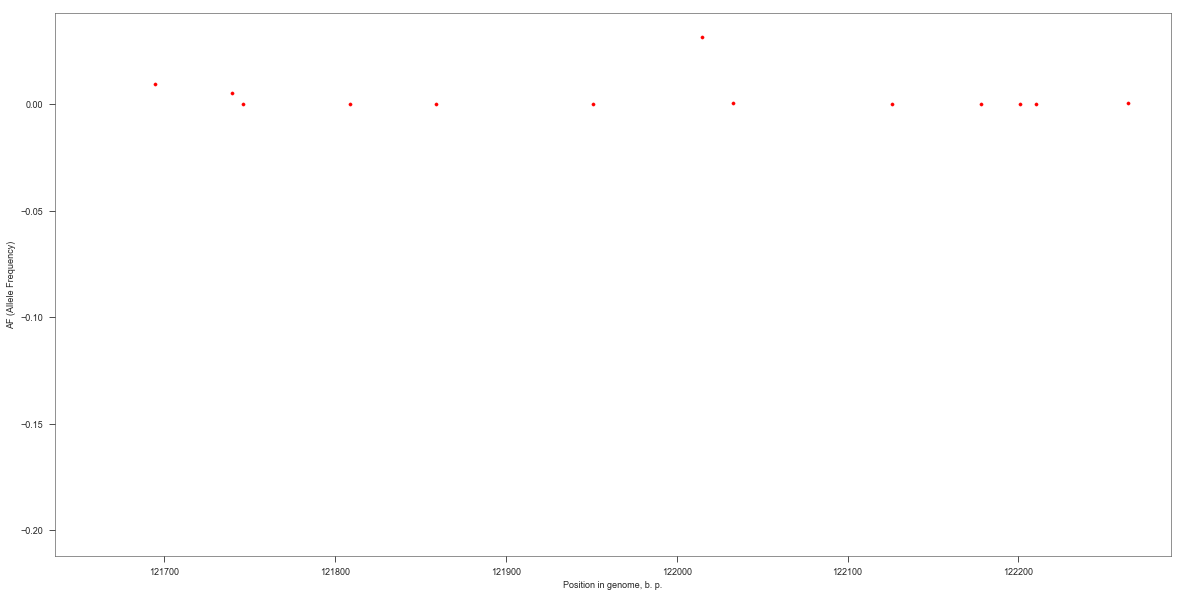

step # 28 PF3D7_0107500 start 304362.0 end 309257.0 lipid%2Fsterol%3AH++symporter Gene name PF3D7_0107500 Conservation score 1.778911565


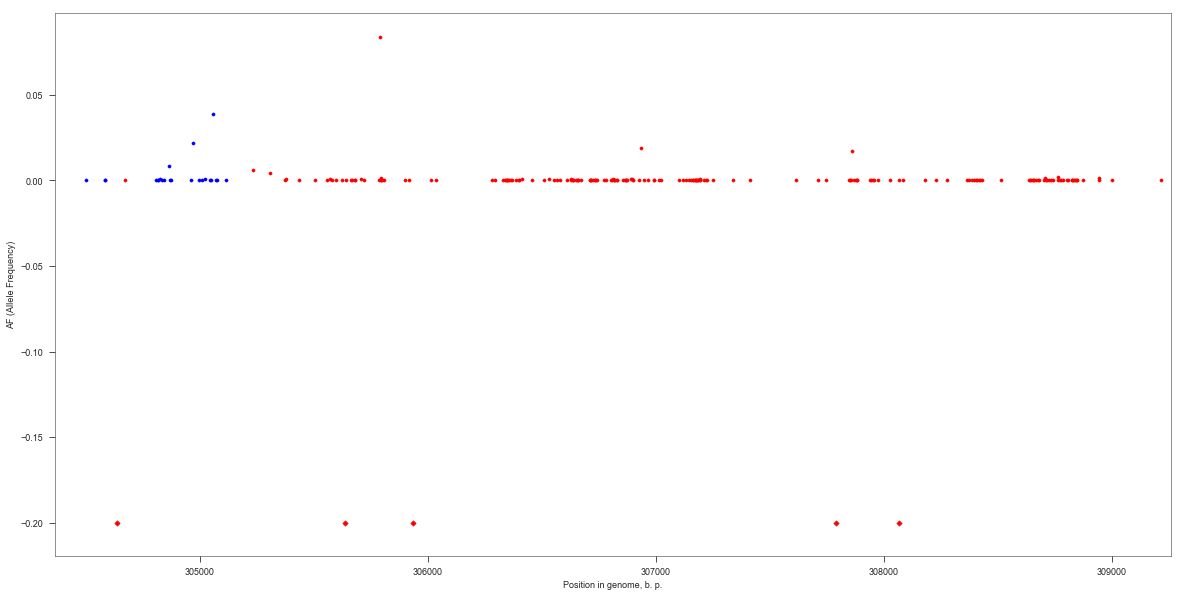

step # 29 PF3D7_0503900 start 153889.0 end 156057.0 "conserved Plasmodium protein, unknown function" Gene name PF3D7_0503900 Conservation score 1.648036254


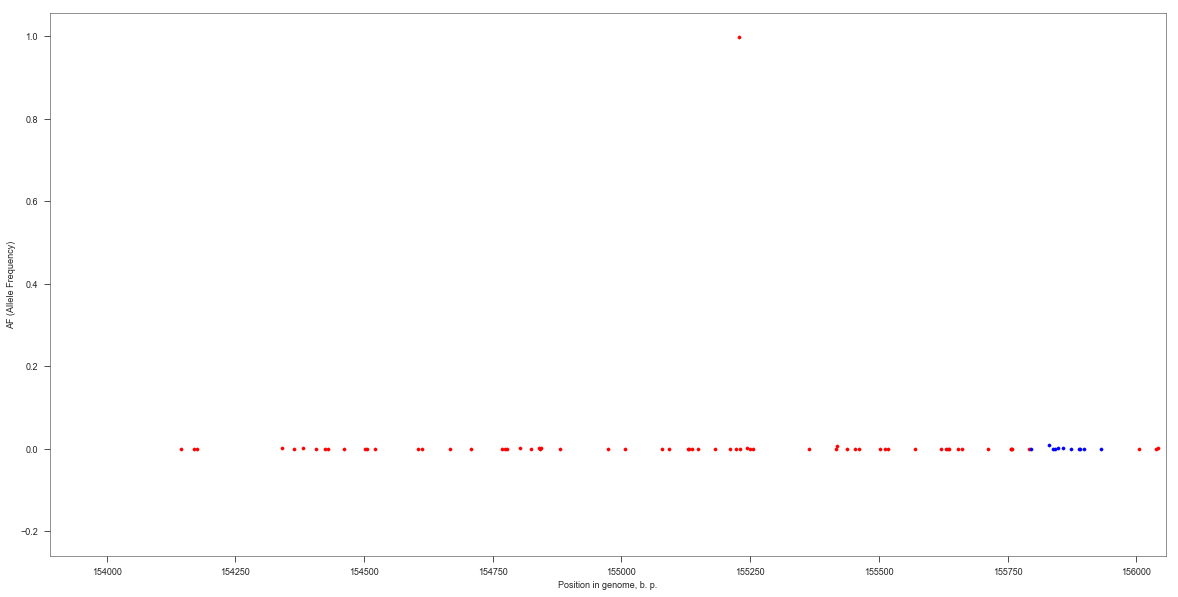

step # 30 PF3D7_1414700 start 592992.0 end 597146.0 ubiquitin+carboxyl-terminal+hydrolase%2C+putative Gene name PF3D7_1414700 Conservation score 0.582369942


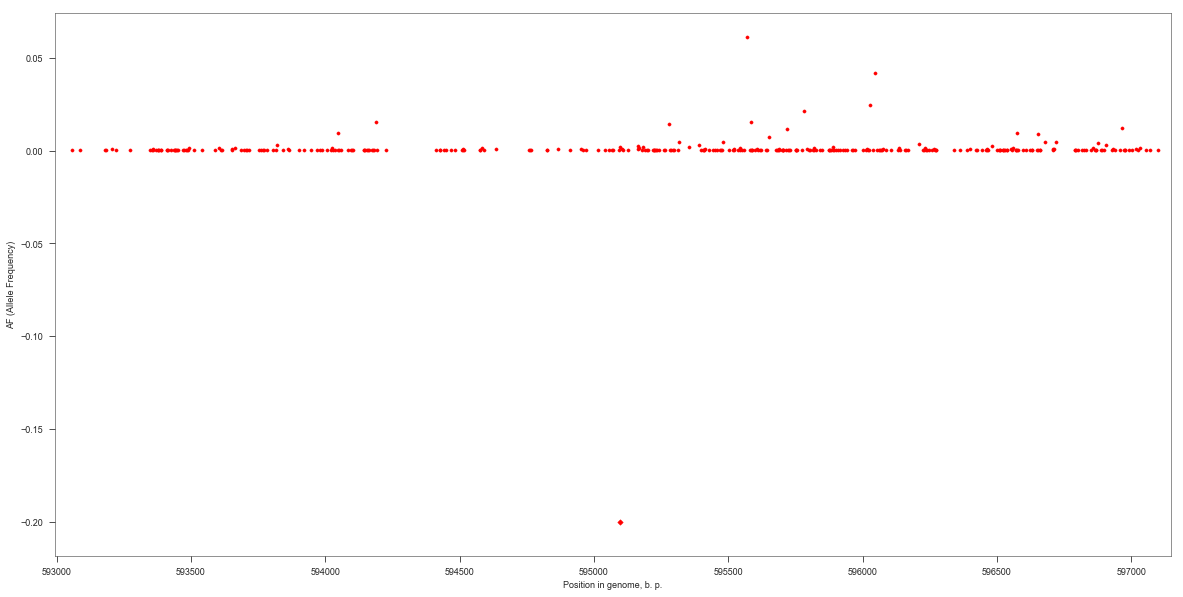

step # 31 PF3D7_1002200 start 112929.0 end 116015.0 tryptophan-rich antigen 3 (PArt) Gene name PArt Conservation score nan


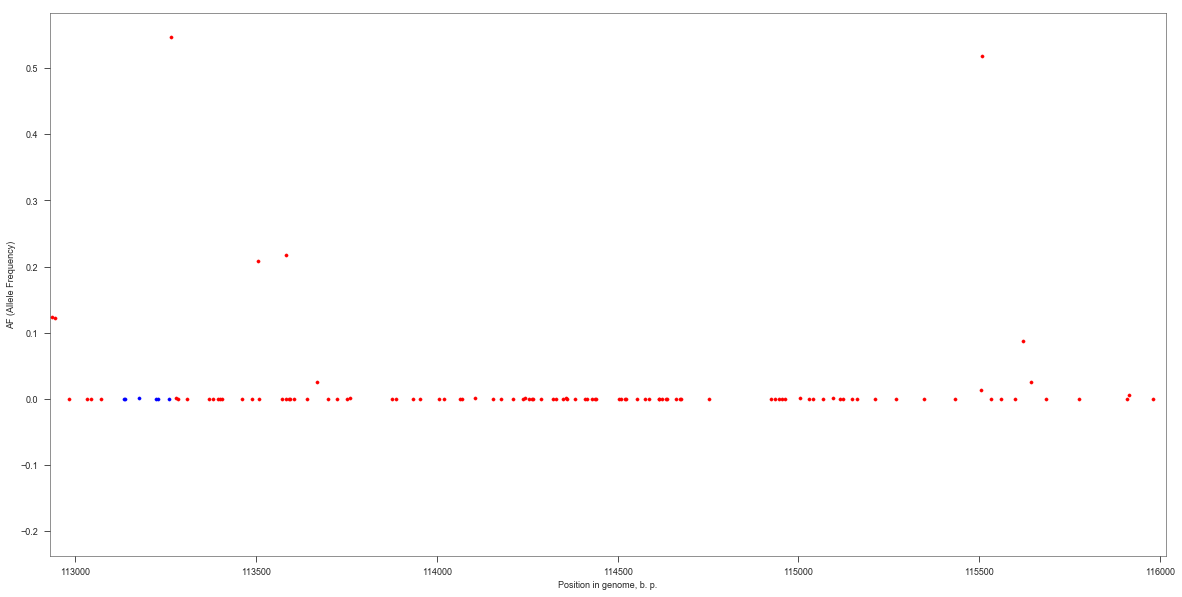

step # 32 PF3D7_0510200 start 437495.0 end 439738.0 peptidyl-prolyl cis-trans isomerase (CYP87) Gene name CYP87 Conservation score 3.247657296


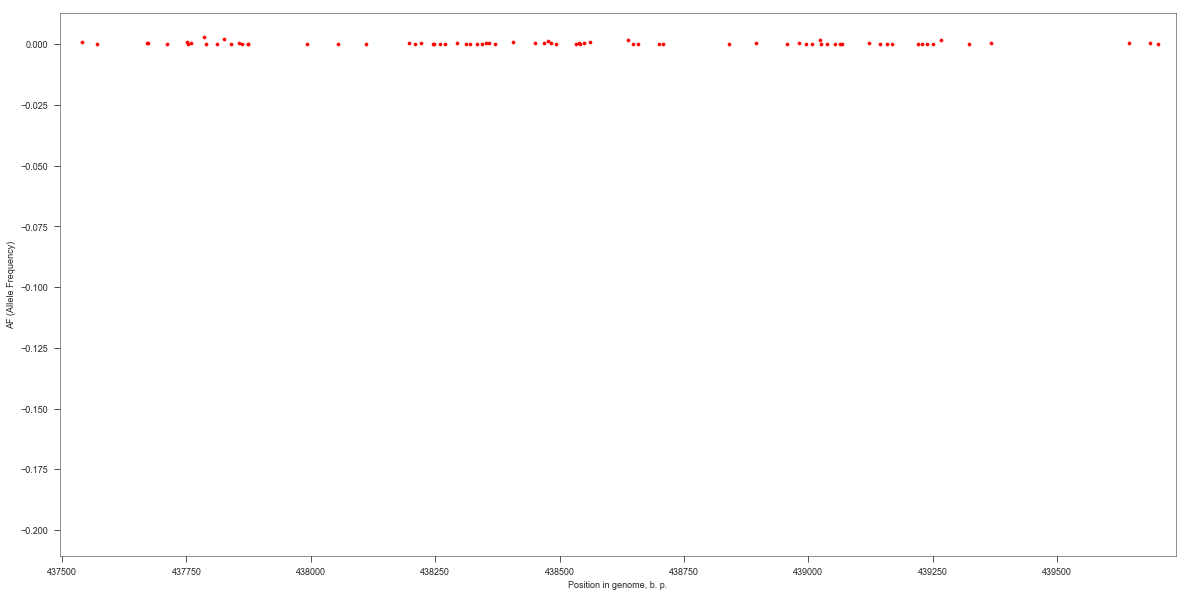

step # 33 PF3D7_0505100 start 220839.0 end 229253.0 trafficking+protein+particle+complex+subunit+8%2C+putative+%28TRS85%29 Gene name TRS85 Conservation score 0.670297749


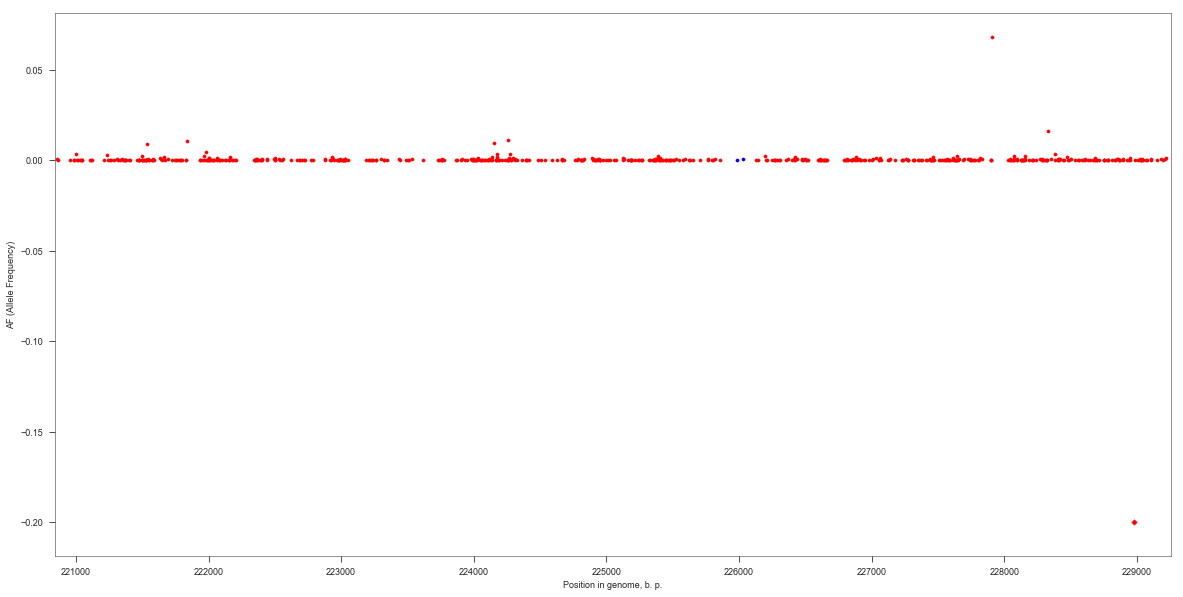

step # 34 PF3D7_1314600 start 624785.0 end 626011.0 lipoate-protein ligase 1 (LipL1) Gene name LipL1 Conservation score 3.453431373


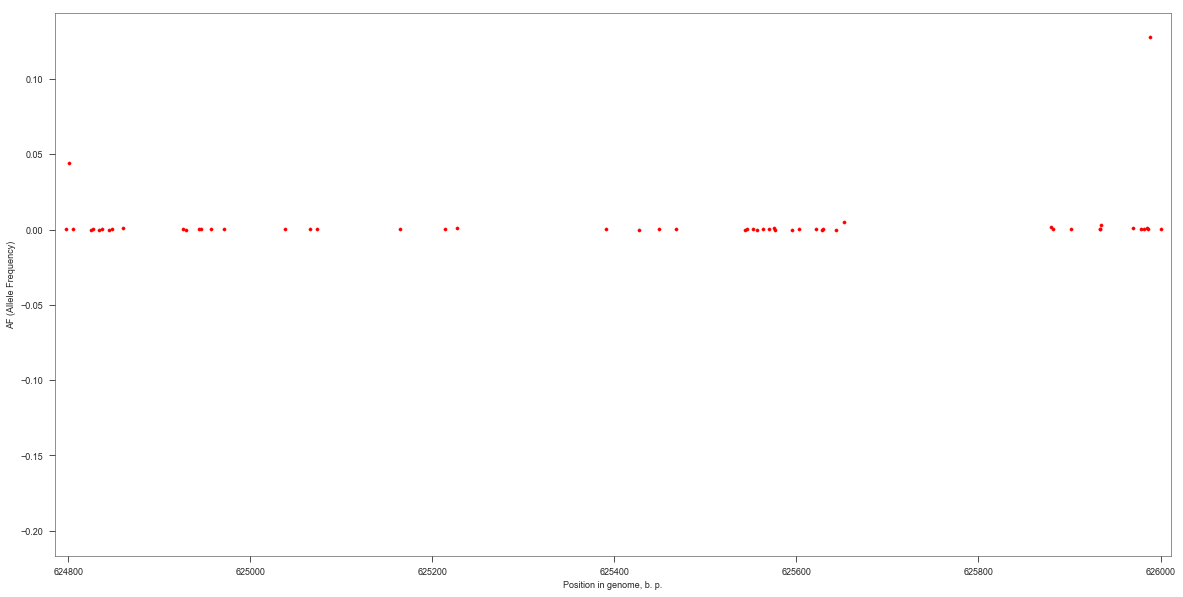

step # 35 PF3D7_0825000 start 1086048.0 end 1091248.0 "conserved Plasmodium protein, unknown function" Gene name PF3D7_0825000 Conservation score -0.238581731


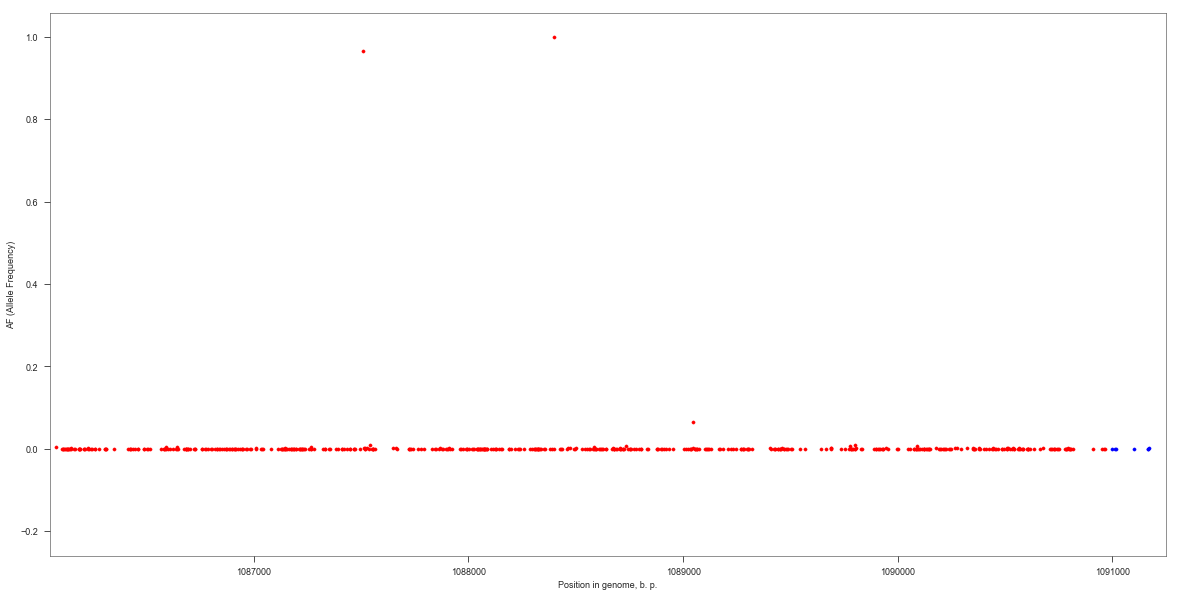

step # 36 PF3D7_1435800 start 1452604.0 end 1454118.0 "GTPase Era, putative (ERA)" Gene name ERA Conservation score 2.932539683


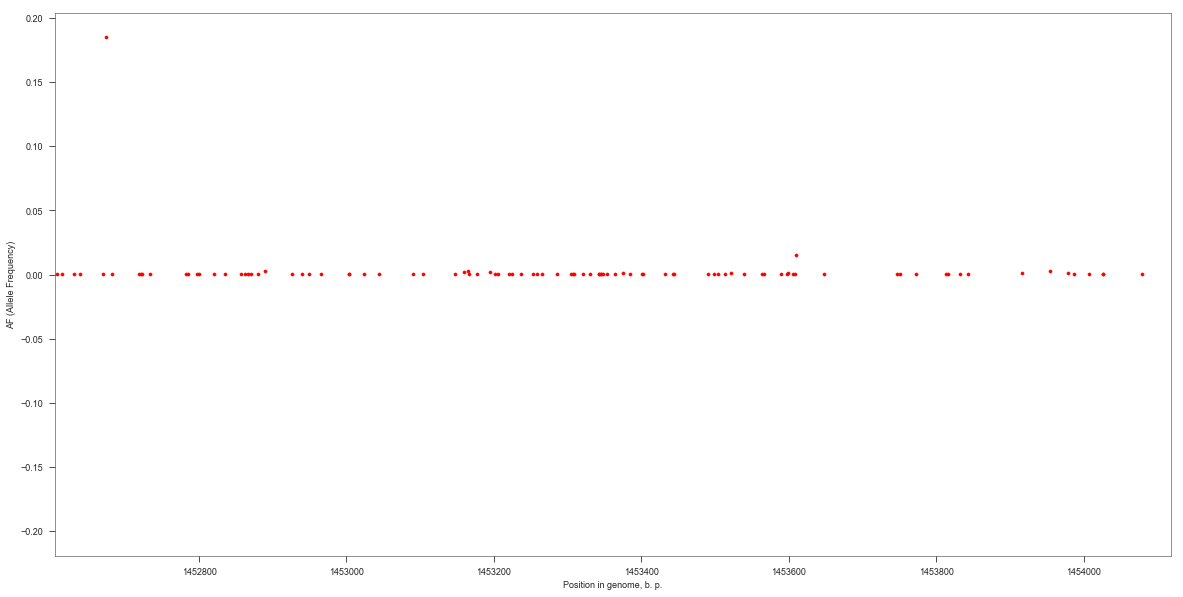

step # 37 PF3D7_0405300 start 282403.0 end 288297.0 sequestrin+%28LISP2%29 Gene name LISP2 Conservation score 0.00407332


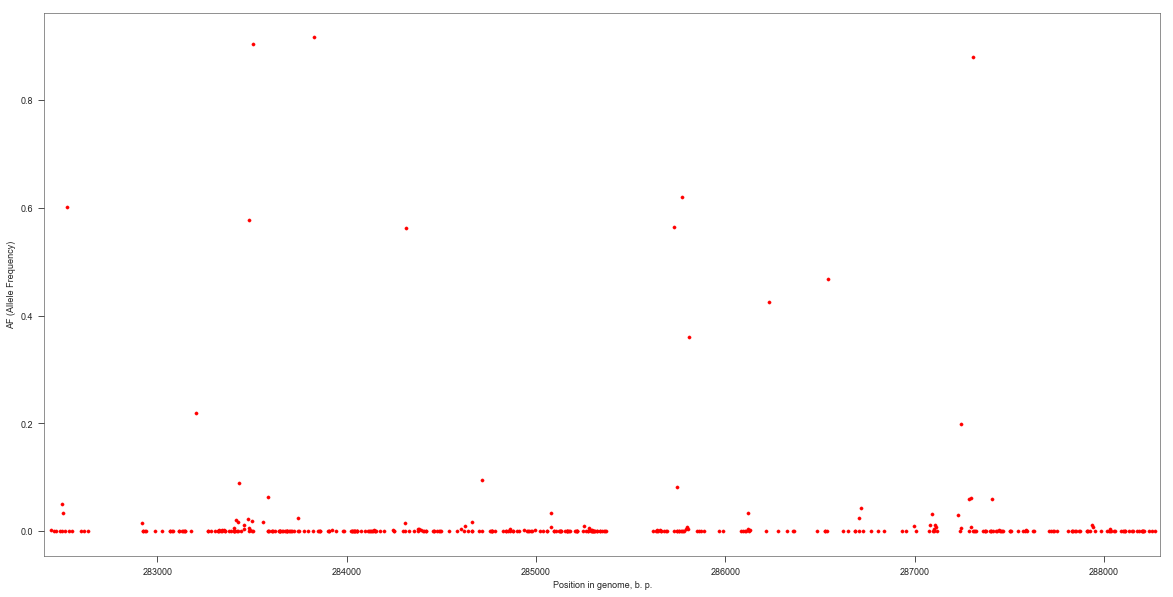

step # 38 PF3D7_1449400 start 2020209.0 end 2024137.0 crossover junction endonuclease MUS81, putative Gene name MUS81 Conservation score 0.579071597


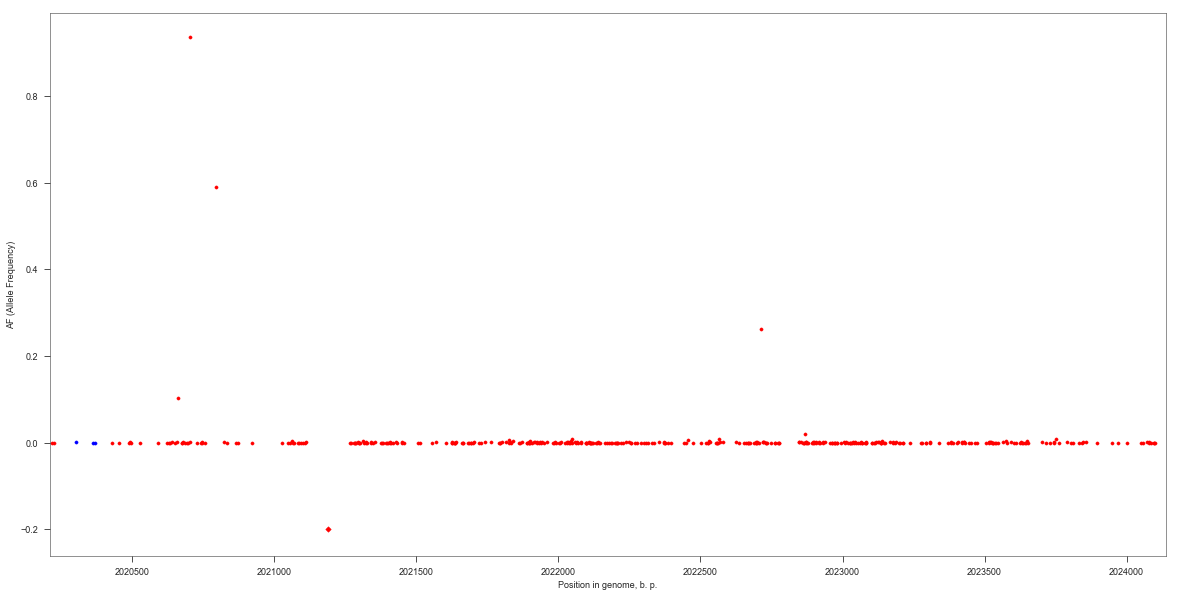

step # 39 PF3D7_1027300 start 1140589.0 end 1142602.0 peroxiredoxin (nPrx) Gene name nPrx Conservation score 1.188295165


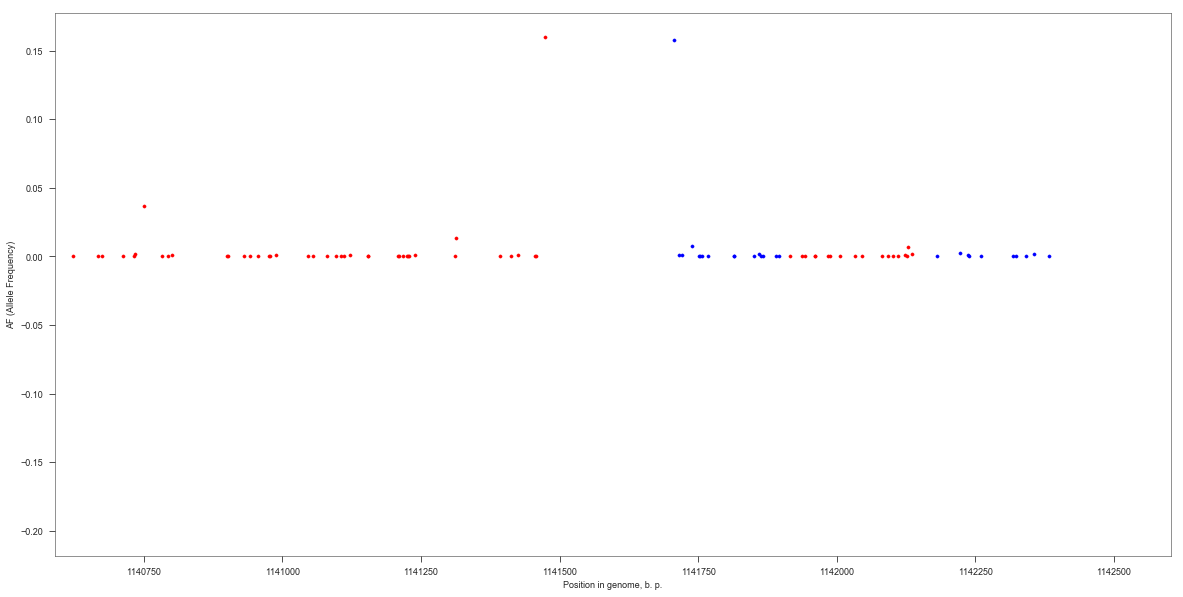

step # 40 PF3D7_0725000 start 1058933.0 end 1062976.0 "exonuclease I, putative" Gene name PF3D7_0725000 Conservation score -0.242019302


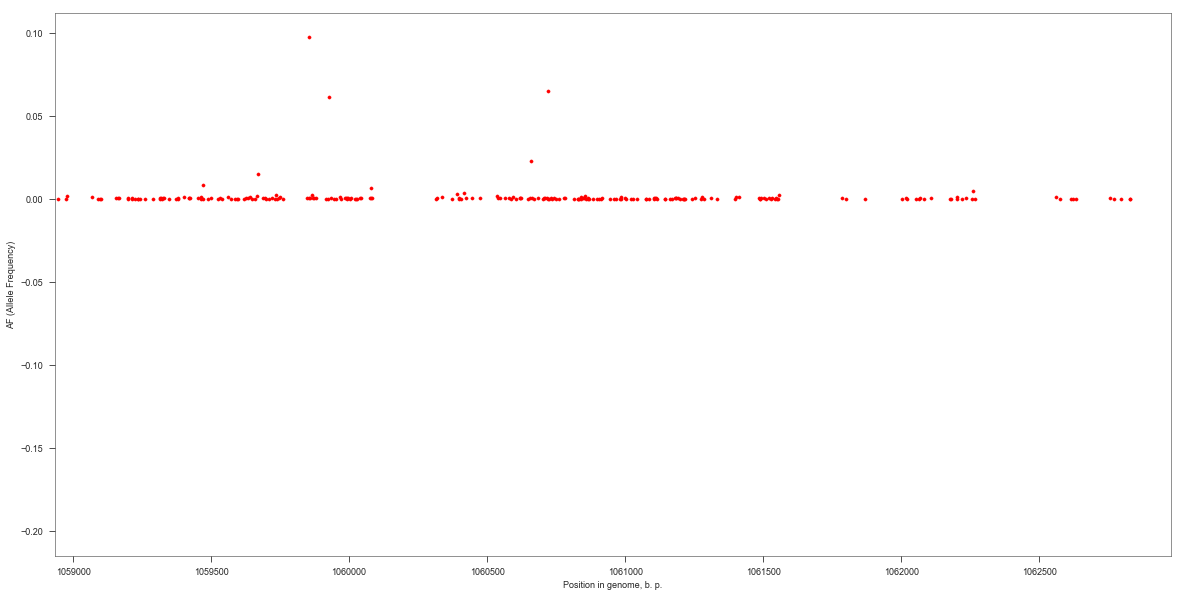

step # 41 PF3D7_0817100 start 774299.0 end 776791.0 "GTPase, putative" Gene name PF3D7_0817100 Conservation score 1.030120482


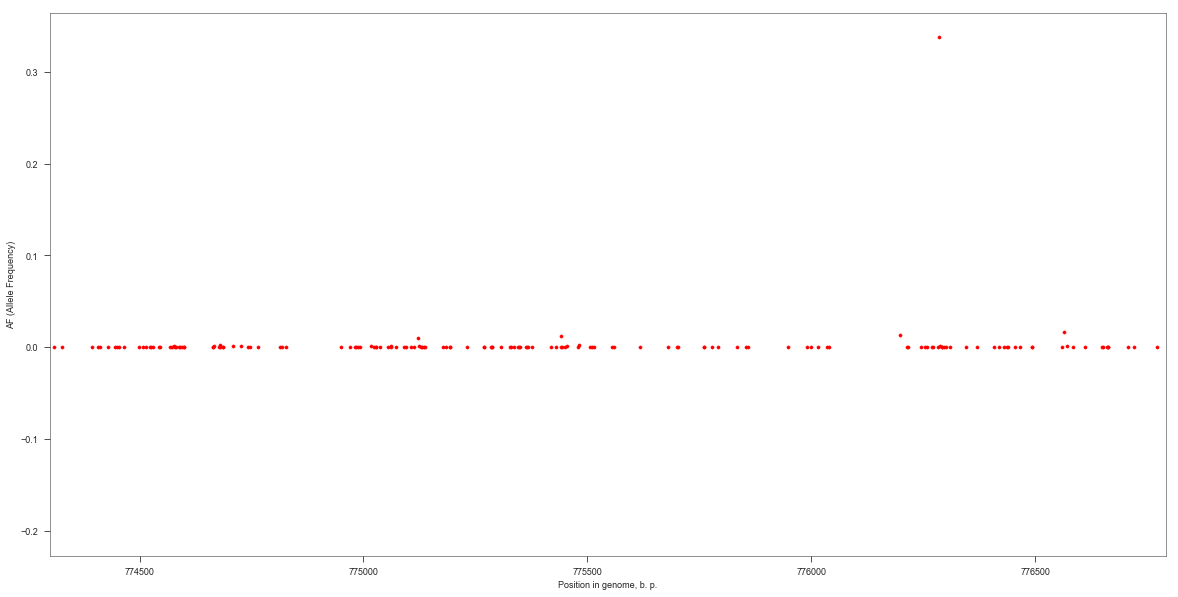

step # 42 PF3D7_0420200 start 910187.0 end 911971.0 "holo-[acyl-carrier-protein] synthase, putative (ACPS)" Gene name ACPS Conservation score 1.151515152


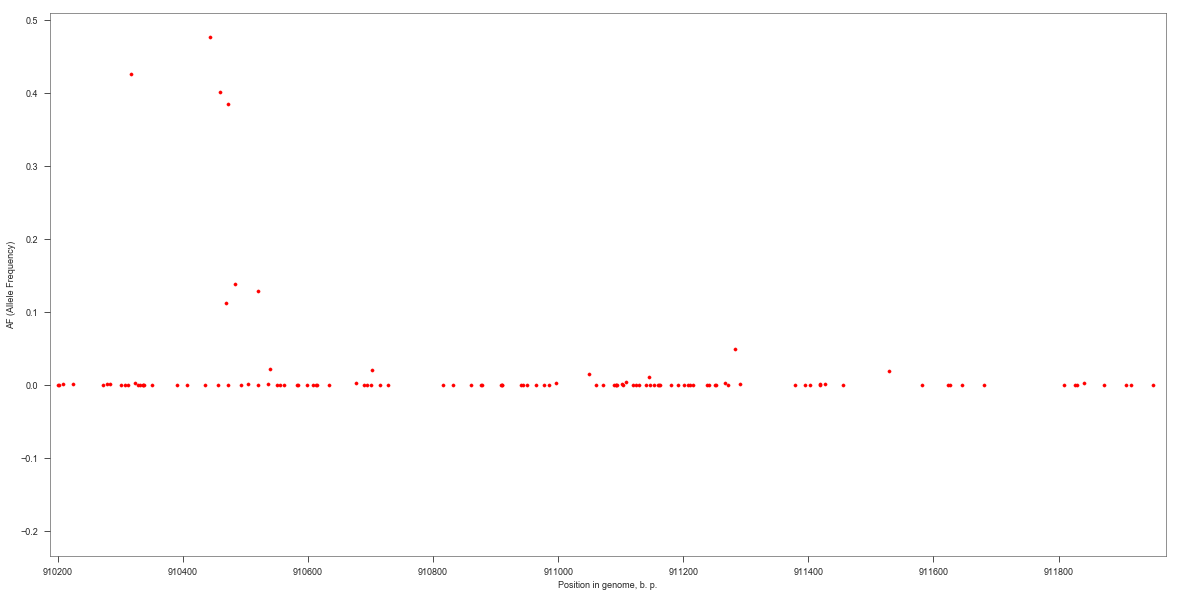

step # 43 PF3D7_0823300 start 1028752.0 end 1033514.0 histone acetyltransferase GCN5 (GCN5) Gene name GCN5 Conservation score 1.071672355


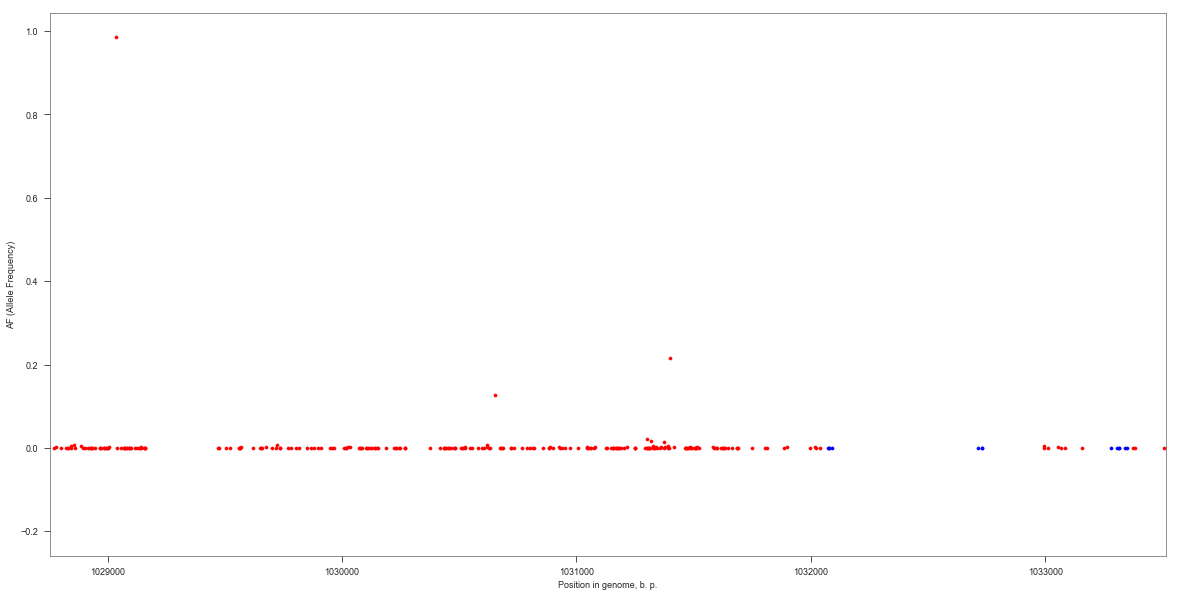

step # 44 PF3D7_1147500 start 1889826.0 end 1892597.0 farnesyltransferase+beta+subunit%2C+putative Gene name PF3D7_1147500 Conservation score 1.616468039


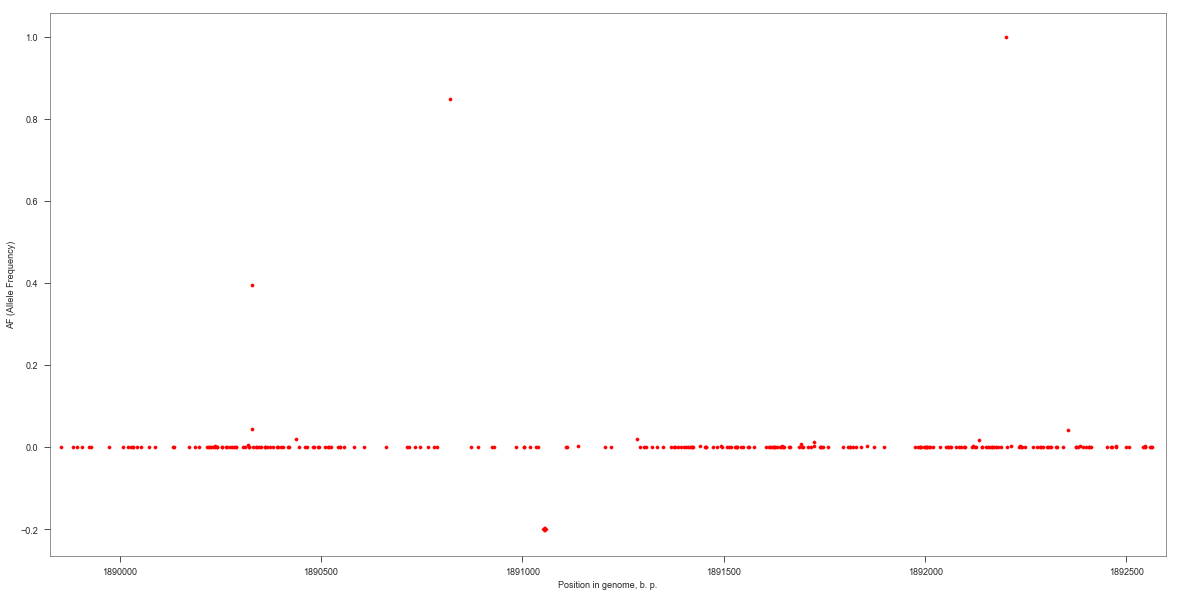

step # 45 PF3D7_1114900 start 562017.0 end 569459.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_1114900 Conservation score 0.931854839


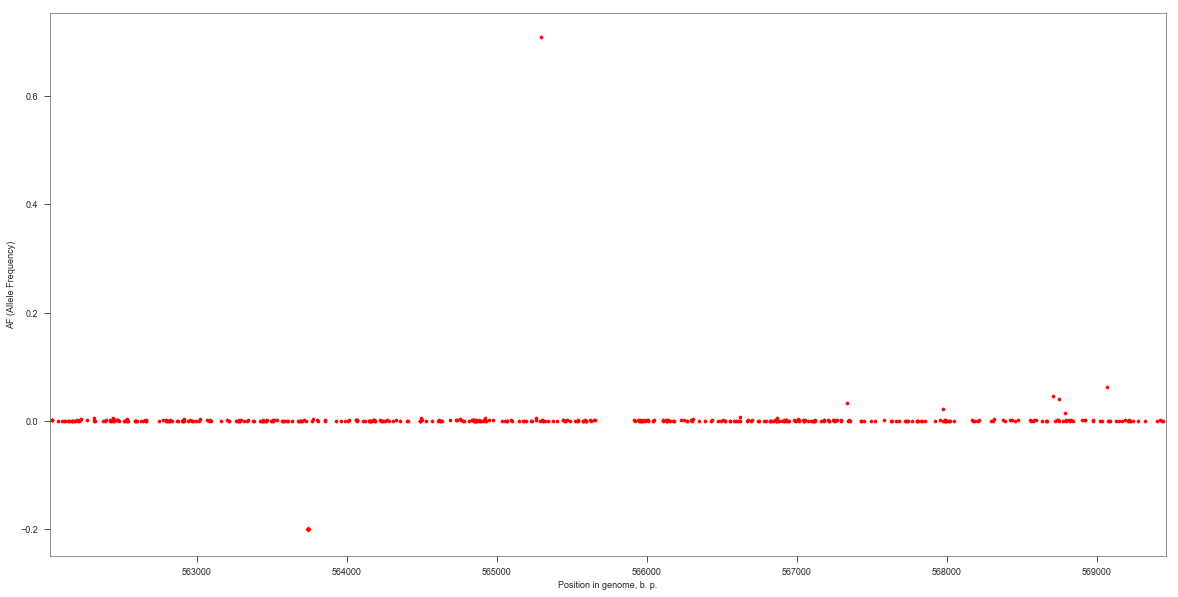

step # 46 PF3D7_1125100 start 986630.0 end 988120.0 vacuolar+membrane+protein-related%2C+putative Gene name PF3D7_1125100 Conservation score 3.149193548


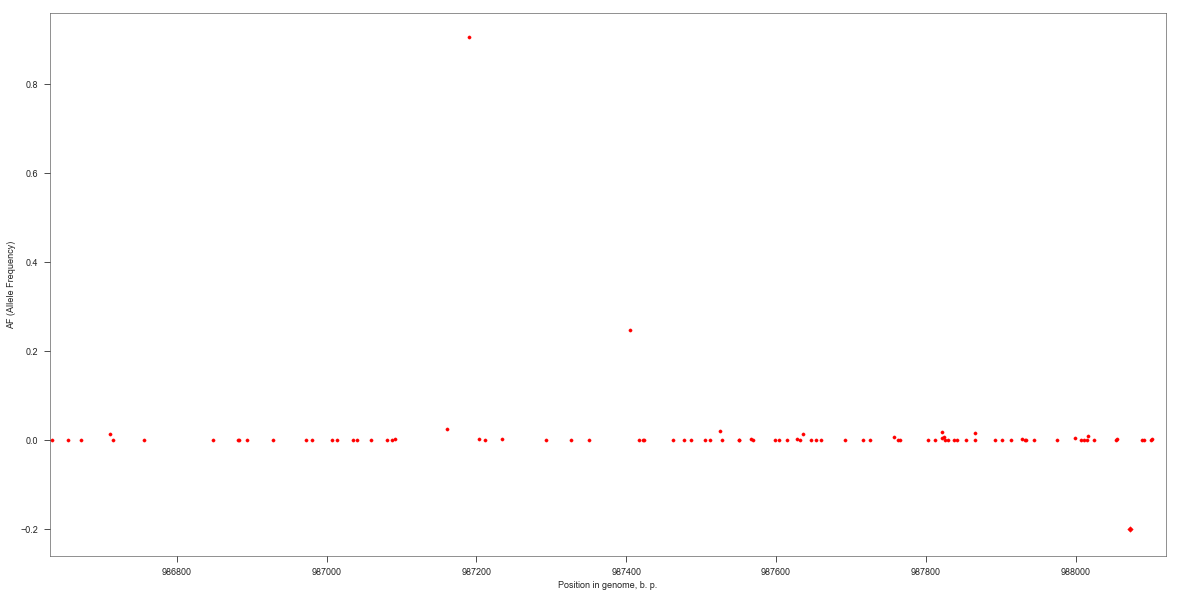

step # 47 PF3D7_1009600 start 386976.0 end 388442.0 "protein phosphatase, putative" Gene name PF3D7_1009600 Conservation score nan


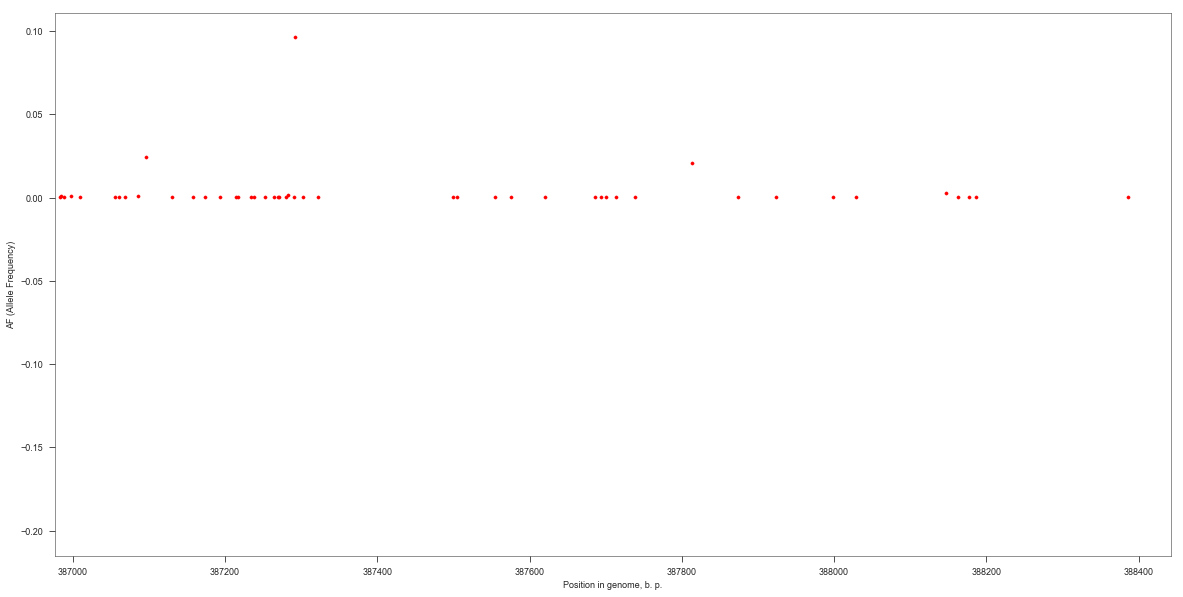

step # 48 PF3D7_1227400 start 1109151.0 end 1112669.0 "conserved Plasmodium protein, unknown function" Gene name PF3D7_1227400 Conservation score nan


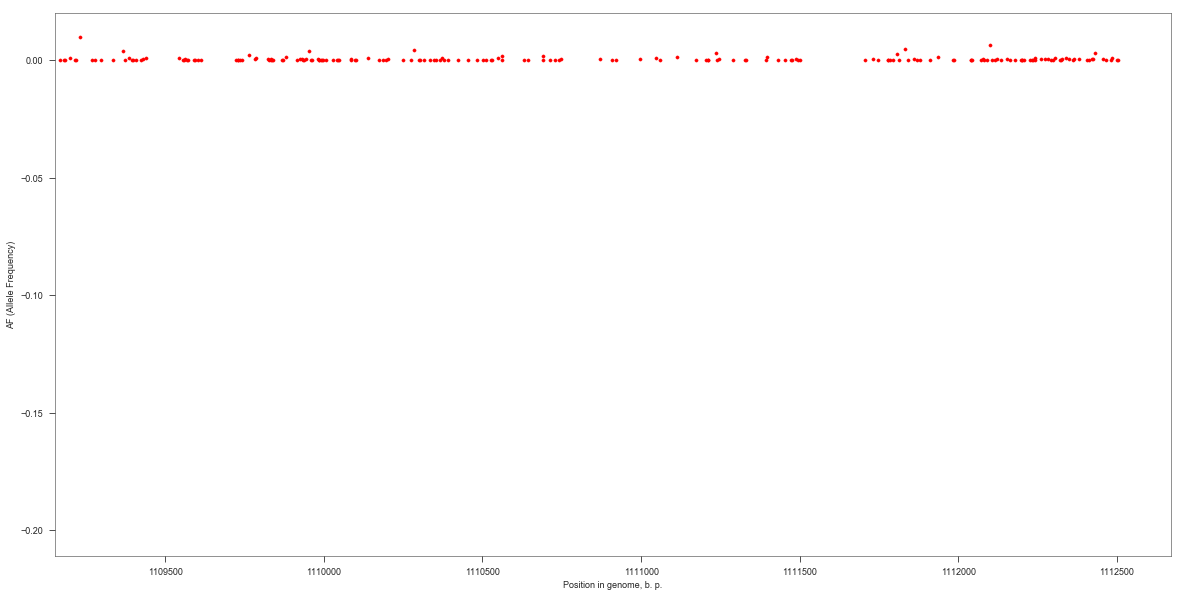

step # 49 PF3D7_0419500 start 866501.0 end 868111.0 "conserved Plasmodium membrane protein, unknown function" Gene name PF3D7_0419500 Conservation score 0.884328358


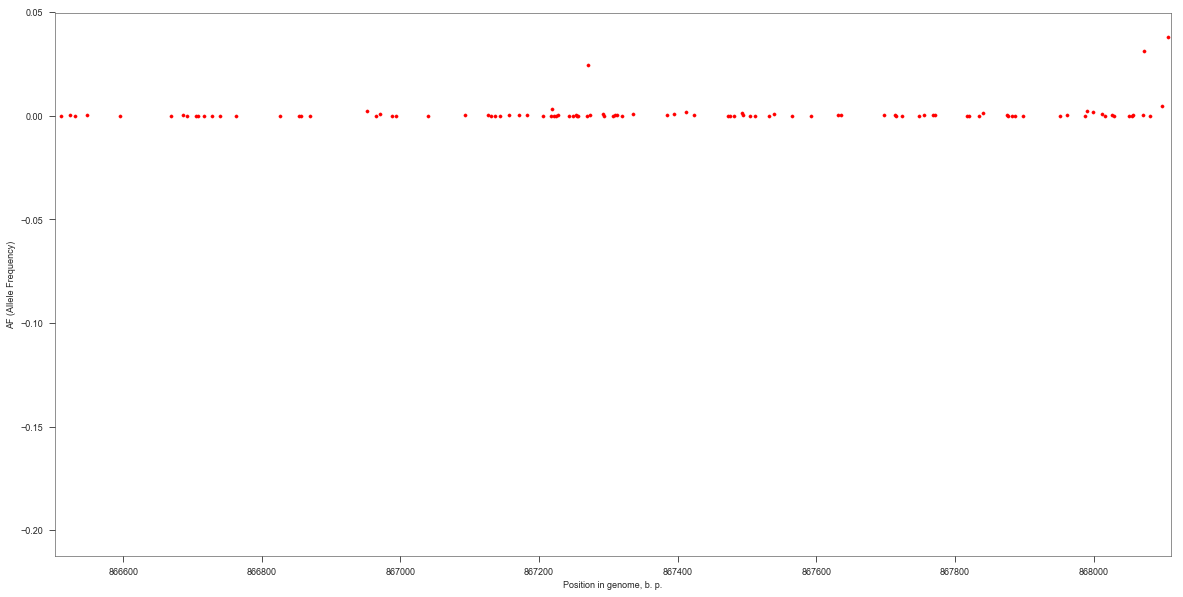

step # 50 PF3D7_0523800 start 990005.0 end 992059.0 "transporter, putative" Gene name PF3D7_0523800 Conservation score 2.099415205


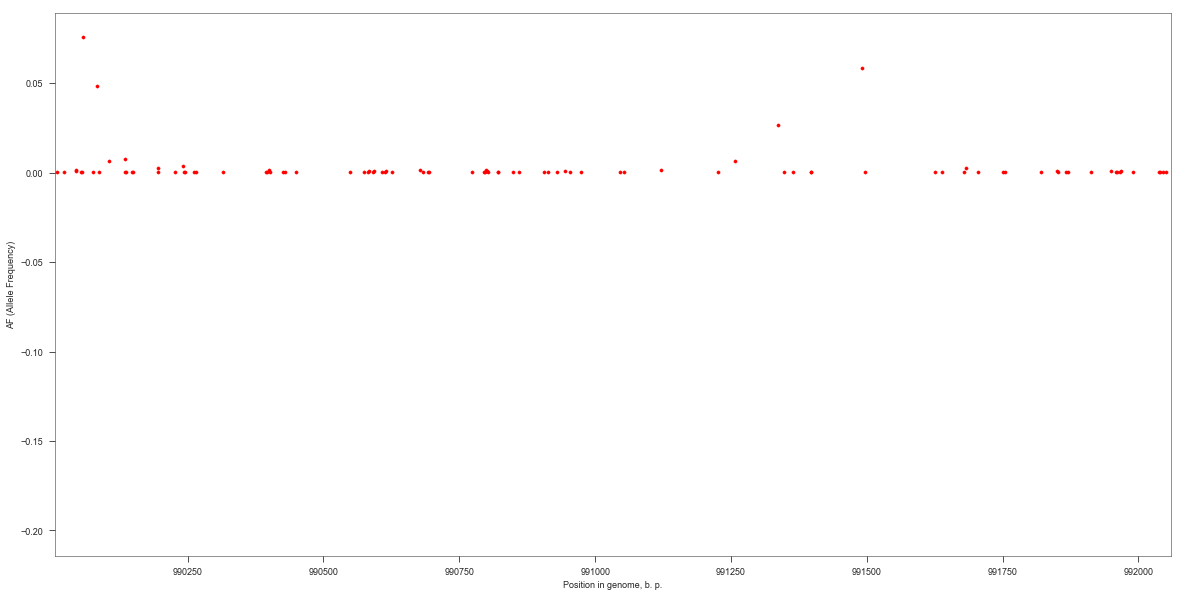

step # 51 PF3D7_0920400 start 833754.0 end 839312.0 "conserved Plasmodium protein, unknown function" Gene name PF3D7_0920400 Conservation score -0.269978402


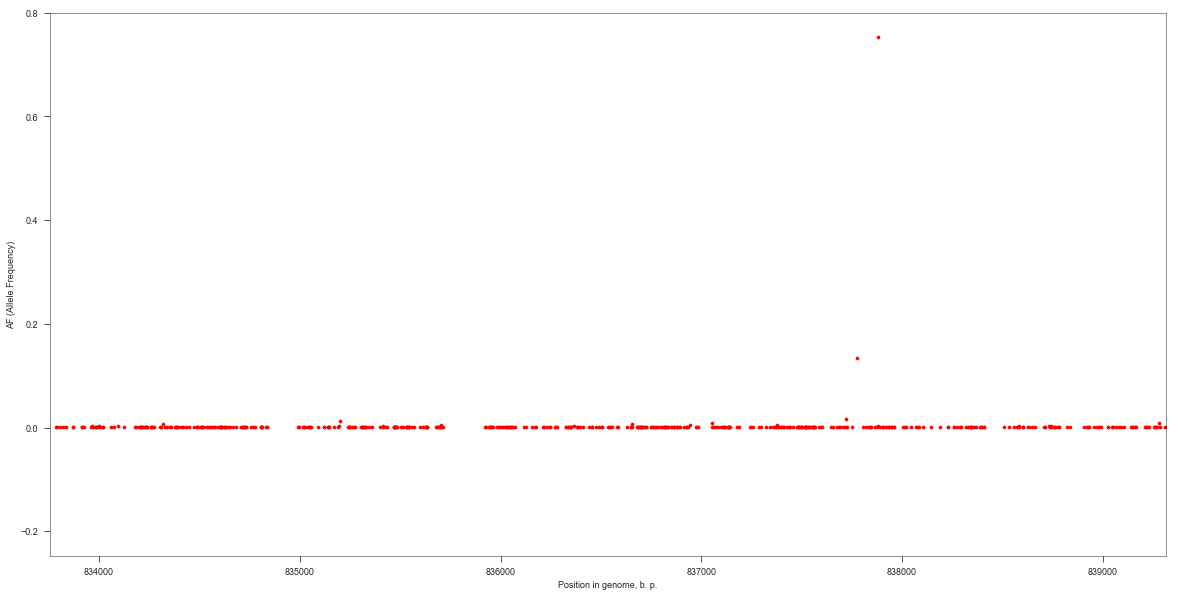

step # 52 PF3D7_1322500 start 953154.0 end 955789.0 palmitoyltransferase%2C+putative+%28DHHC5%29 Gene name DHHC5 Conservation score 2.581360947


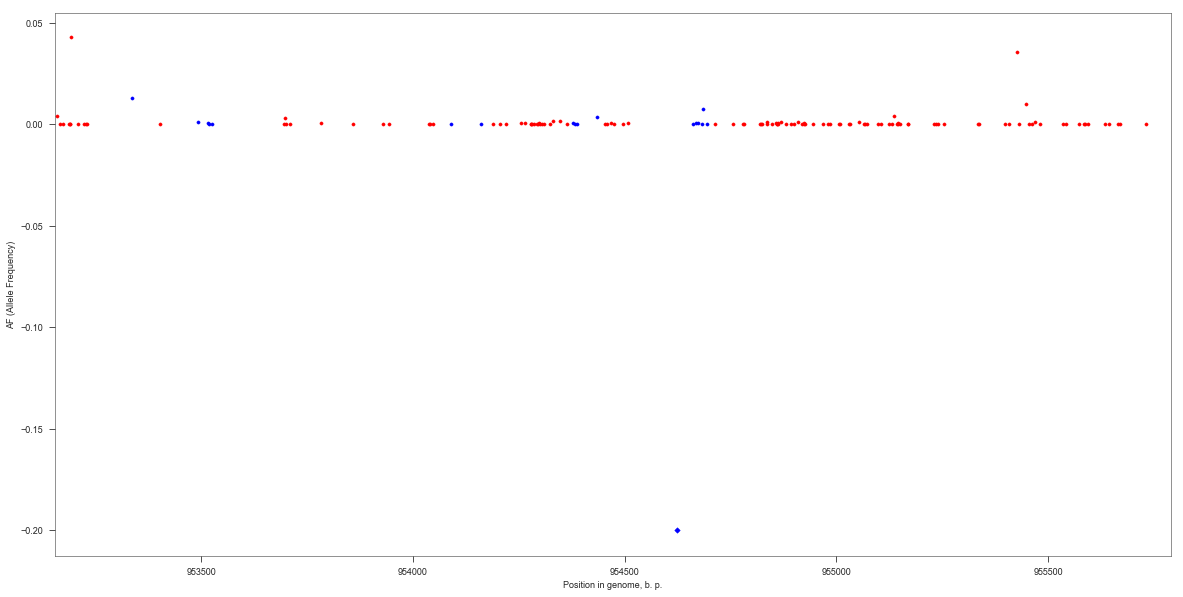

step # 53 PF3D7_1452400 start 2148421.0 end 2151123.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_1452400 Conservation score -0.164444444


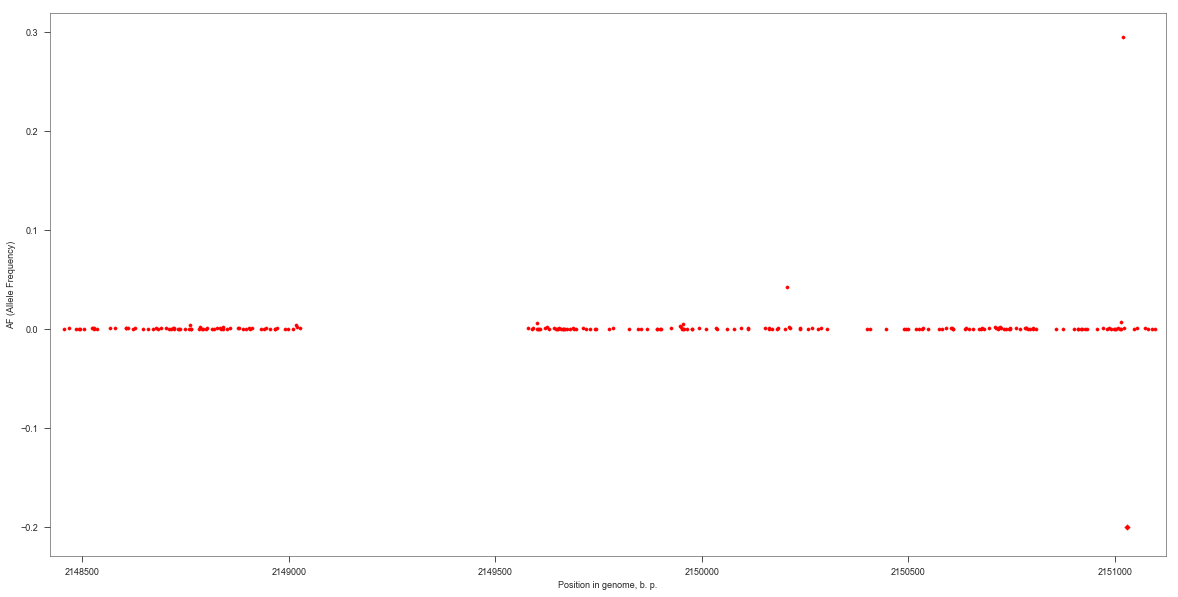

step # 54 PF3D7_0603000 start 122634.0 end 124412.0 "conserved Plasmodium protein, unknown function" Gene name PF3D7_0603000 Conservation score 0.391891892


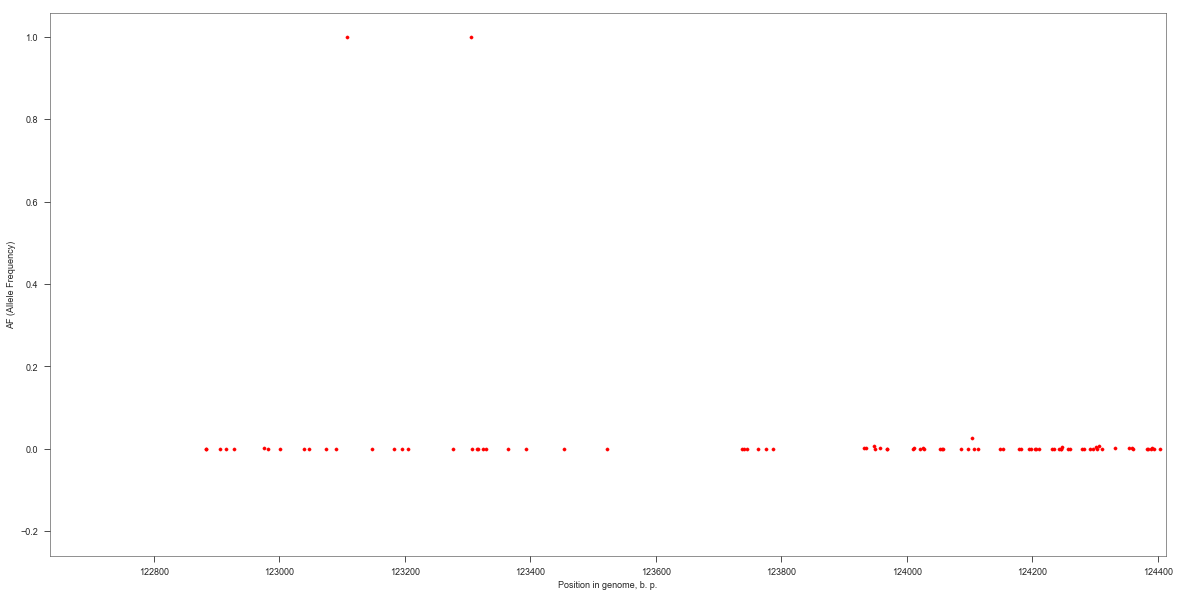

step # 55 PF3D7_0105700 start 238666.0 end 247857.0 asparagine-rich+antigen+Pfa35-2 Gene name PF3D7_0105700 Conservation score nan


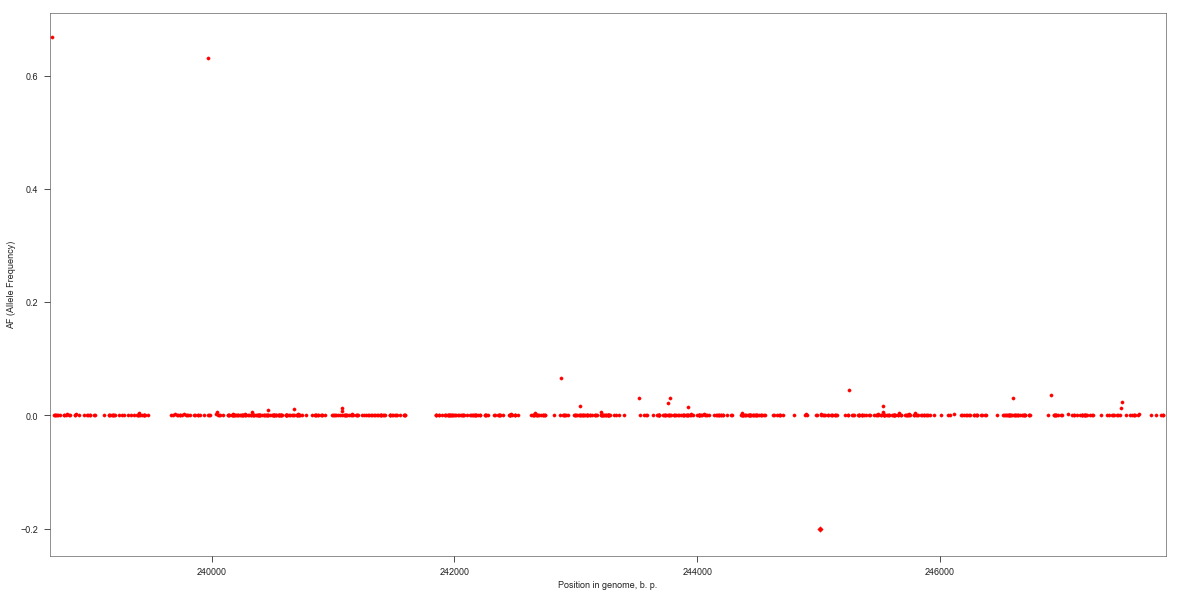

step # 56 PF3D7_0322600 start 948374.0 end 952693.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_0322600 Conservation score 0.956198961


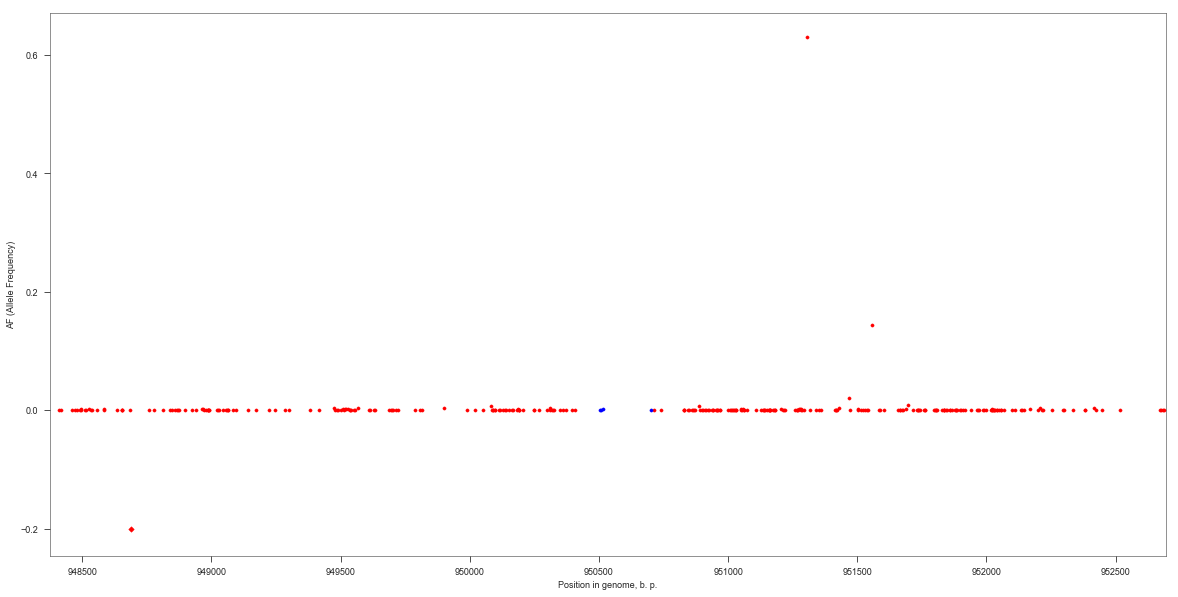

step # 57 PF3D7_0319700 start 820708.0 end 830802.0 ABC+transporter%2C+putative Gene name ABCI3 Conservation score 1.090647941


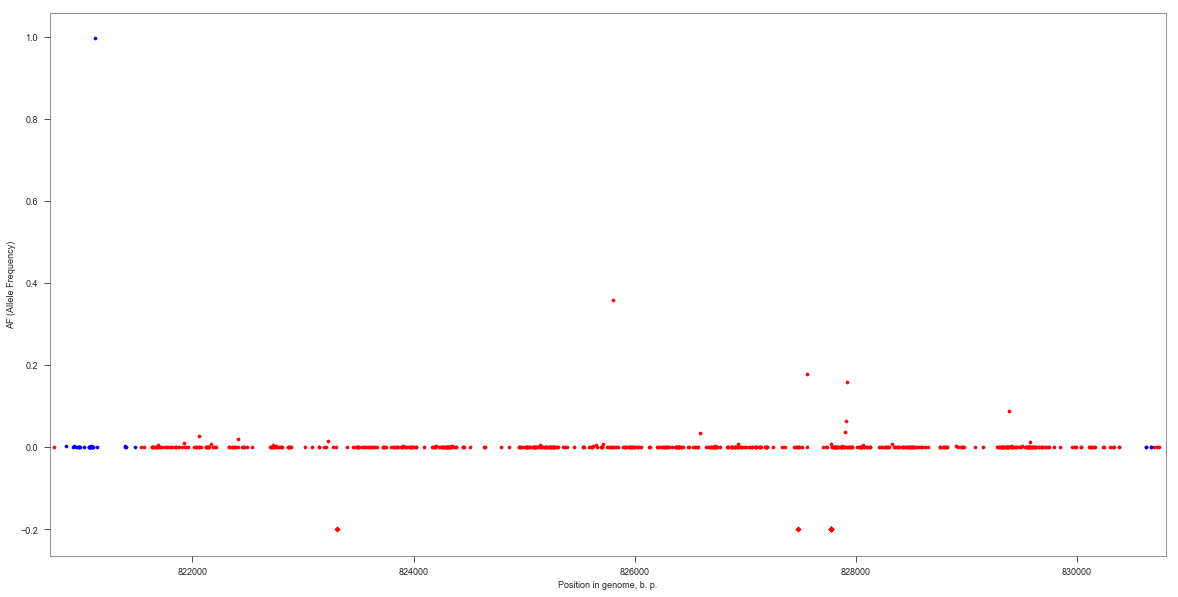

step # 58 PF3D7_1321100 start 861442.0 end 872332.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_1321100 Conservation score -1.117203365


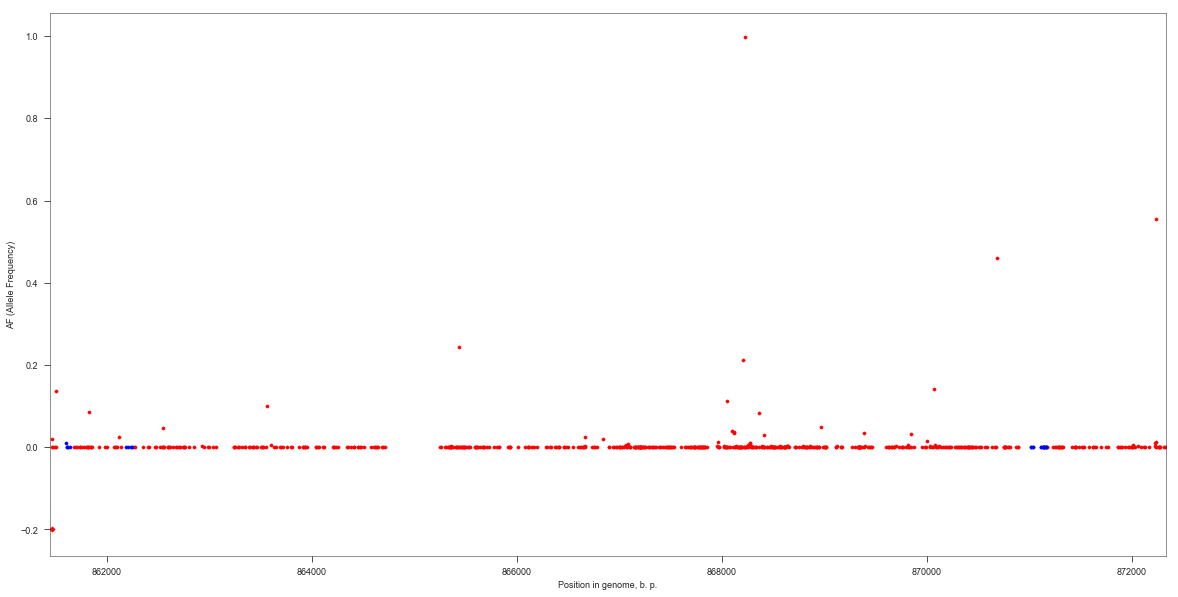

step # 59 PF3D7_1455800 start 2285113.0 end 2290227.0 LCCL+domain-containing+protein+%28CCp2%29 Gene name CCp2 Conservation score 3.242424242


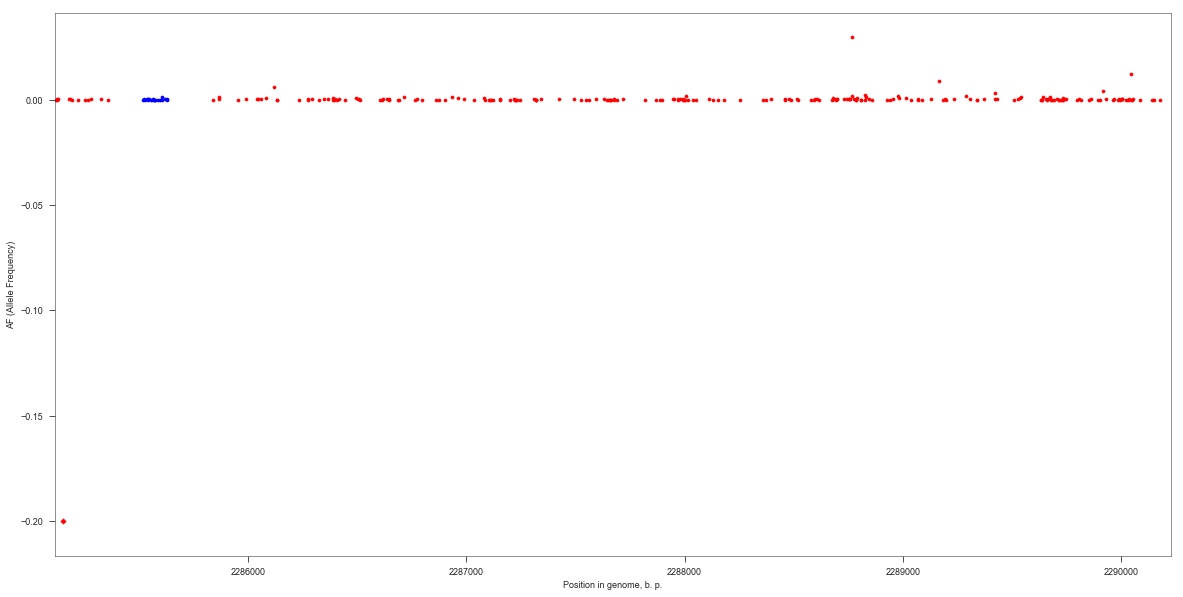

step # 60 PF3D7_0909900 start 447928.0 end 452049.0 helicase+with+Zn-finger+motif%2C+putative Gene name PF3D7_0909900 Conservation score 3.112163146


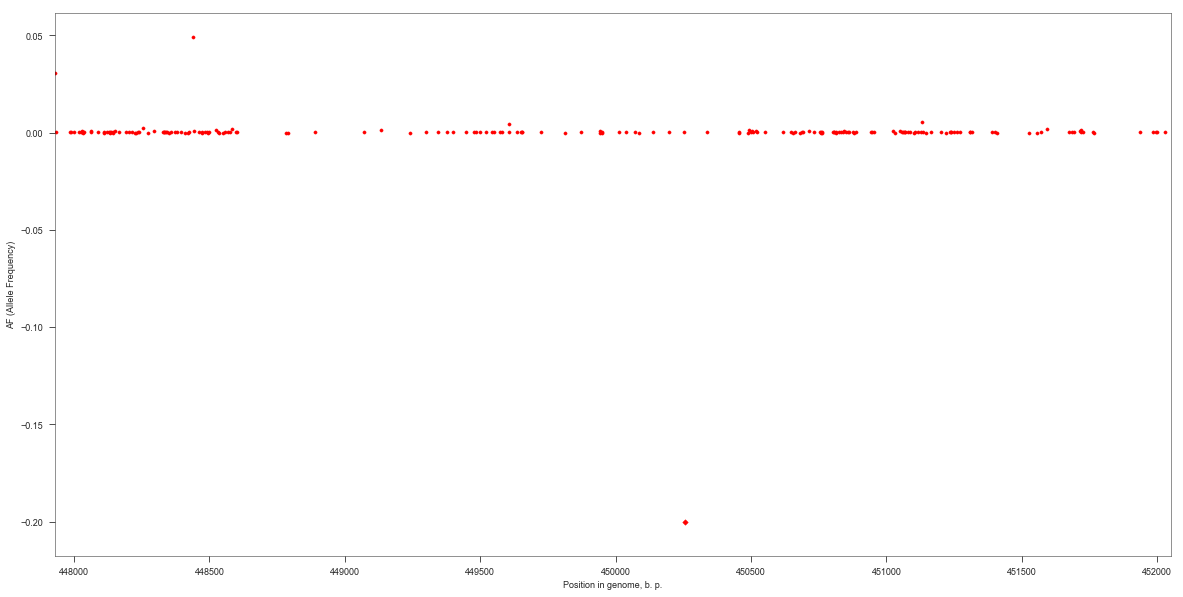

step # 61 PF3D7_0826900 start 1164655.0 end 1167205.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_0826900 Conservation score 0.018617021


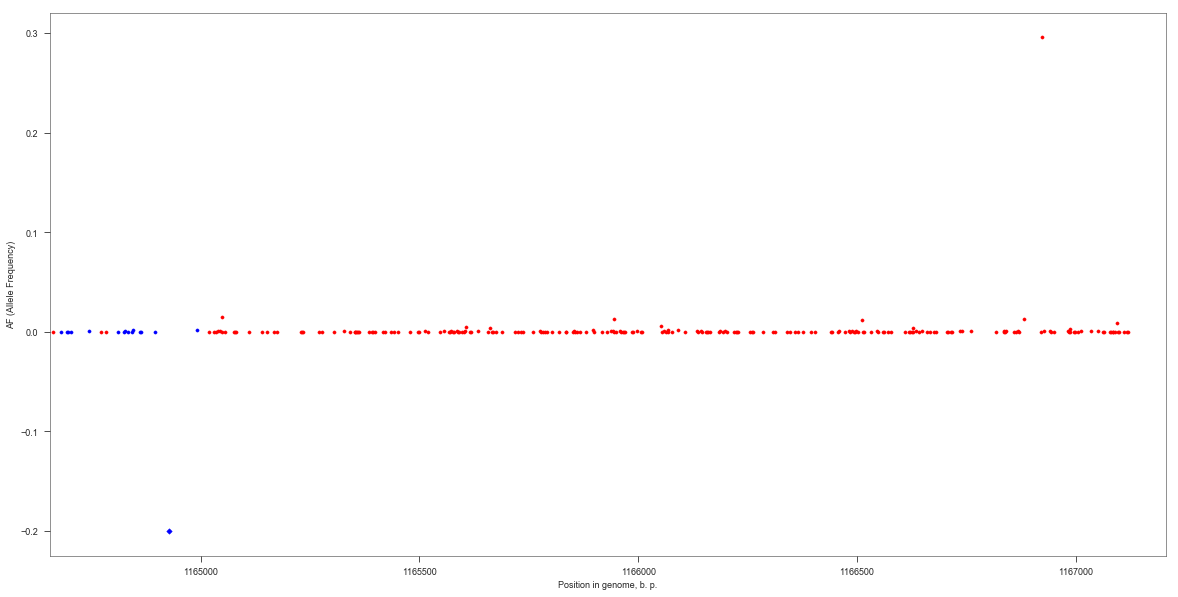

step # 62 PF3D7_1356800 start 2249587.0 end 2261721.0 serine%2Fthreonine+protein+kinase%2C+putative+%28ARK3%29 Gene name ARK3 Conservation score -0.323194857


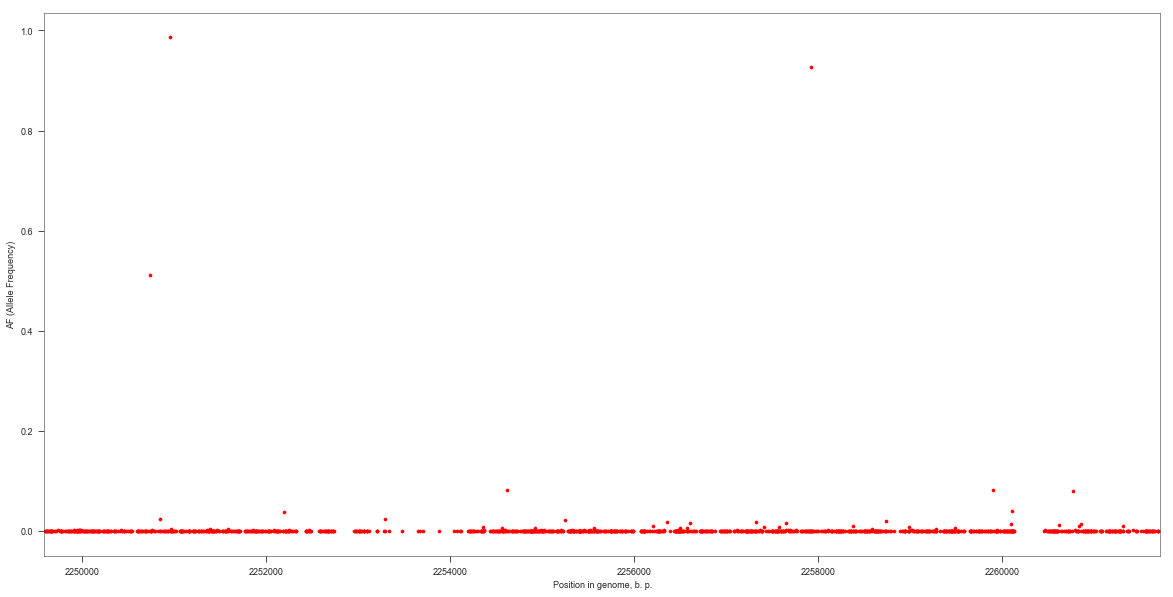

step # 63 PF3D7_0405100 start 272255.0 end 276824.0 Sec24+subunit+b+%28SEC24b%29 Gene name SEC24B Conservation score 2.32962963


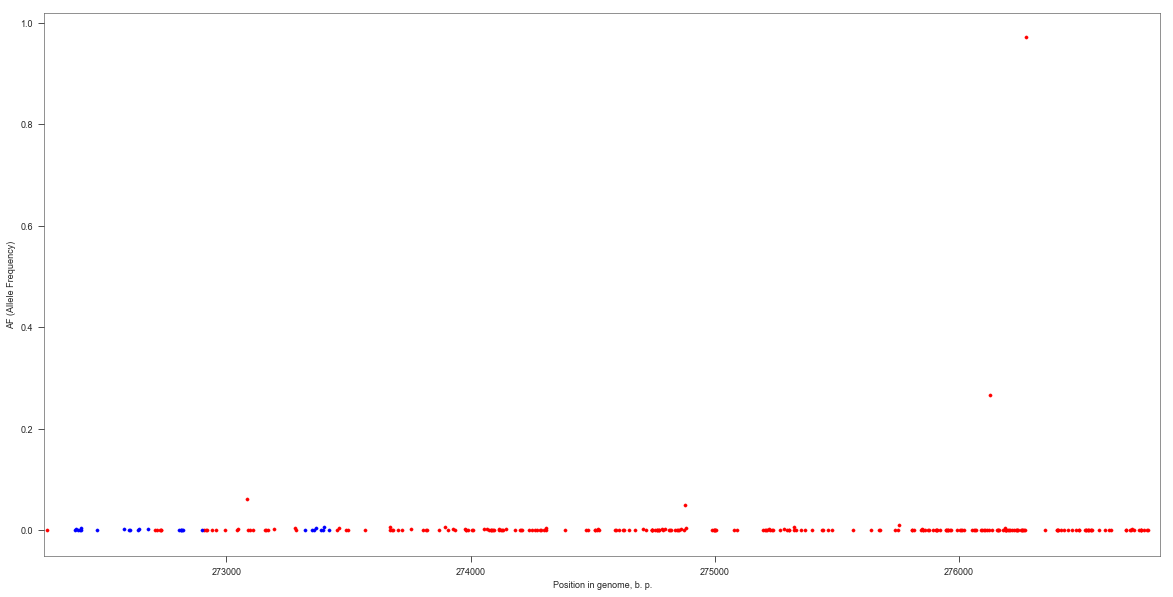

step # 64 PF3D7_1248700 start 1994775.0 end 2000744.0 "conserved Plasmodium protein, unknown function" Gene name PF3D7_1248700 Conservation score -0.015082956


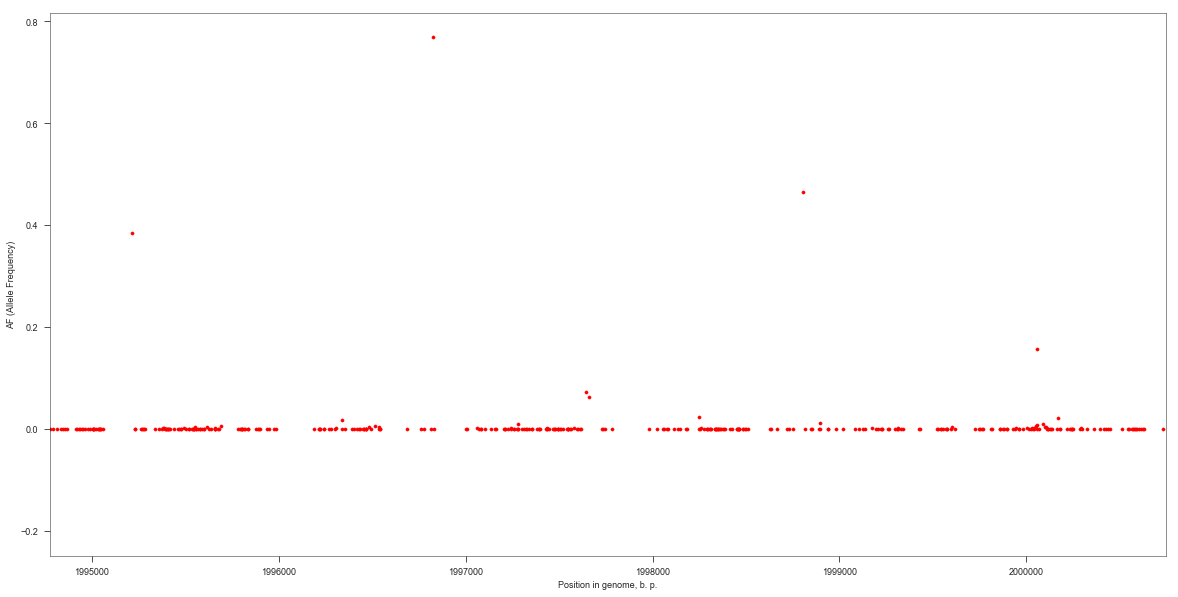

step # 65 PF3D7_0727900 start 1184401.0 end 1190172.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_0727900 Conservation score 0.768590744


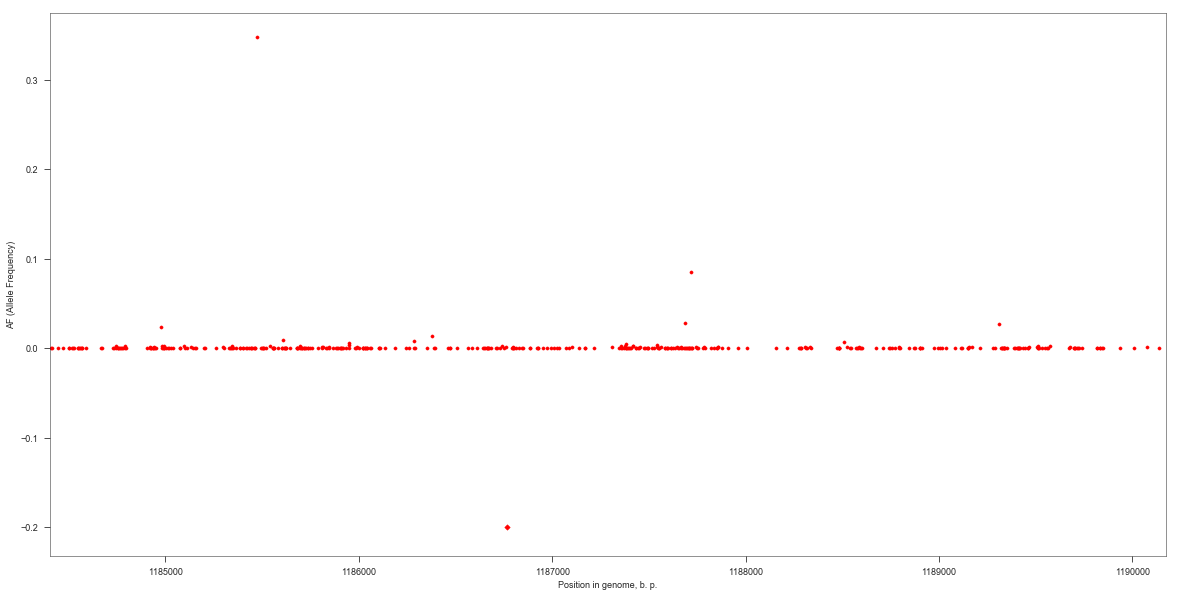

step # 66 PF3D7_0930300 start 1201812.0 end 1206974.0 merozoite surface protein 1 (MSP1) Gene name MSP1 Conservation score 0.921511628


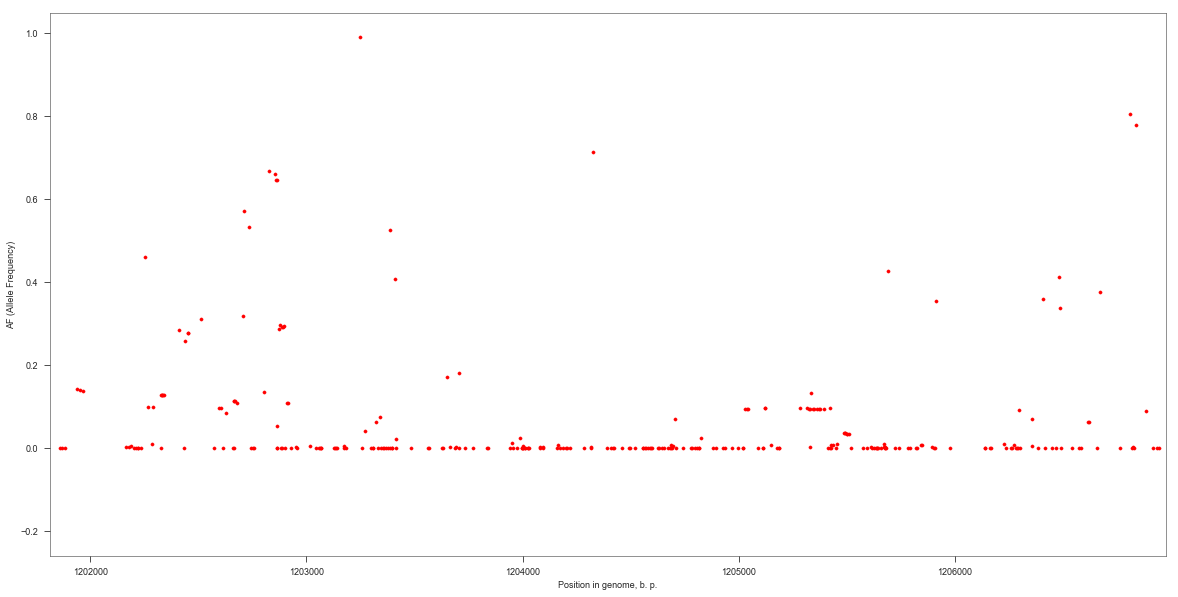

step # 67 PF3D7_0519900 start 825835.0 end 827412.0 "conserved Plasmodium protein, unknown function" Gene name PF3D7_0519900 Conservation score 0.39047619


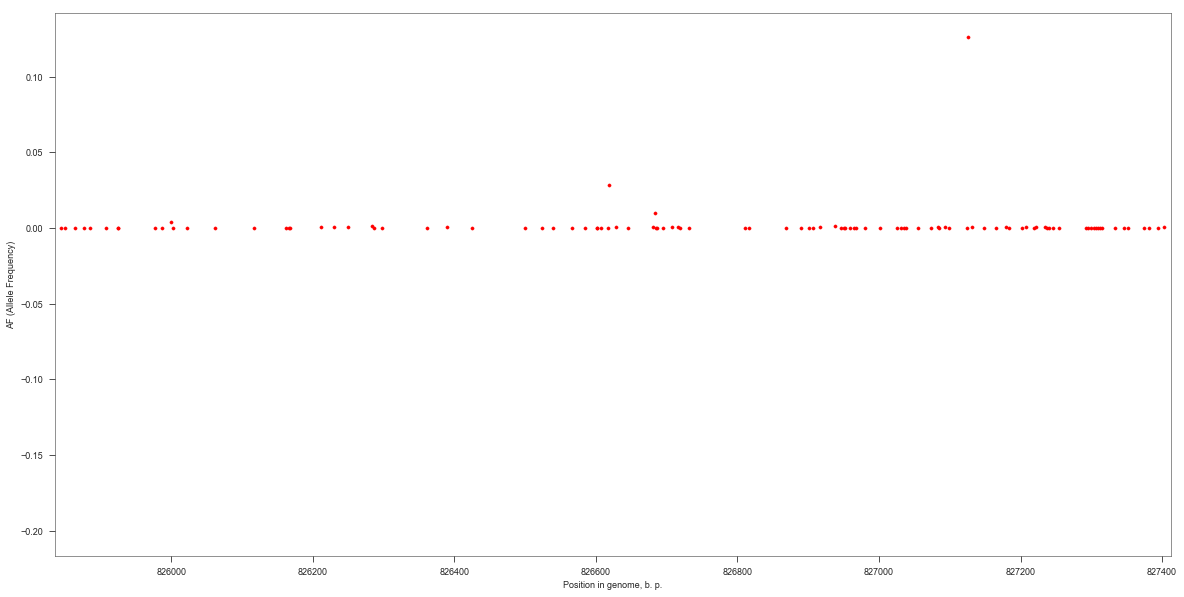

step # 68 PF3D7_0417200 start 748088.0 end 749914.0 bifunctional+dihydrofolate+reductase-thymidylate+synthase+%28DHFR-TS%29 Gene name DHFR-TS Conservation score 3.378289474


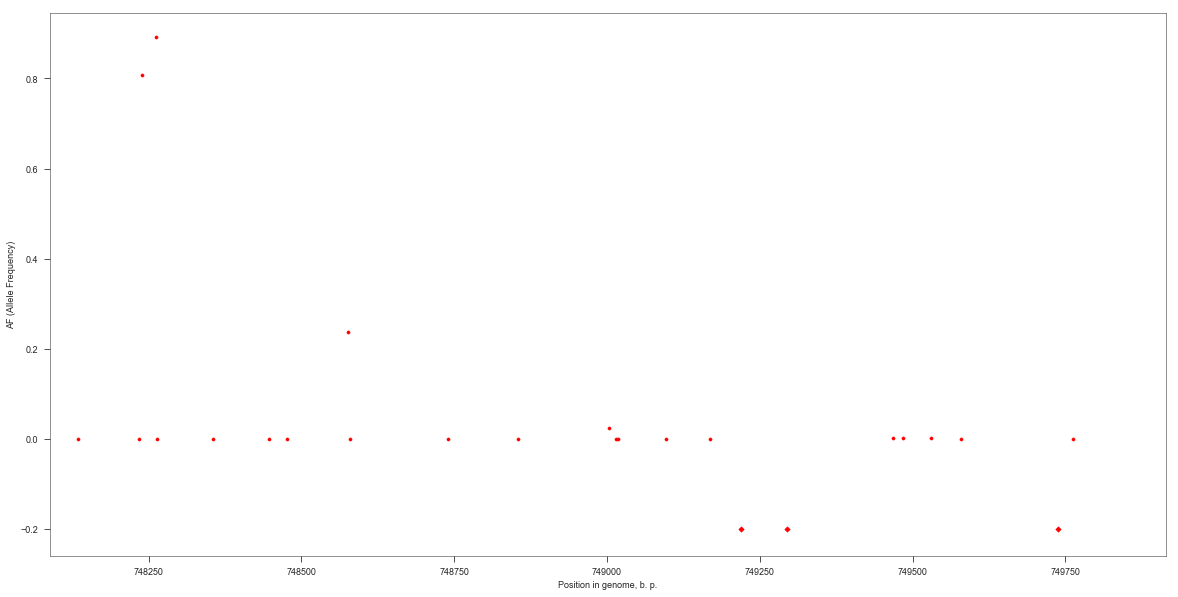

step # 69 PF3D7_1342900 start 1682393.0 end 1693969.0 transcription factor with AP2 domain(s) (ApiAP2) Gene name ApiAP2 Conservation score 0.146967341


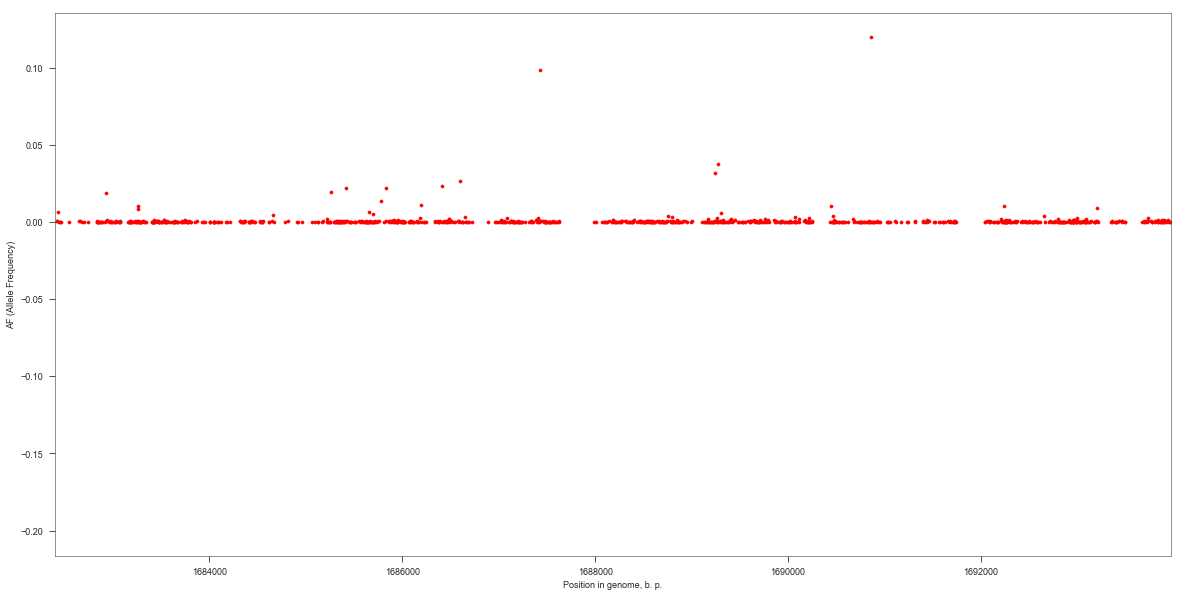

step # 70 PF3D7_1212500 start 552102.0 end 553853.0 glycerol-3-phosphate+acyltransferase+%28GAT%29 Gene name GAT Conservation score 4.154373928


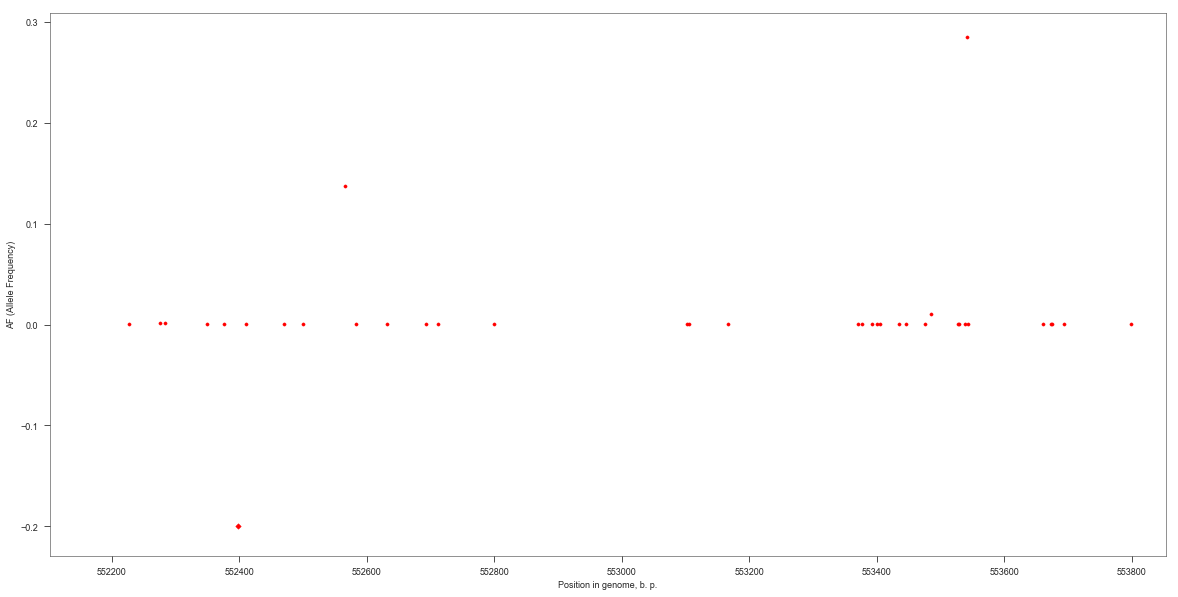

step # 71 PF3D7_0214600 start 594196.0 end 599340.0 serine%2Fthreonine+protein+kinase%2C+putative Gene name PF3D7_0214600 Conservation score -0.17327888


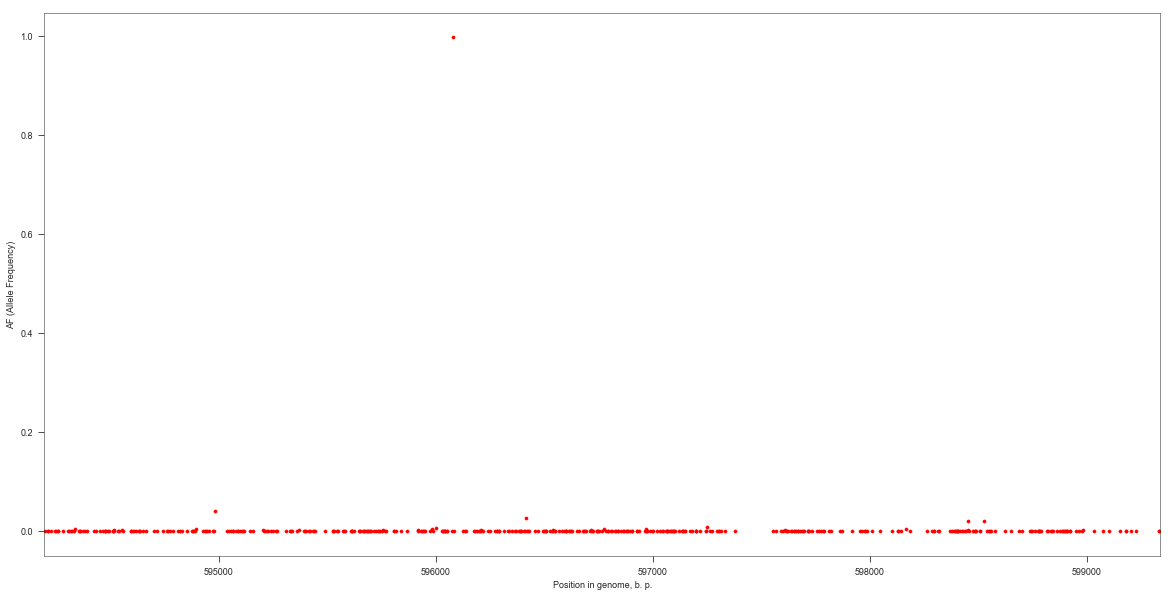

step # 72 PF3D7_0628100 start 1122801.0 end 1153664.0 "HECT-domain (ubiquitin-transferase), putative" Gene name PF3D7_0628100 Conservation score 1.090891416


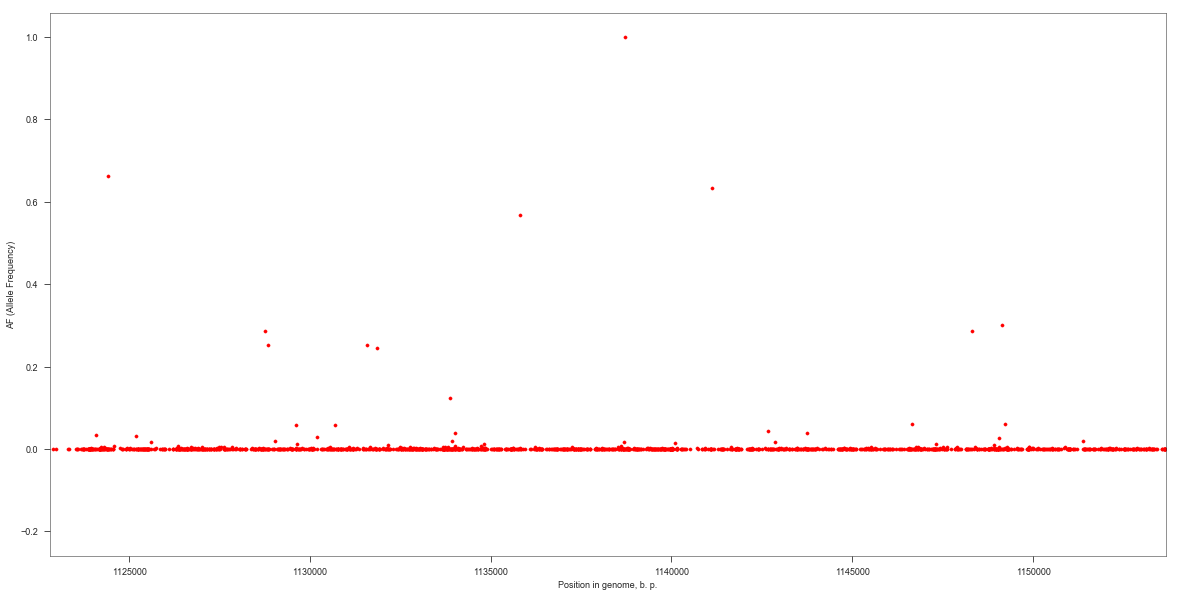

step # 73 PF3D7_0709000 start 403222.0 end 406317.0 chloroquine+resistance+transporter+%28CRT%29 Gene name CRT Conservation score 3.125


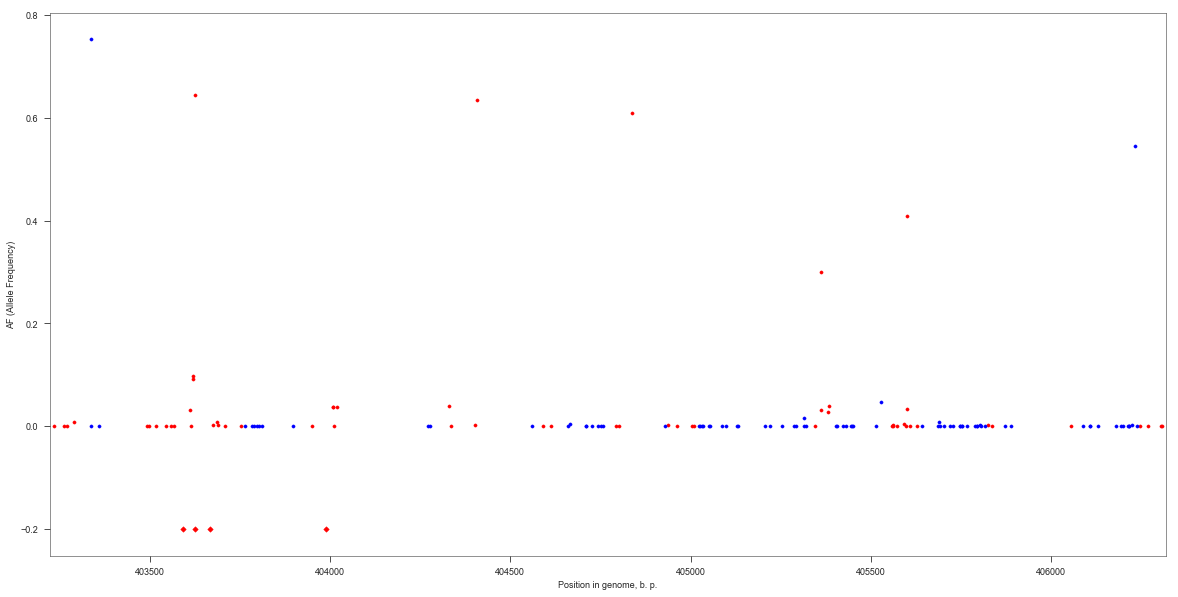

step # 74 PF3D7_0411900 start 528192.0 end 534485.0 DNA polymerase alpha catalytic subunit A Gene name PF3D7_0411900 Conservation score 1.925732218


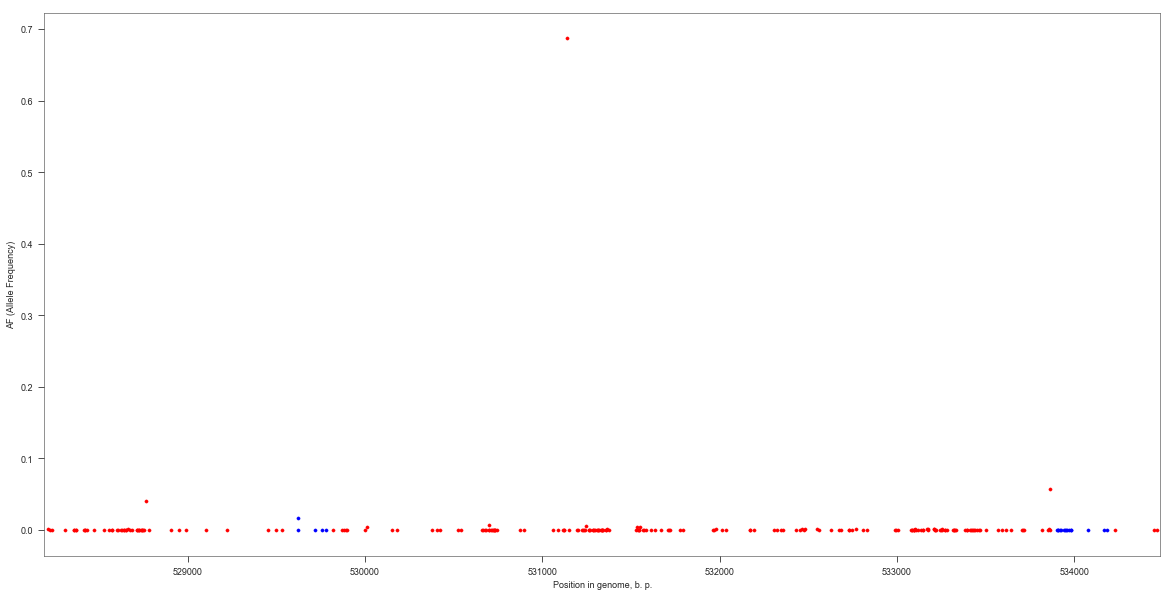

step # 75 PF3D7_0903500 start 162769.0 end 166923.0 "conserved Plasmodium protein, unknown function" Gene name PF3D7_0903500 Conservation score 0.693641618


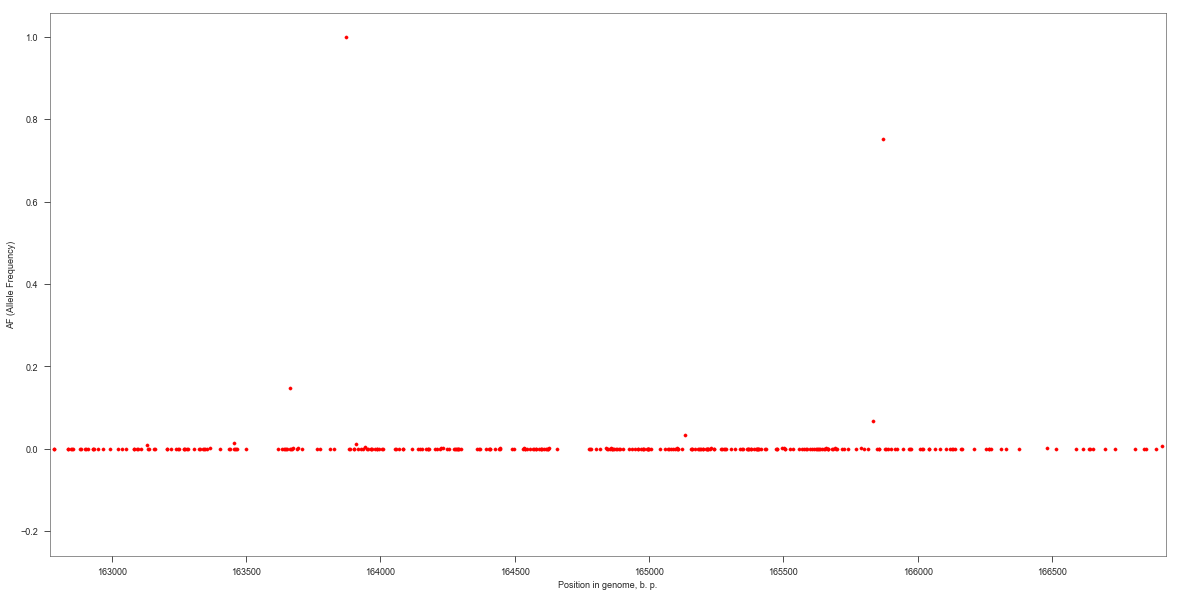

step # 76 PF3D7_0829500 start 1260048.0 end 1266698.0 "conserved Plasmodium protein, unknown function" Gene name PF3D7_0829500 Conservation score nan


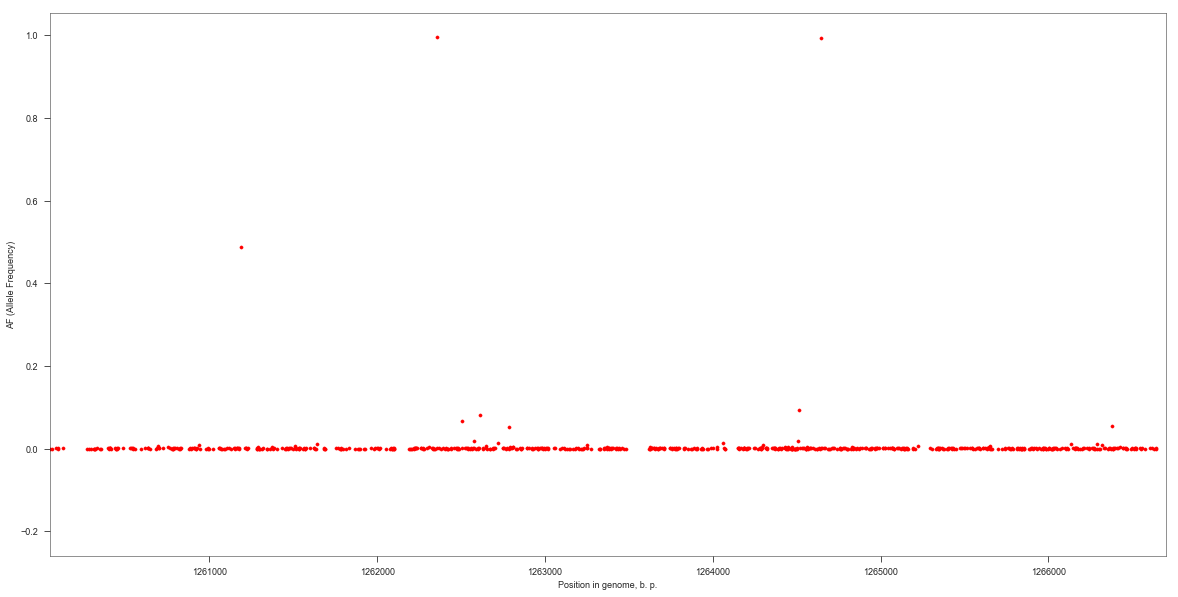

step # 77 PF3D7_0922000 start 890057.0 end 893267.0 dynein+intermediate+chain+2%2C+ciliary Gene name PF3D7_0922000 Conservation score 2.767073171


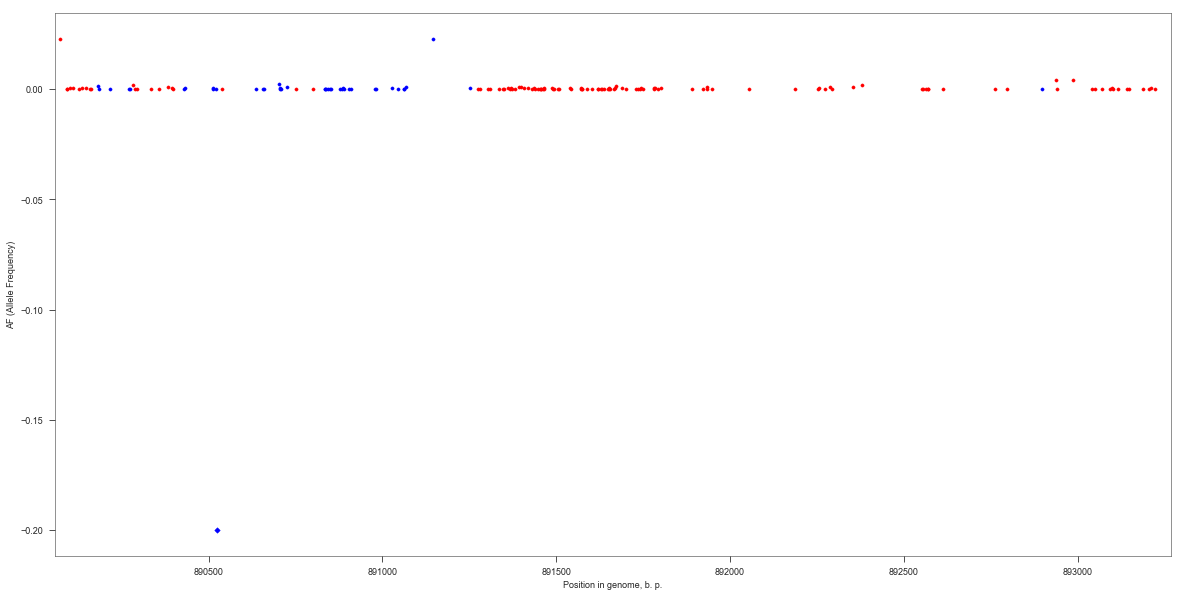

step # 78 PF3D7_0628200 start 1159862.0 end 1169080.0 protein+kinase+PK4+%28PK4%29 Gene name PK4 Conservation score 0.347005208


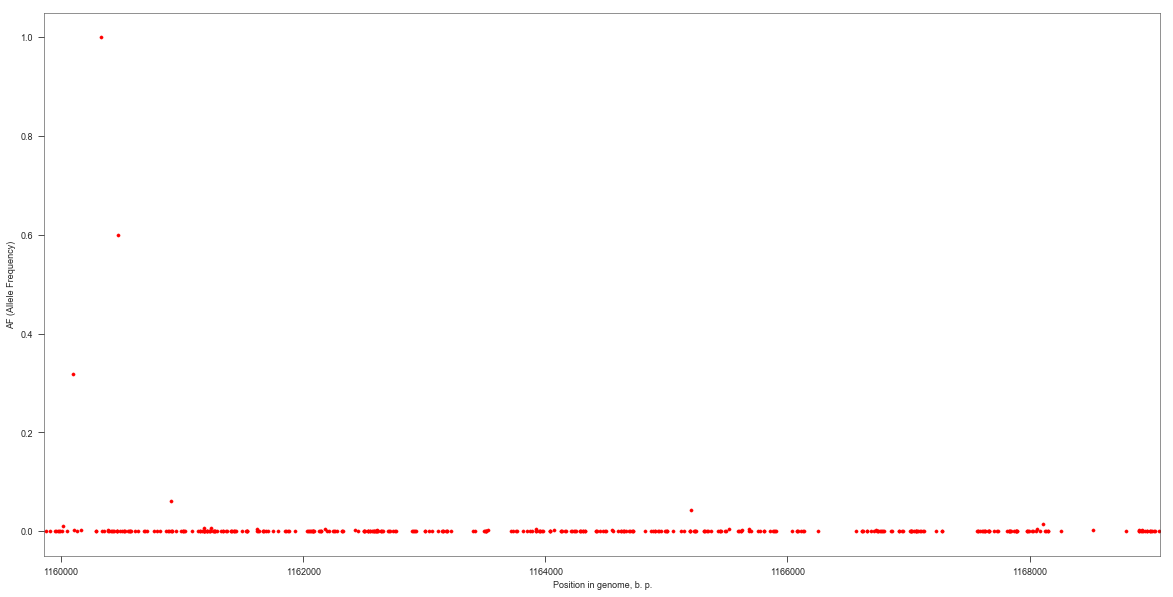

step # 79 PF3D7_0937200 start 1471851.0 end 1472924.0 "lysophospholipase, putative" Gene name PF3D7_0937200 Conservation score nan


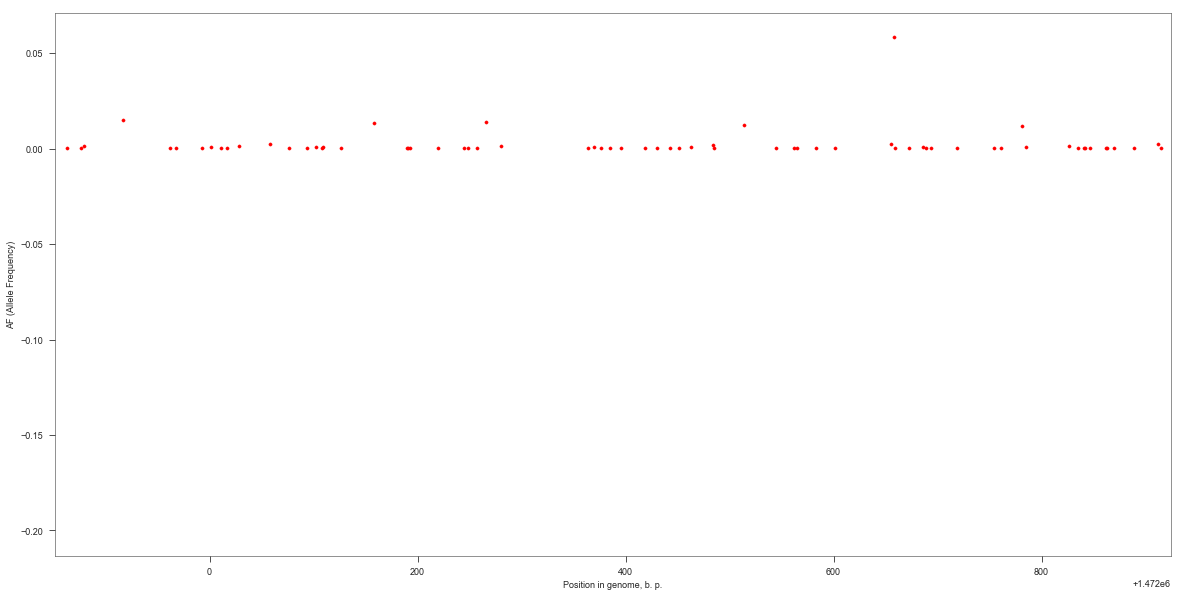

step # 80 PF3D7_1313500 start 573169.0 end 578479.0 "conserved Plasmodium membrane protein, unknown function" Gene name PF3D7_1313500 Conservation score 0.893494531


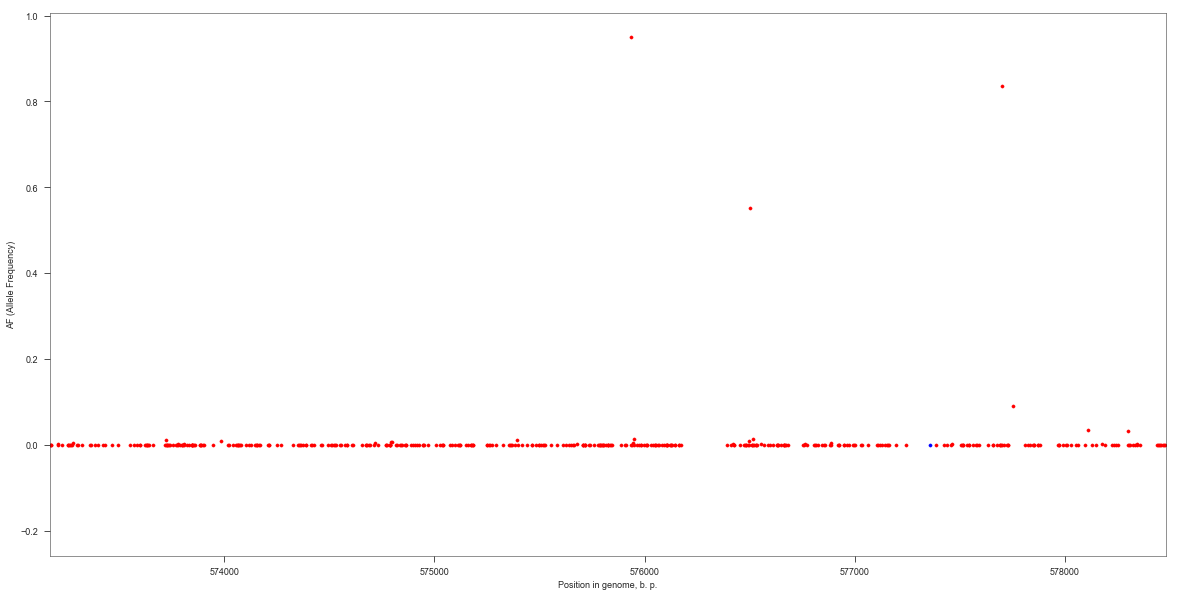

step # 81 PF3D7_0929400 start 1175203.0 end 1180762.0 high+molecular+weight+rhoptry+protein+2+%28RhopH2%29 Gene name RhopH2 Conservation score 1.714804064


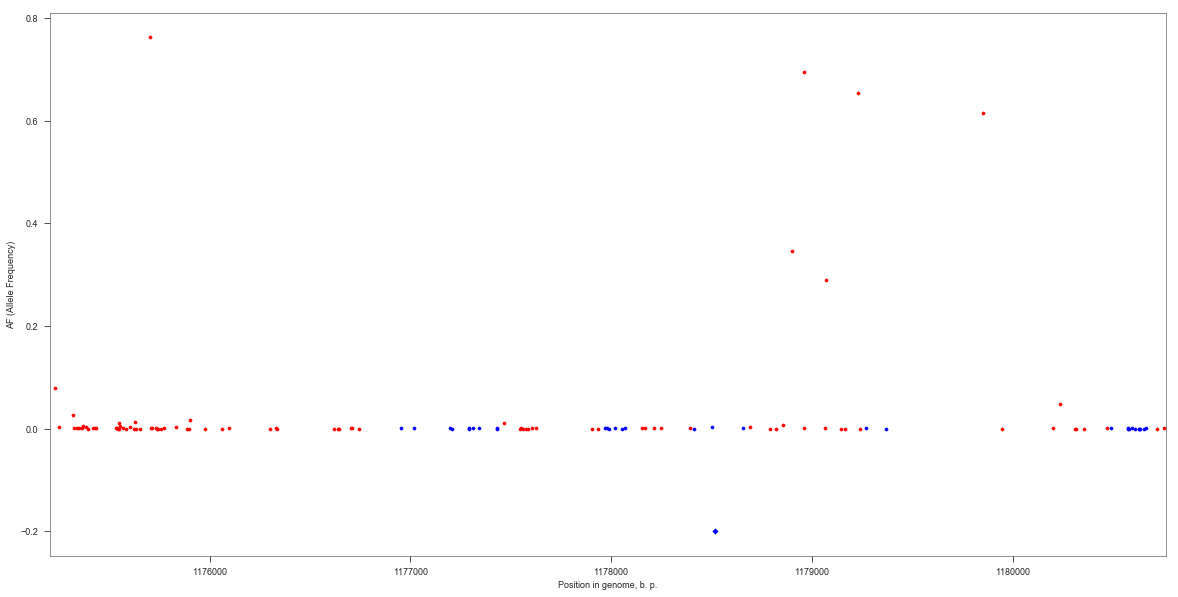

step # 82 PF3D7_1211900 start 529005.0 end 532799.0 non-SERCA-type+Ca2++-transporting+P-ATPase+%28ATP4%29 Gene name ATP4 Conservation score 3.592563291


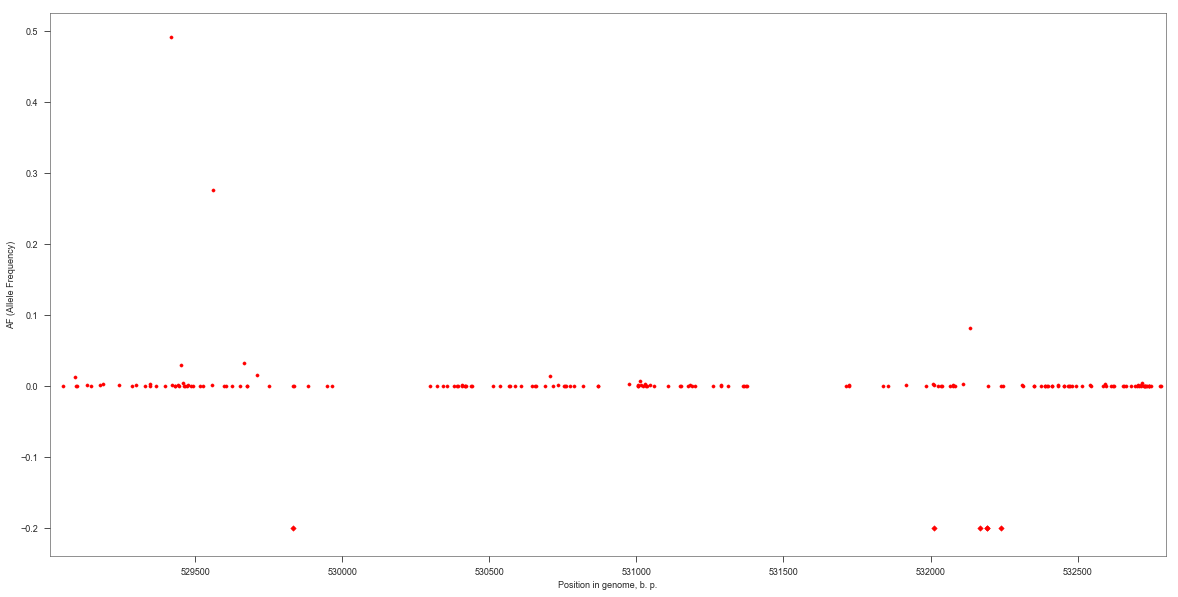

step # 83 PF3D7_0619300 start 803374.0 end 814552.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_0619300 Conservation score -0.212271973


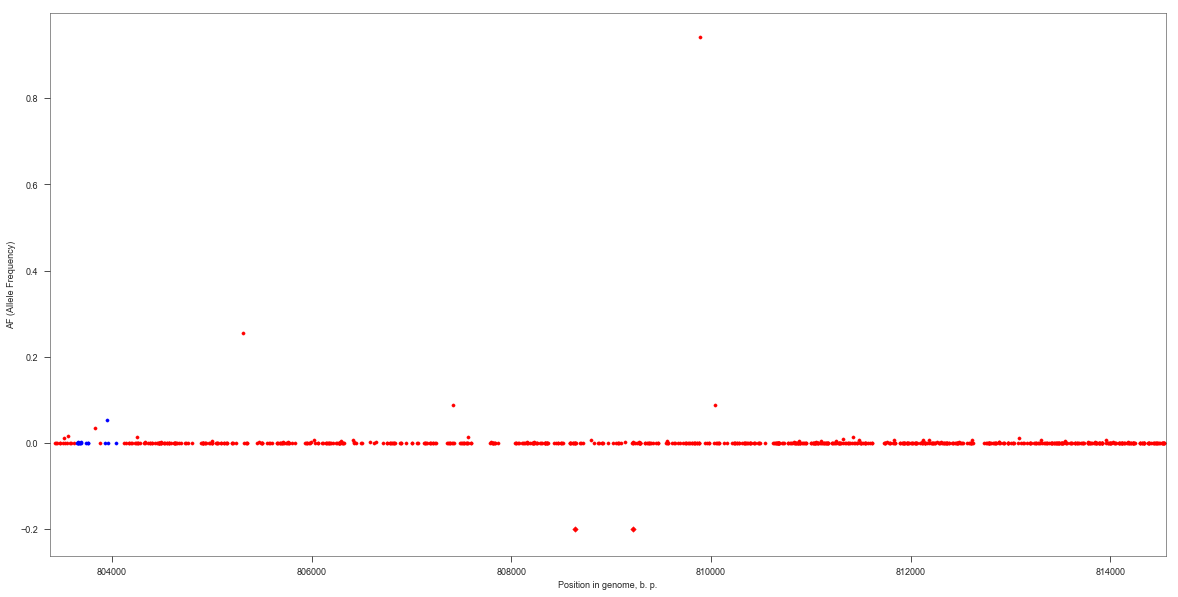

step # 84 PF3D7_1359400 start 2359251.0 end 2361198.0 CUGBP Elav-like family member 1 (CELF1) Gene name CELF1 Conservation score 4.10805501


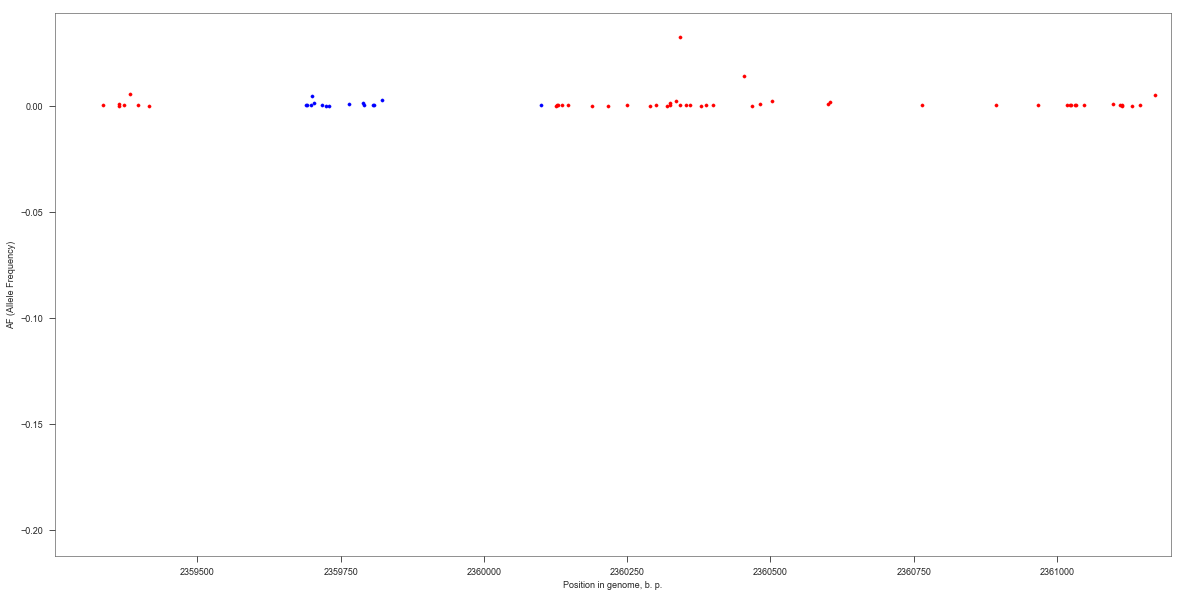

step # 85 PF3D7_1450900 start 2083231.0 end 2084665.0 "acetyl-CoA acetyltransferase, putative" Gene name PF3D7_1450900 Conservation score 3.567839196


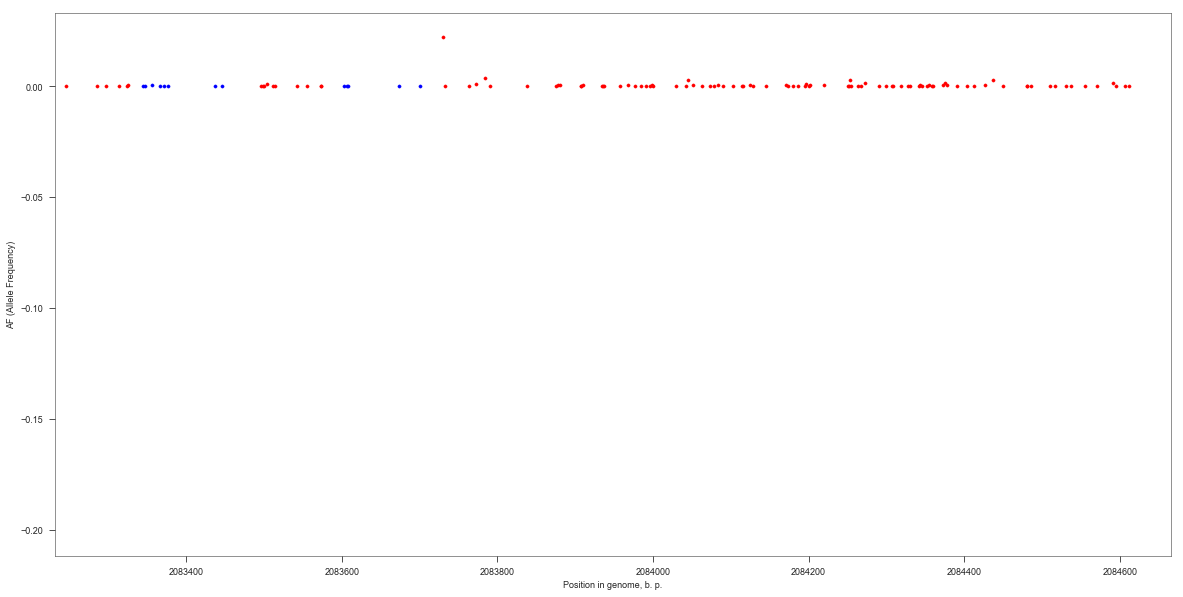

step # 86 PF3D7_1117400 start 664163.0 end 665356.0 "conserved Plasmodium protein, unknown function" Gene name PF3D7_1117400 Conservation score 0.911838791


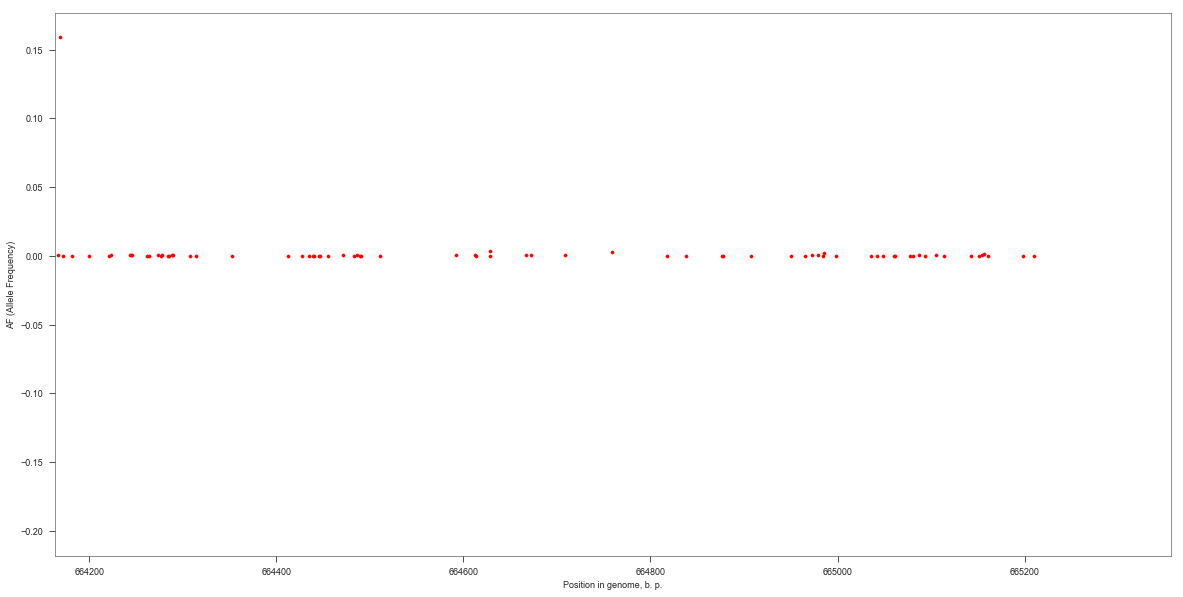

step # 87 PF3D7_1028300 start 1168010.0 end 1168957.0 nucleolar+preribosomal+assembly+protein%2C+putative Gene name EBP2 Conservation score 1.301587302


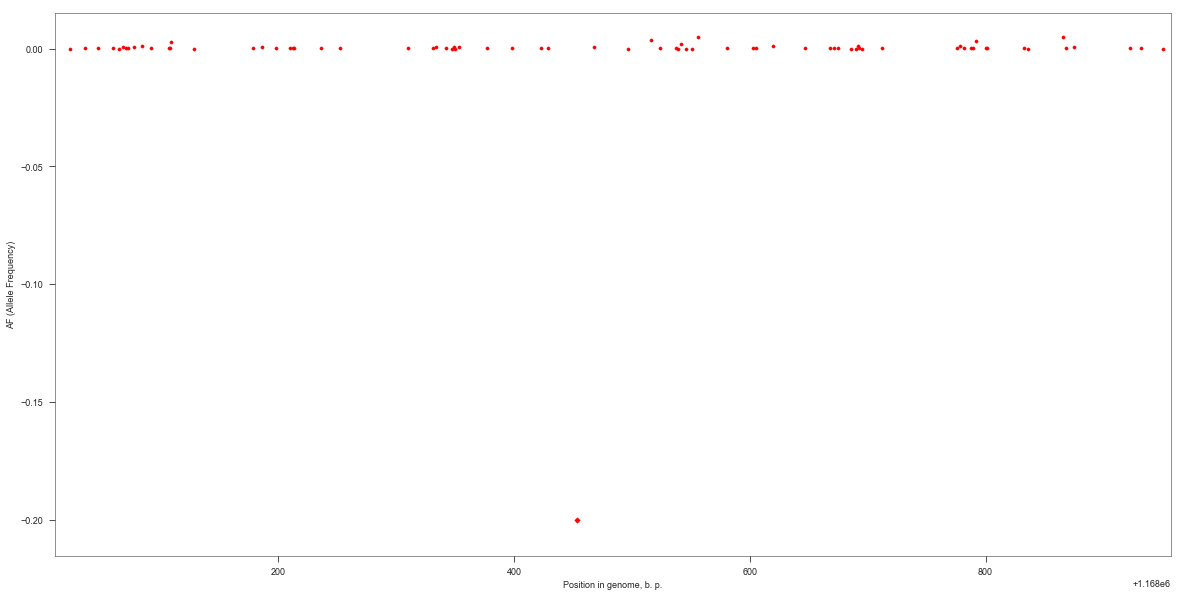

step # 88 PF3D7_1133800 start 1309024.0 end 1311793.0 "RNA (uracil-5-)methyltransferase, putative" Gene name PF3D7_1133800 Conservation score 2.084014002


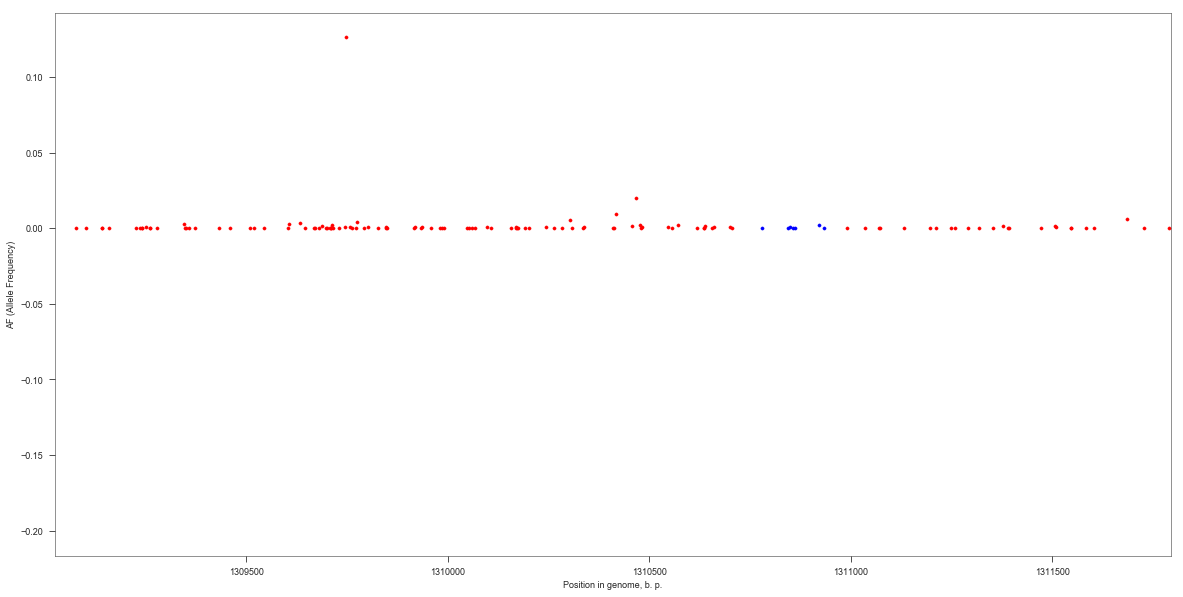

step # 89 PF3D7_1106500 start 268244.0 end 274552.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_1106500 Conservation score 0.17169718


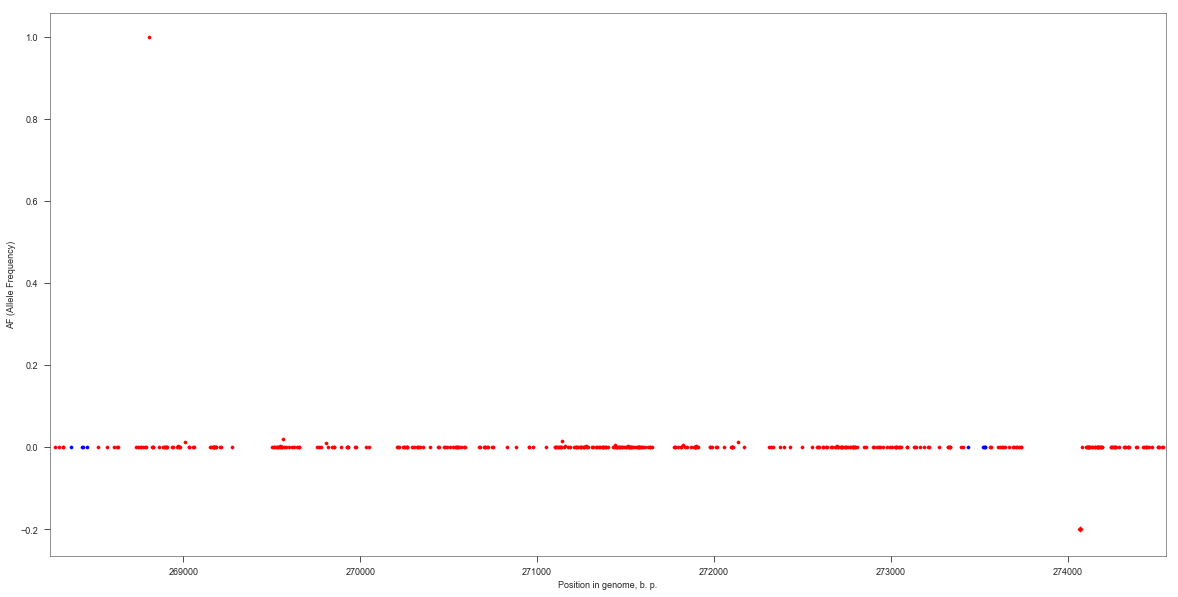

step # 90 PF3D7_1432200 start 1263826.0 end 1269011.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_1432200 Conservation score 0.036526946


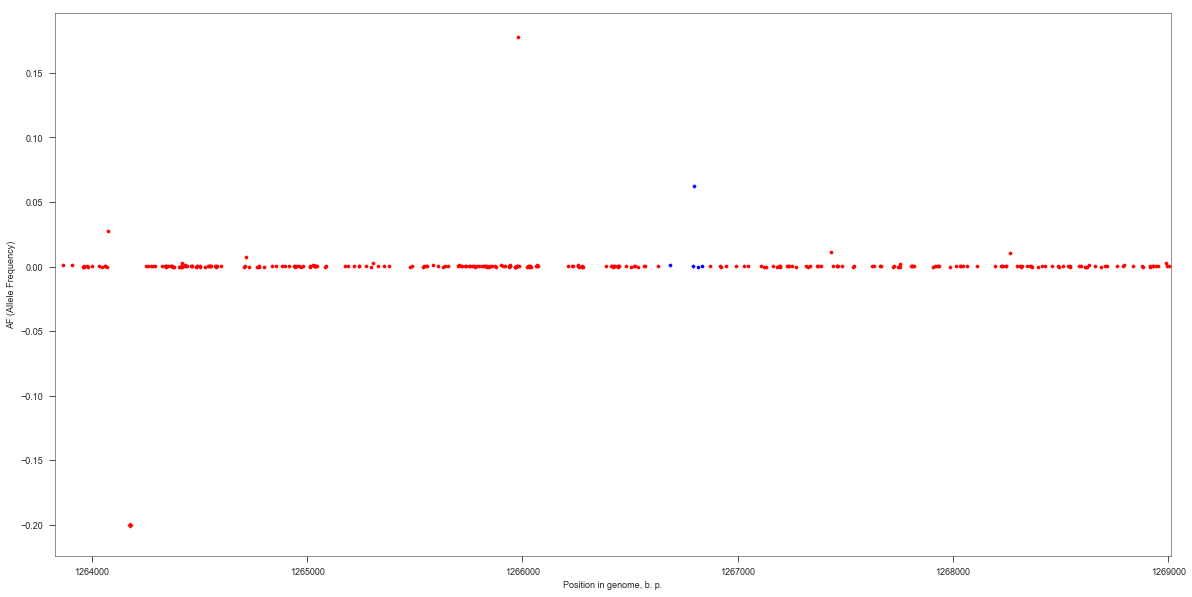

step # 91 PF3D7_1426600 start 1031065.0 end 1035360.0 "conserved Plasmodium protein, unknown function" Gene name PF3D7_1426600 Conservation score 0.193570929


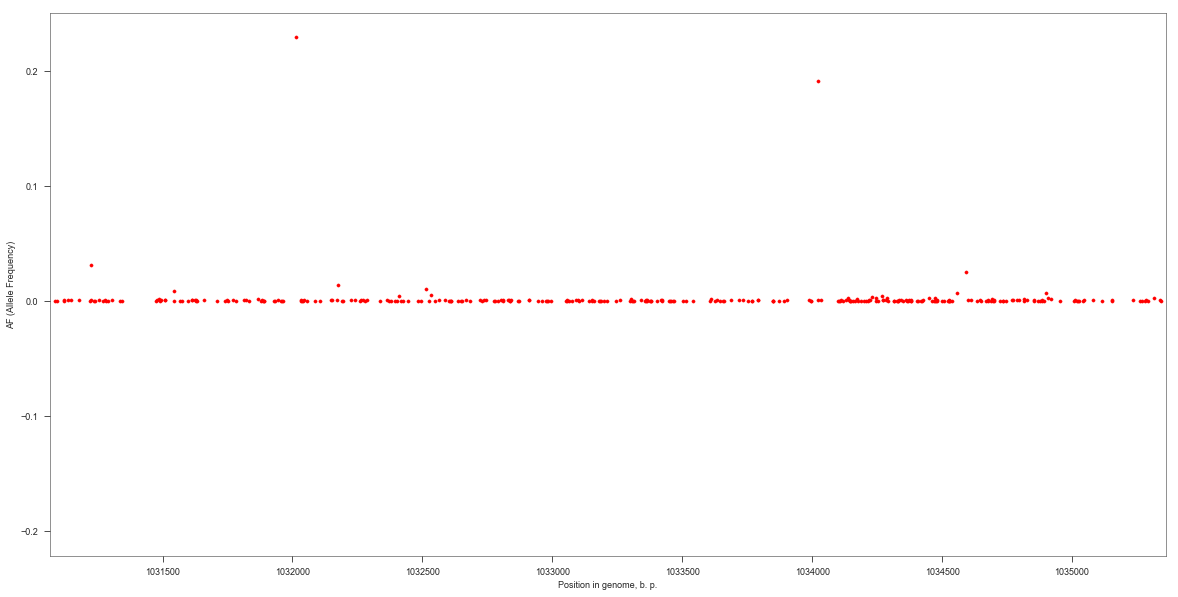

step # 92 PF3D7_1141100 start 1649321.0 end 1657012.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_1141100 Conservation score nan


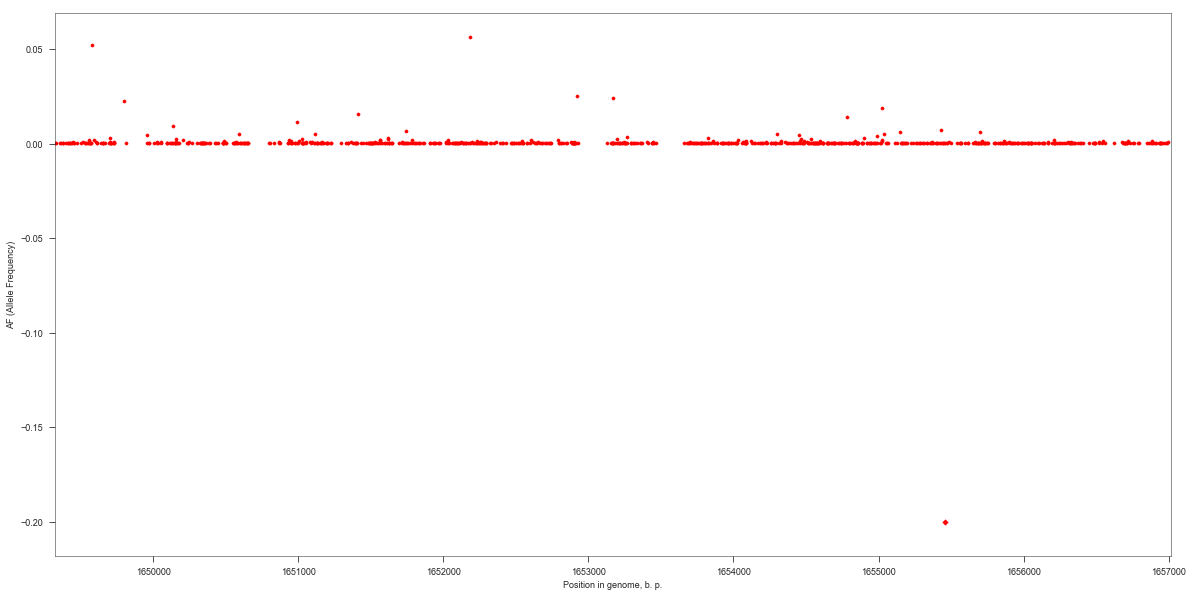

step # 93 PF3D7_1476100 start 3131104.0 end 3131637.0 early transcribed membrane protein 14.2 (ETRAMP14.2) Gene name ETRAMP14.2 Conservation score nan


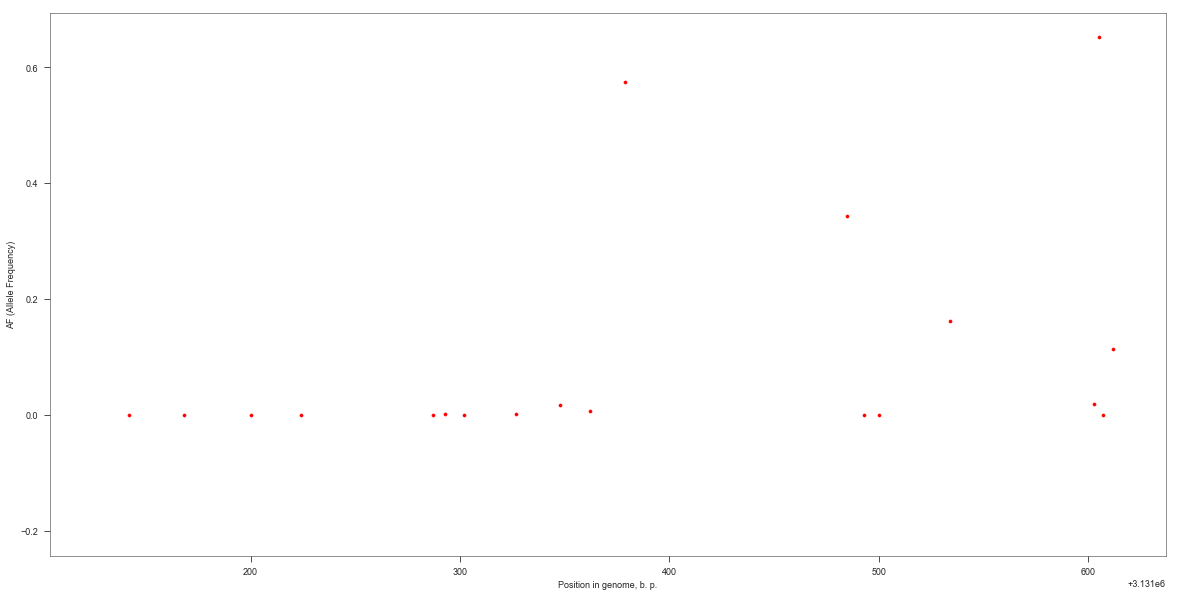

step # 94 PF3D7_1106100 start 258779.0 end 259981.0 "apicoplast ribosomal protein S15 precursor, putative" Gene name PF3D7_1106100 Conservation score 2.460966543


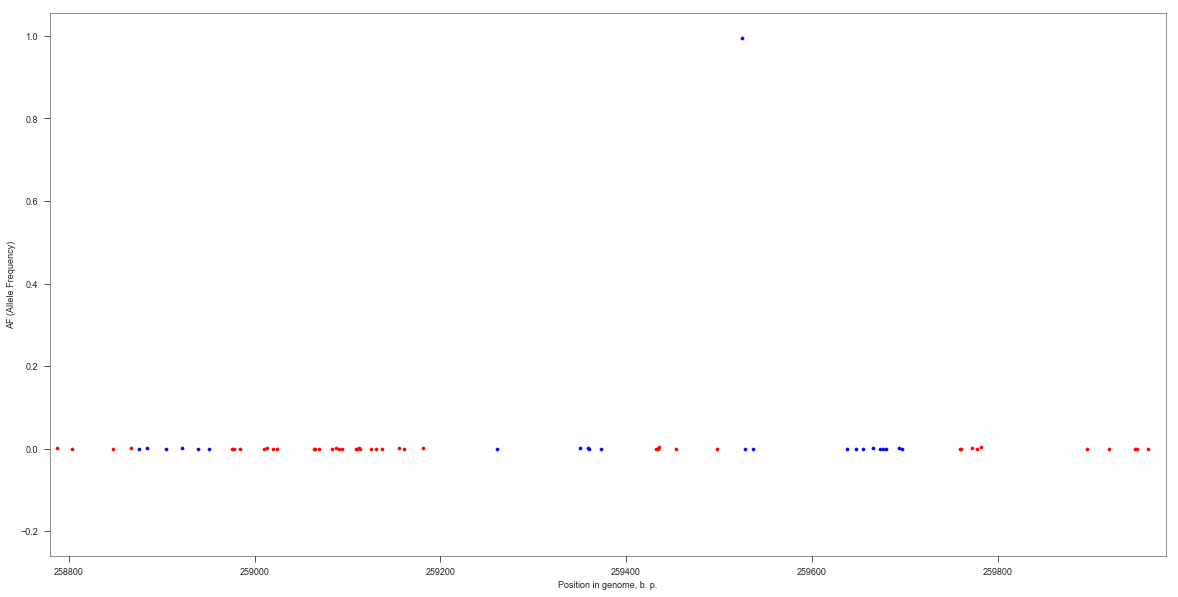

step # 95 PF3D7_0530900 start 1257723.0 end 1265750.0 formin+1 Gene name PF3D7_0530900 Conservation score 1.277009346


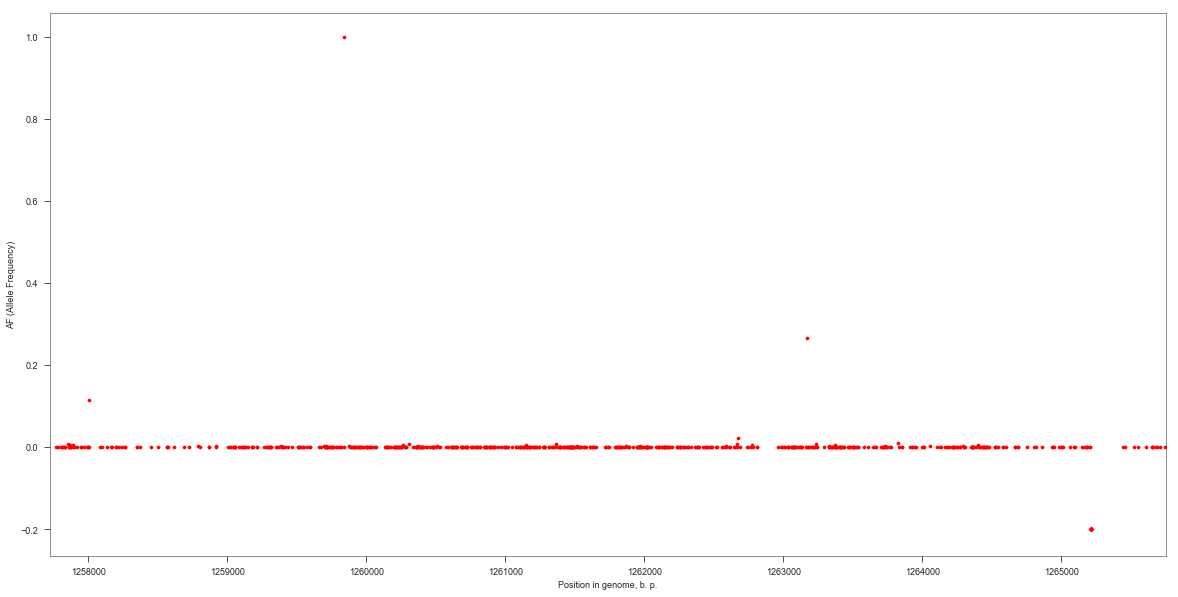

step # 96 PF3D7_0909700 start 440914.0 end 444024.0 FHA+domain+protein%2C+putative Gene name PF3D7_0909700 Conservation score 1.005791506


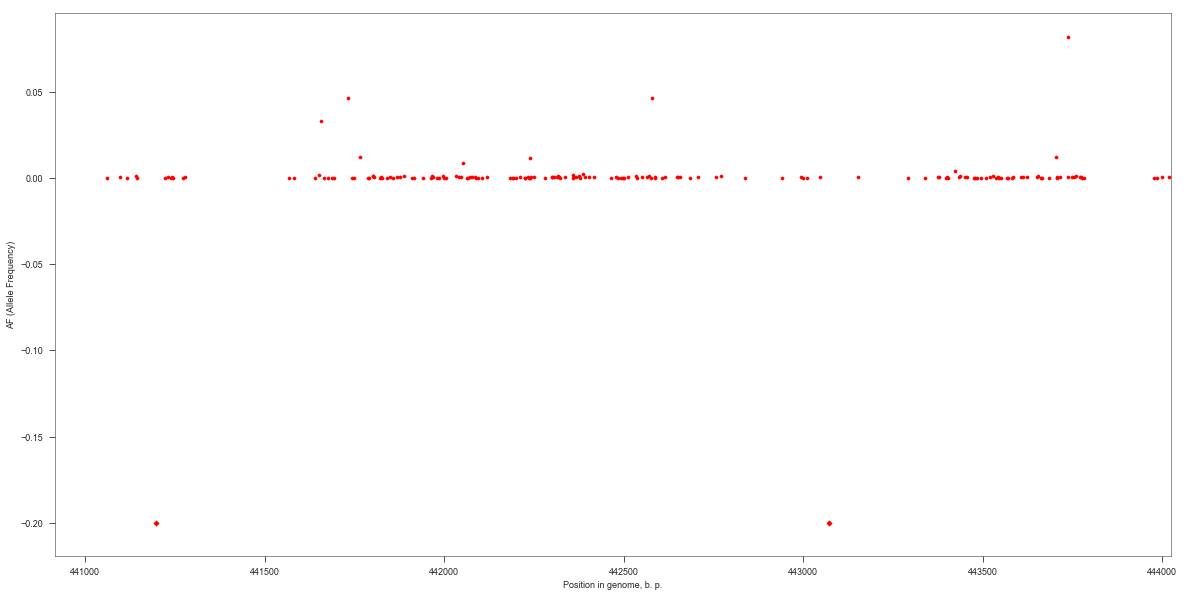

step # 97 PF3D7_0213900 start 561122.0 end 564622.0 "conserved Plasmodium protein, unknown function" Gene name PF3D7_0213900 Conservation score -0.071183533


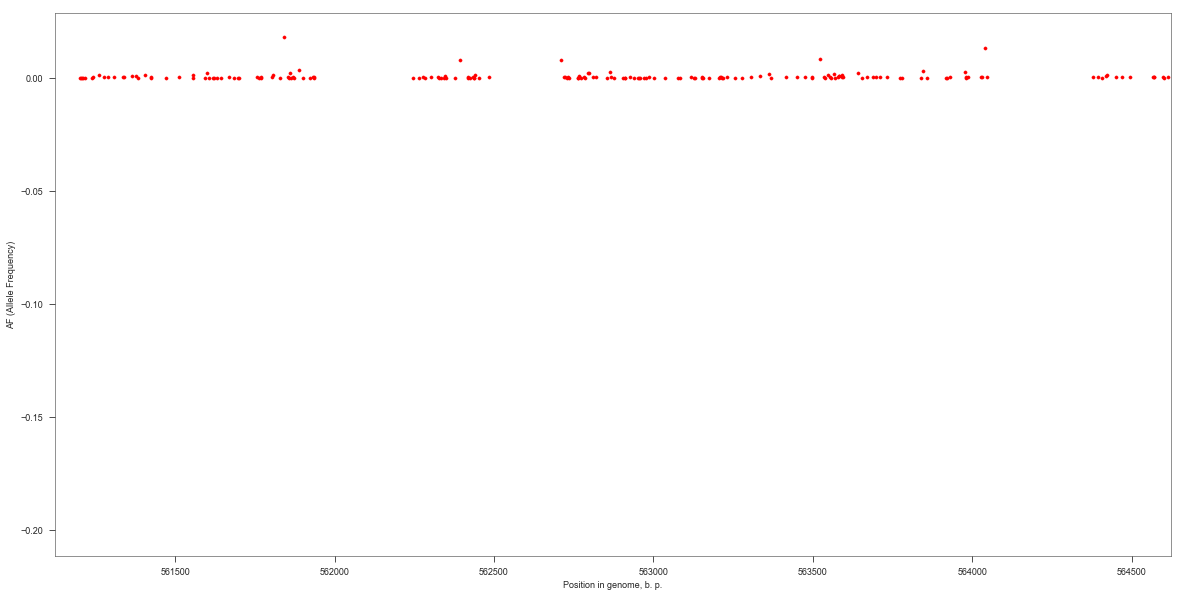

step # 98 PF3D7_0819500 start 881590.0 end 884390.0 "conserved protein, unknown function" Gene name PF3D7_0819500 Conservation score 3.461139896


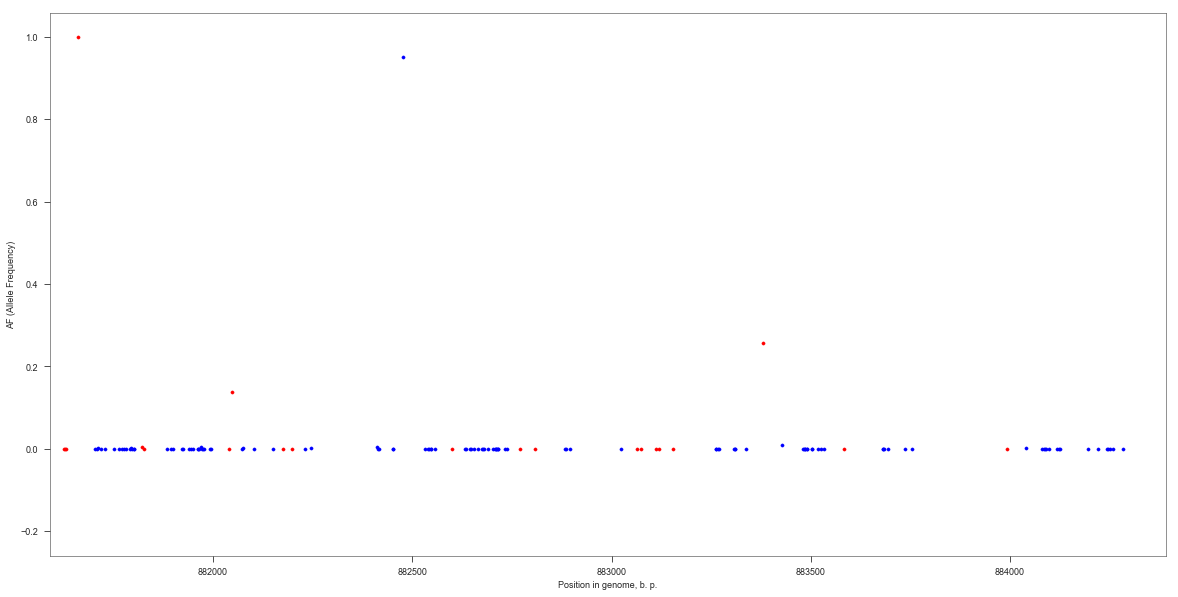

step # 99 PF3D7_0819300 start 874367.0 end 877498.0 "conserved Plasmodium protein, unknown function" Gene name PF3D7_0819300 Conservation score 0.797698945


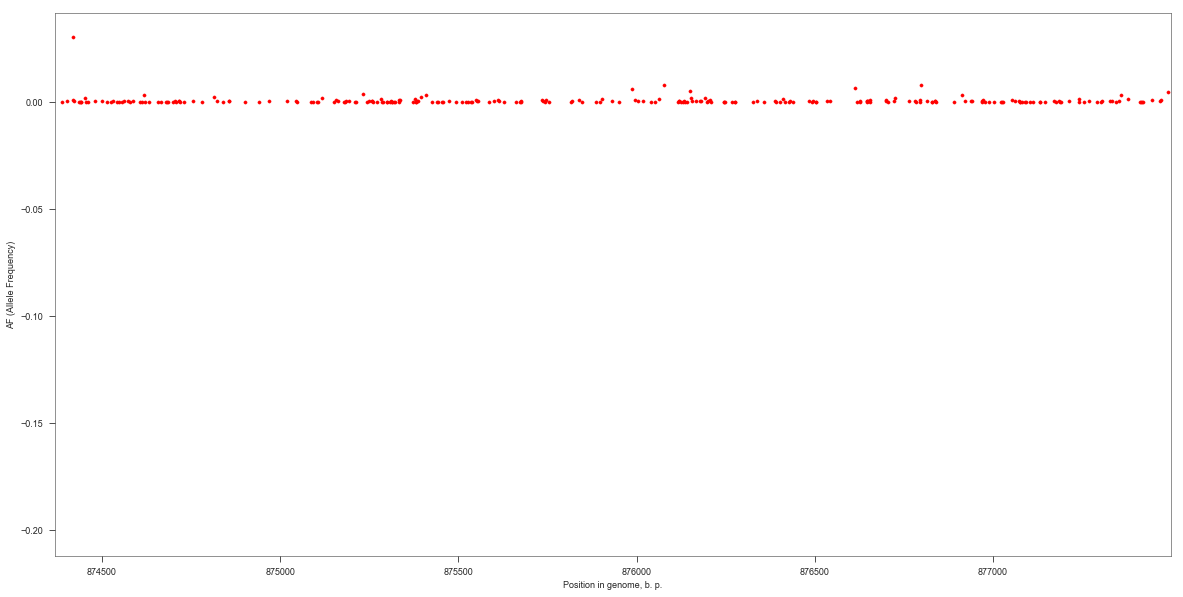

step # 100 PF3D7_1115400 start 584328.0 end 585806.0 cysteine proteinase falcipain 3 (FP3) Gene name FP3 Conservation score 1.697154472


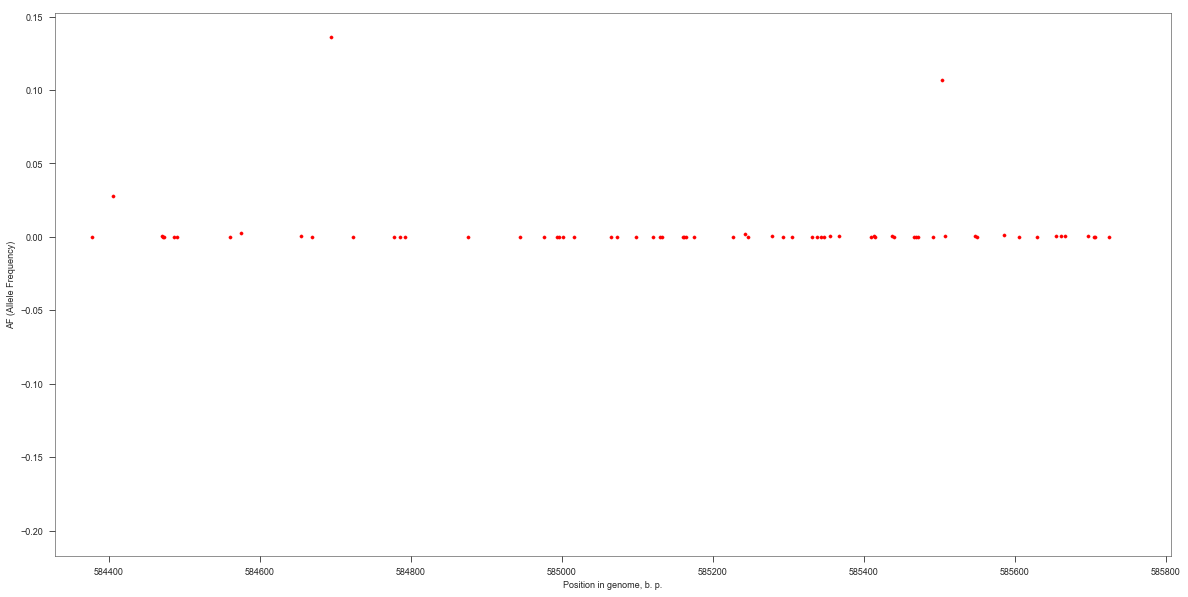

step # 101 PF3D7_0410700 start 481177.0 end 483891.0 GTPase%2C+putative Gene name RbgA Conservation score 1.670353982


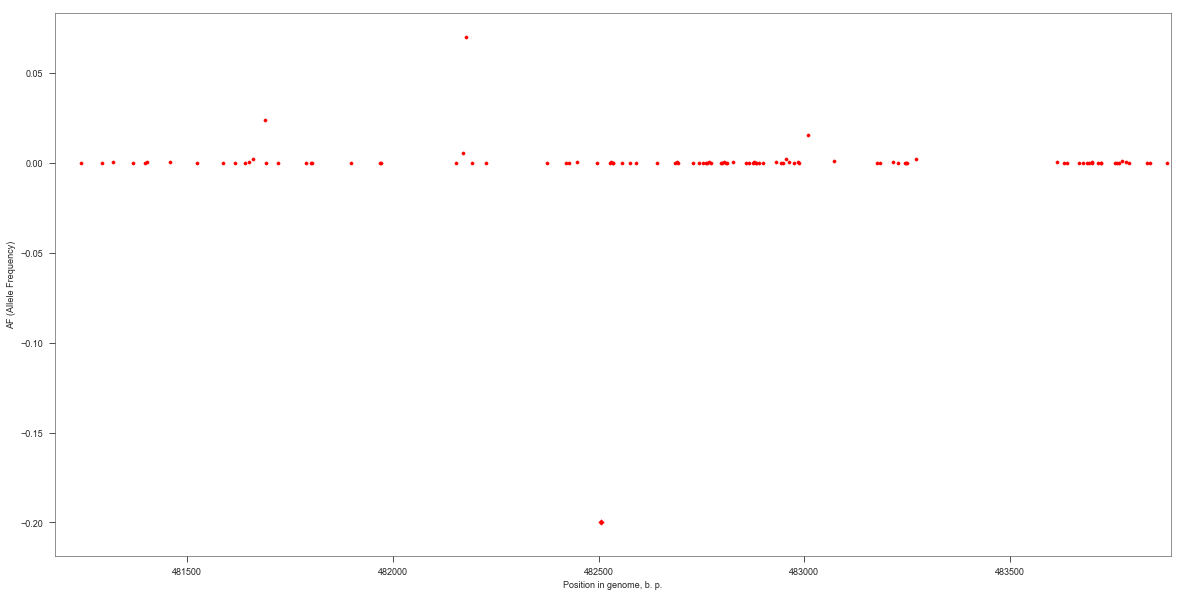

step # 102 PF3D7_0311200 start 474788.0 end 479086.0 valine--tRNA+ligase%2C+putative Gene name PF3D7_0311200 Conservation score 0.17190929


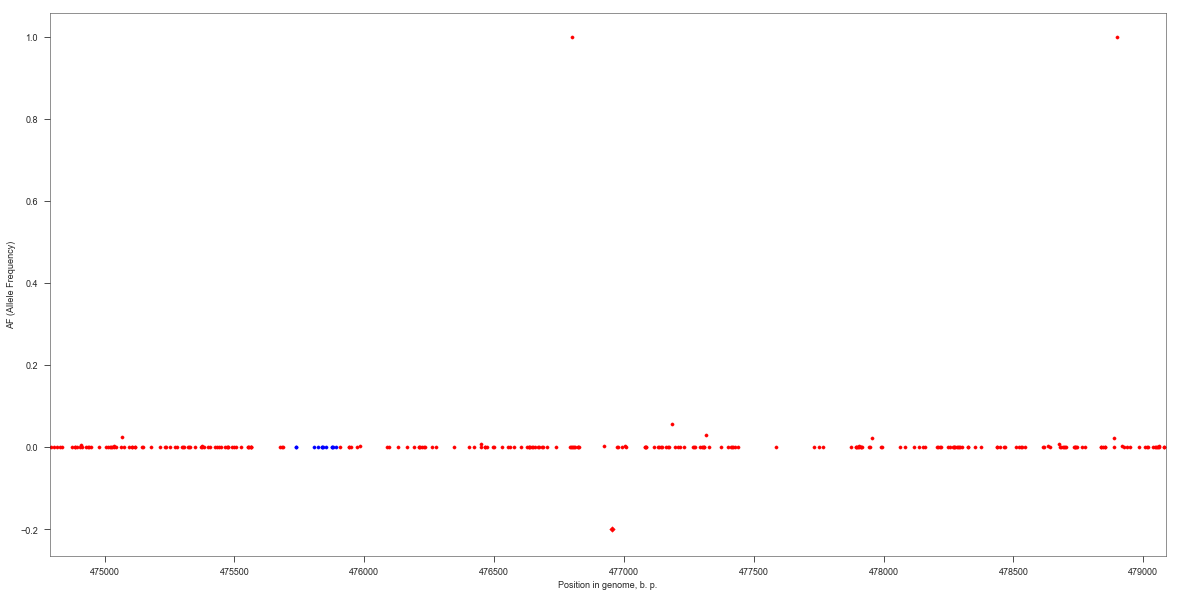

step # 103 PF3D7_1014800 start 596497.0 end 600413.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_1014800 Conservation score 2.459232614


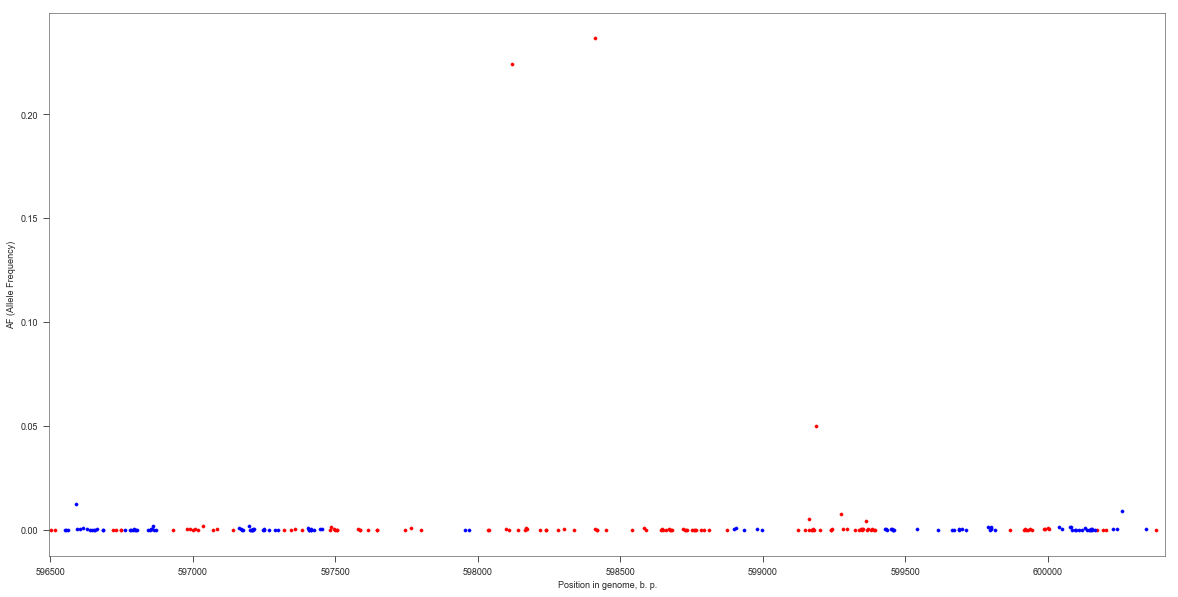

step # 104 PF3D7_1447900 start 1954601.0 end 1957675.0 multidrug+resistance+protein+2+%28heavy+metal+transport+family%29+%28MDR2%29 Gene name MDR2 Conservation score 1.989257813


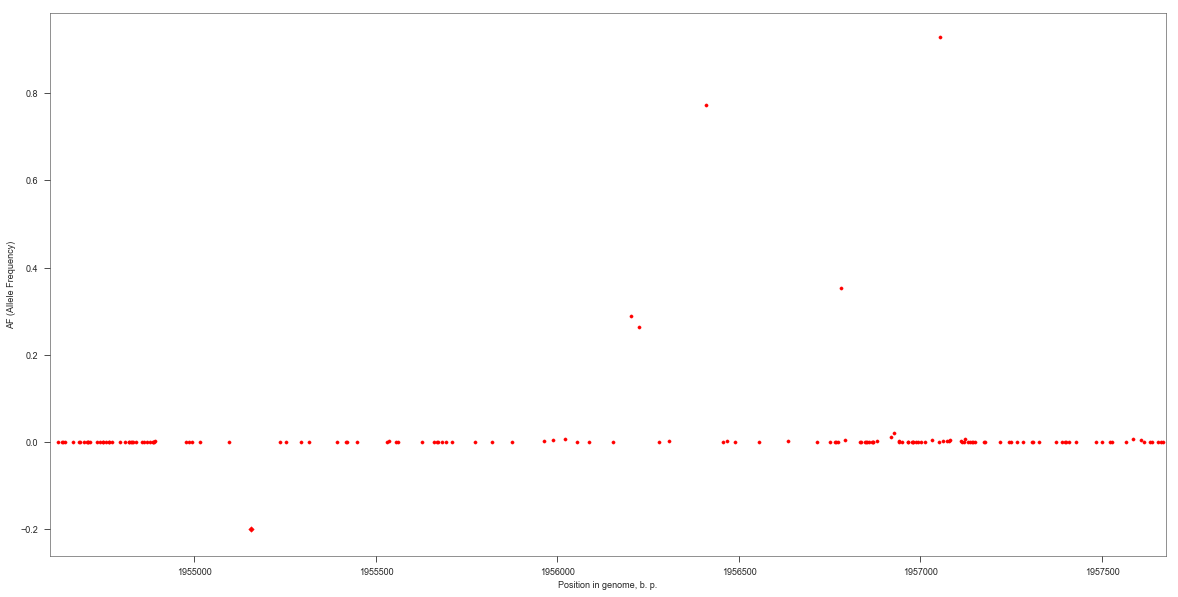

step # 105 PF3D7_1455600 start 2271529.0 end 2277243.0 ferlin%2C+putative Gene name PF3D7_1455600 Conservation score 2.919642857


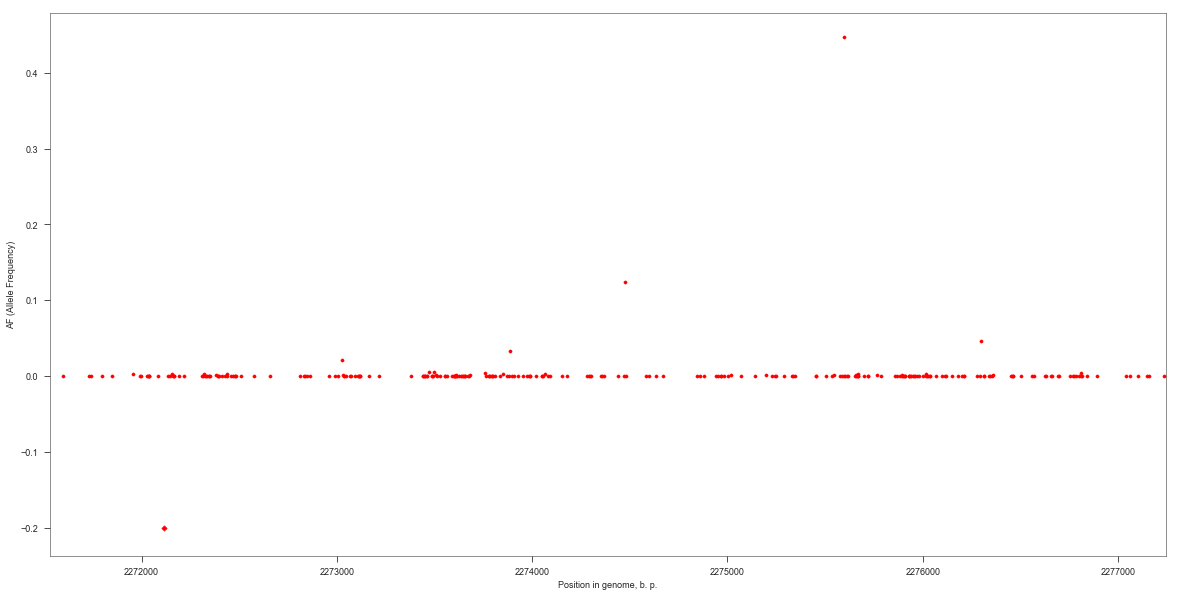

step # 106 PF3D7_1208100 start 361900.0 end 375874.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_1208100 Conservation score 1.401655851


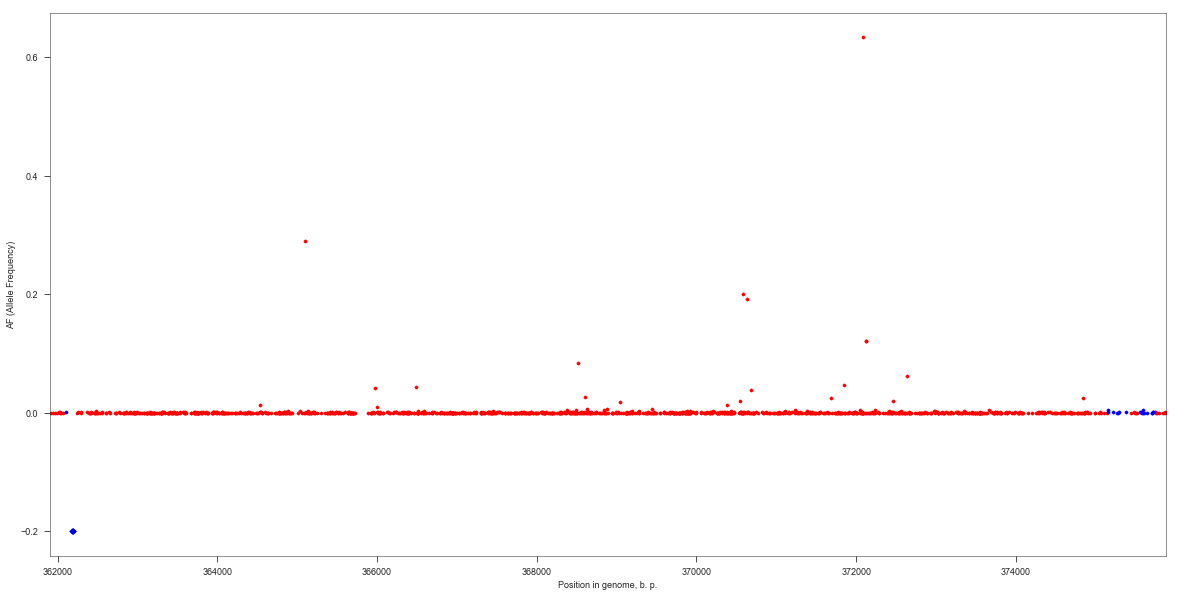

step # 107 PF3D7_0321900 start 922974.0 end 927942.0 cyclic+amine+resistance+locus+protein+%28CARL%29 Gene name CARL Conservation score 0.980514419


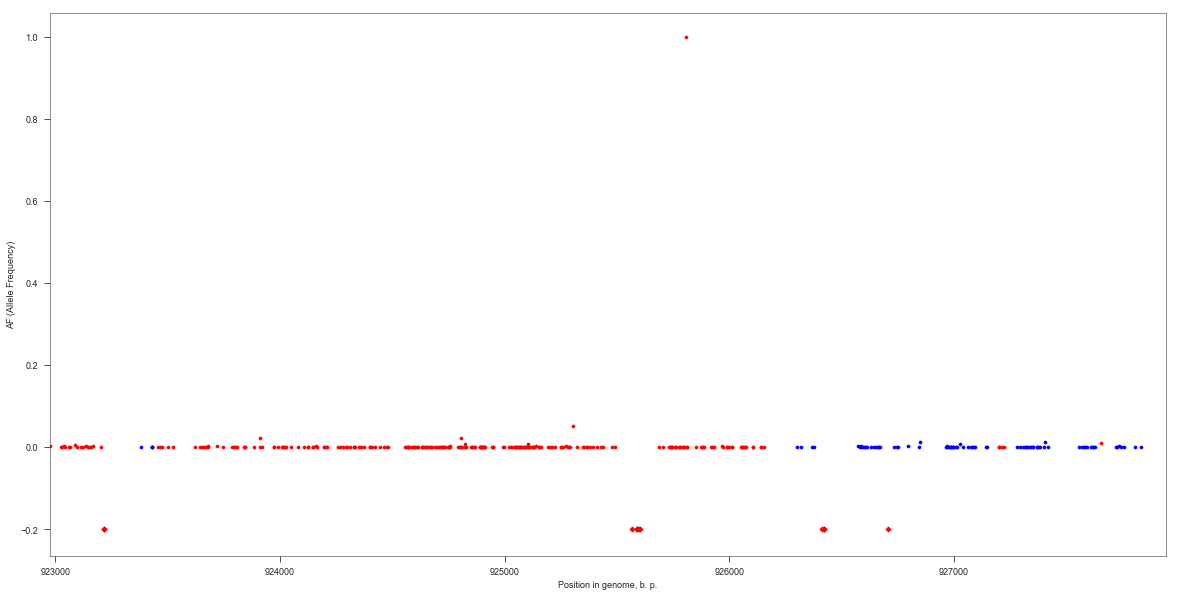

step # 108 PF3D7_1474400 start 3044129.0 end 3055248.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_1474400 Conservation score 0.804165267


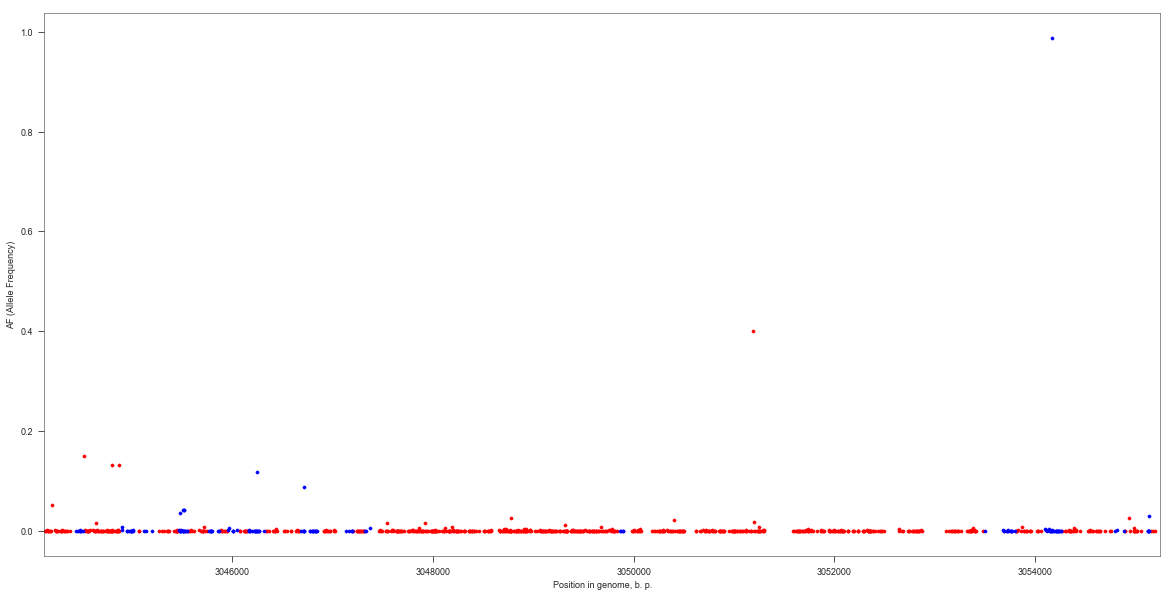

step # 109 PF3D7_1453400 start 2188178.0 end 2193949.0 "conserved Plasmodium protein, unknown function" Gene name PF3D7_1453400 Conservation score 1.651066043


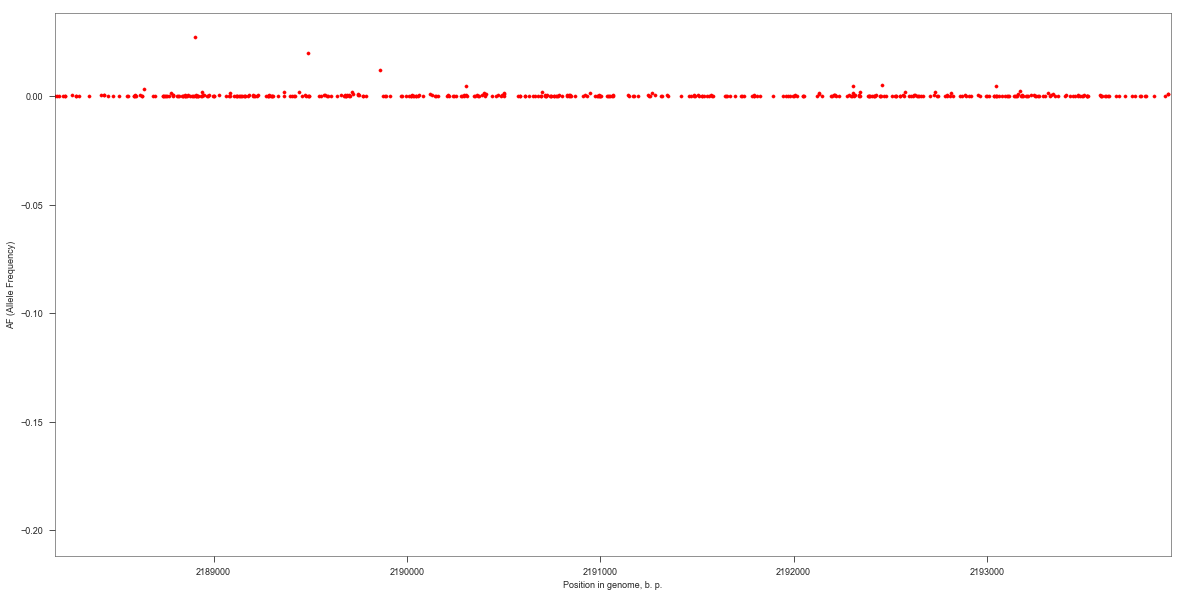

step # 110 PF3D7_1217500 start 693067.0 end 693711.0 "conserved Plasmodium protein, unknown function" Gene name PF3D7_1217500 Conservation score 2.336448598


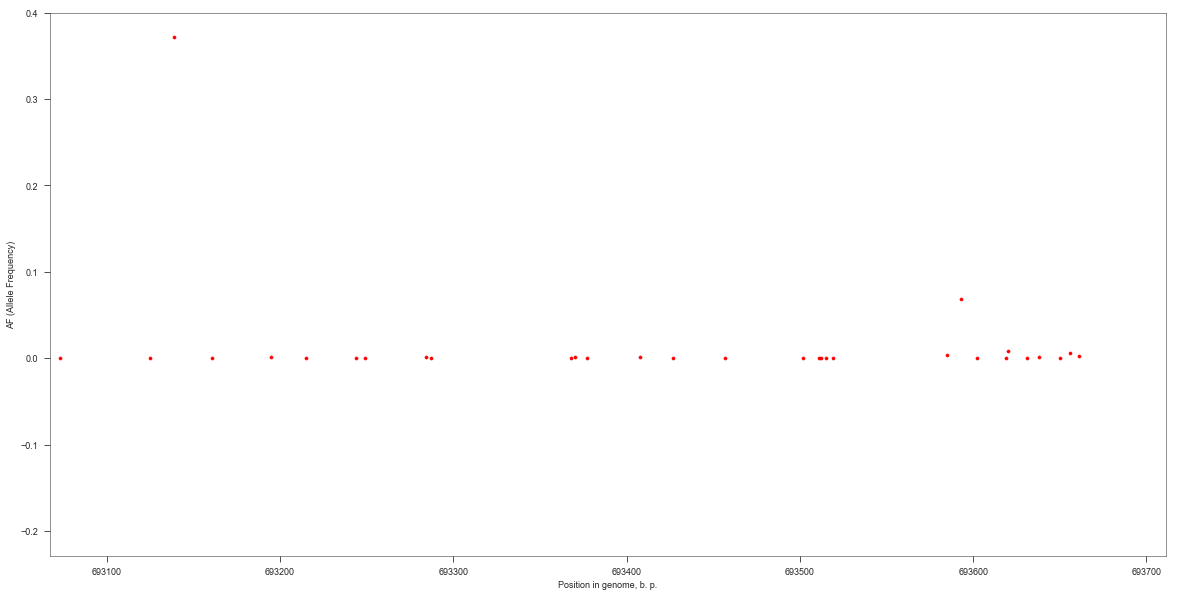

step # 111 PF3D7_1221000 start 836912.0 end 843901.0 histone-lysine+N-methyltransferase%2C+H3+lysine-4+specific+%28SET10%29 Gene name SET10 Conservation score 0.841992271


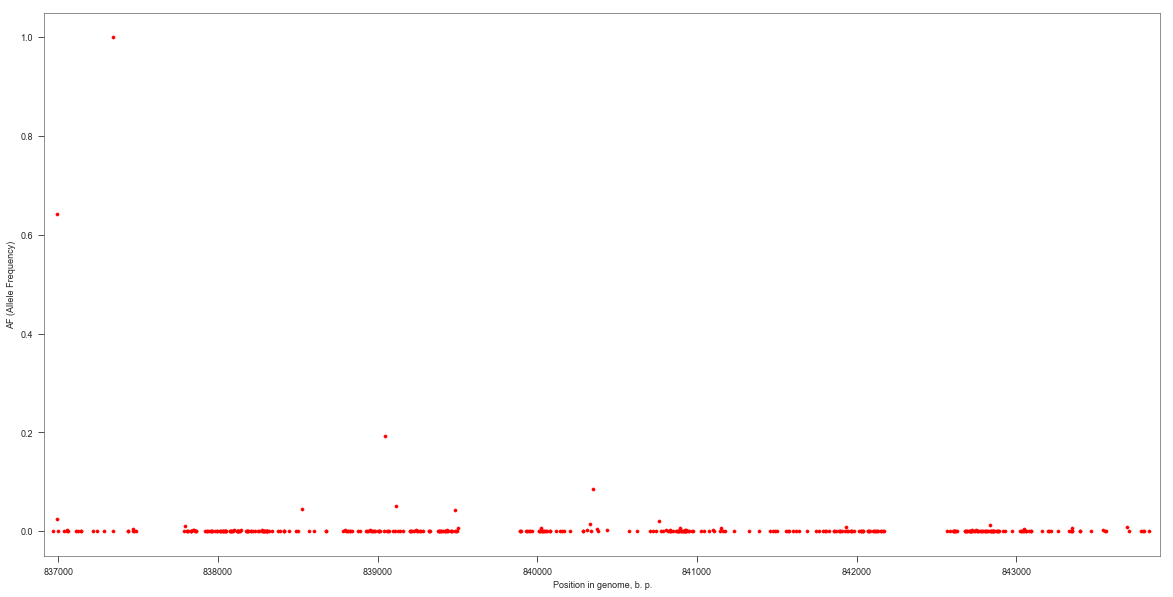

step # 112 PF3D7_0831500 start 1353456.0 end 1354669.0 Plasmodium+exported+protein+%28PHIST%29%2C+unknown+function Gene name PF3D7_0831500 Conservation score nan


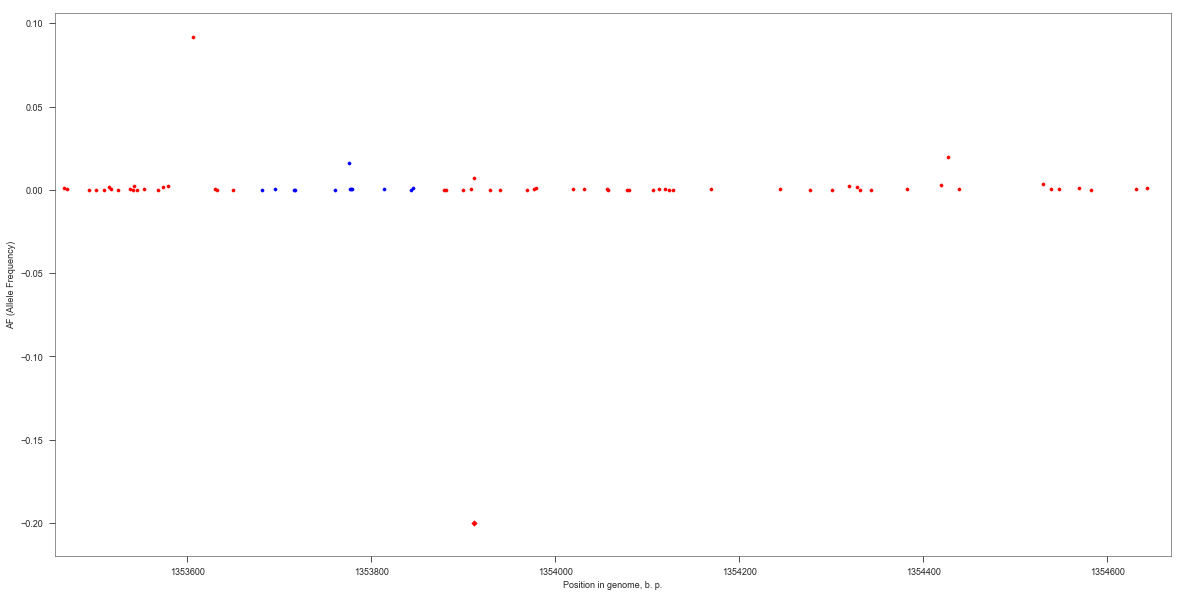

step # 113 PF3D7_1439100 start 1580750.0 end 1588857.0 DEAD%2FDEAH+box+helicase%2C+putative Gene name PF3D7_1439100 Conservation score 2.814724919


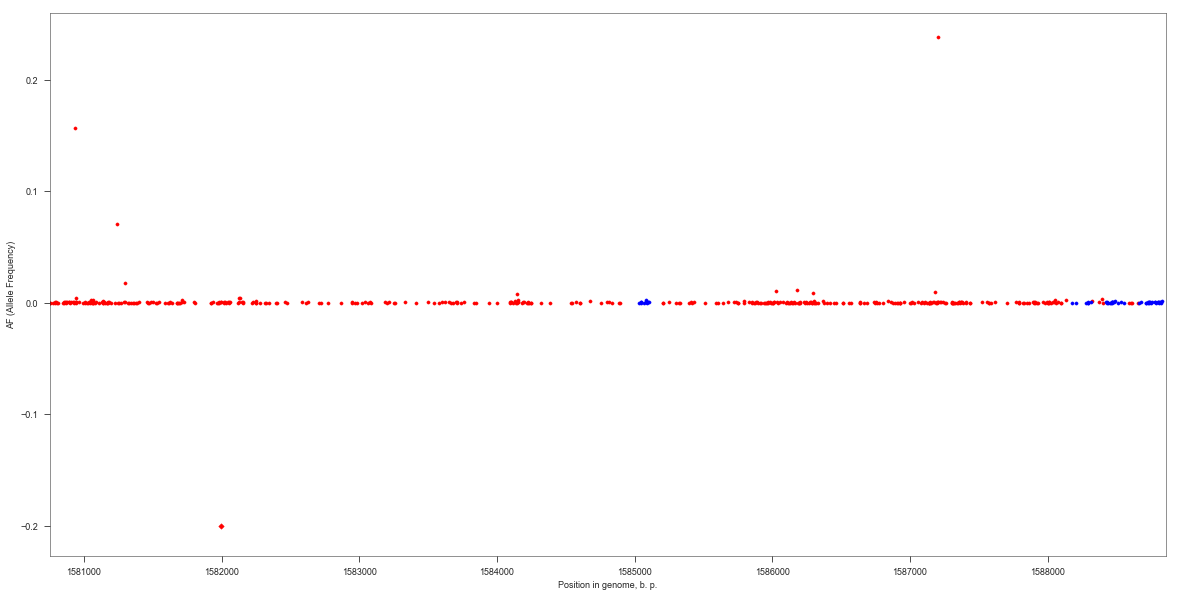

step # 114 PF3D7_0903300 start 140977.0 end 150588.0 "conserved Plasmodium membrane protein, unknown function" Gene name PF3D7_0903300 Conservation score -0.961286294


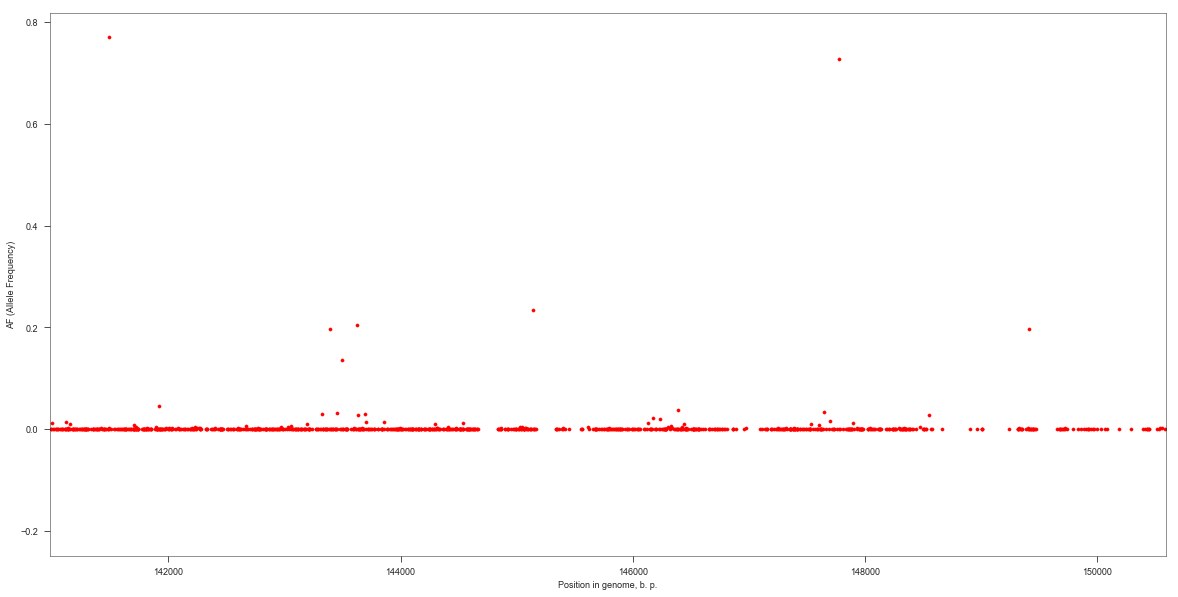

step # 115 PF3D7_1238800 start 1610363.0 end 1612741.0 acyl-CoA+synthetase+%28ACS11%29 Gene name ACS11 Conservation score 2.640151515


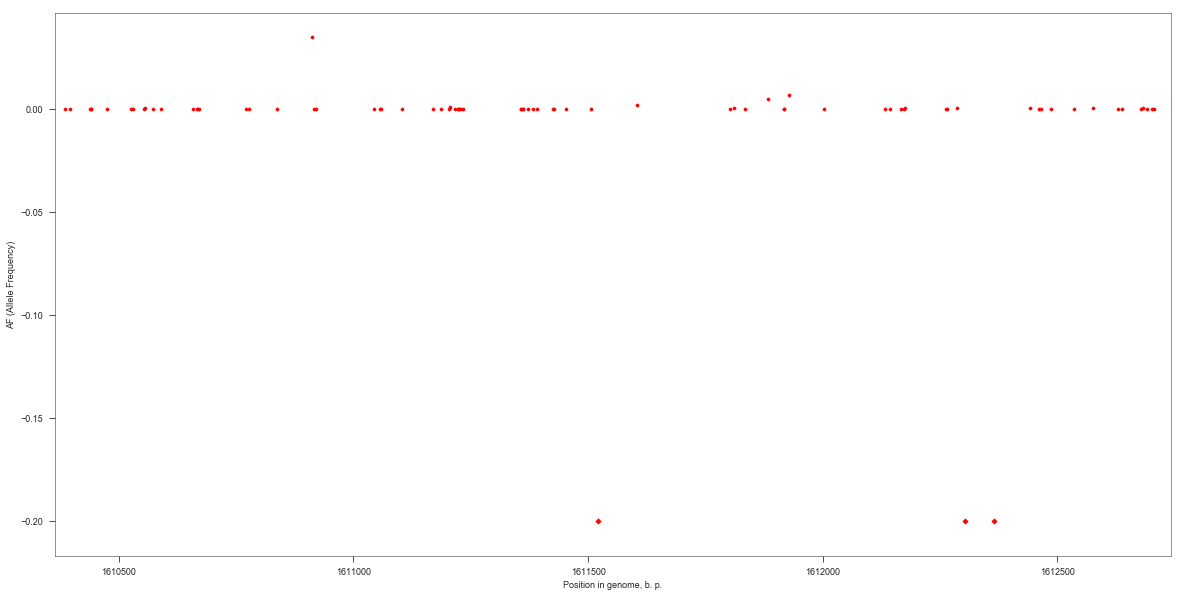

step # 116 PF3D7_0629500 start 1213948.0 end 1216005.0 amino+acid+transporter%2C+putative Gene name PF3D7_0629500 Conservation score nan


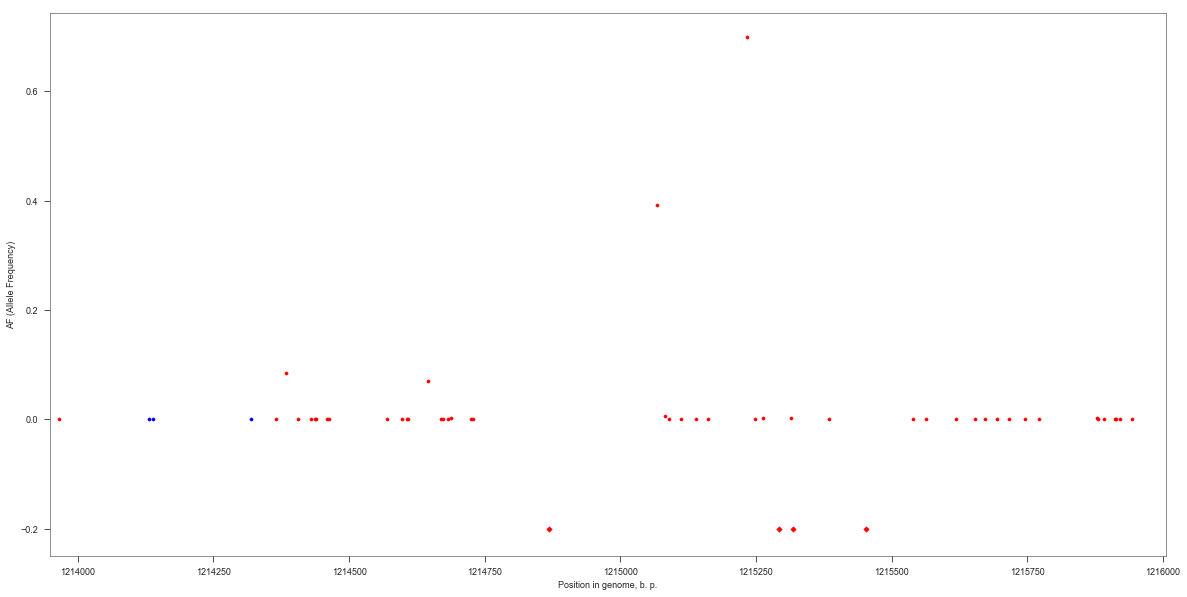

step # 117 PF3D7_1438700 start 1564575.0 end 1567839.0 DNA primase small subunit Gene name PF3D7_1438700 Conservation score 3.933628319


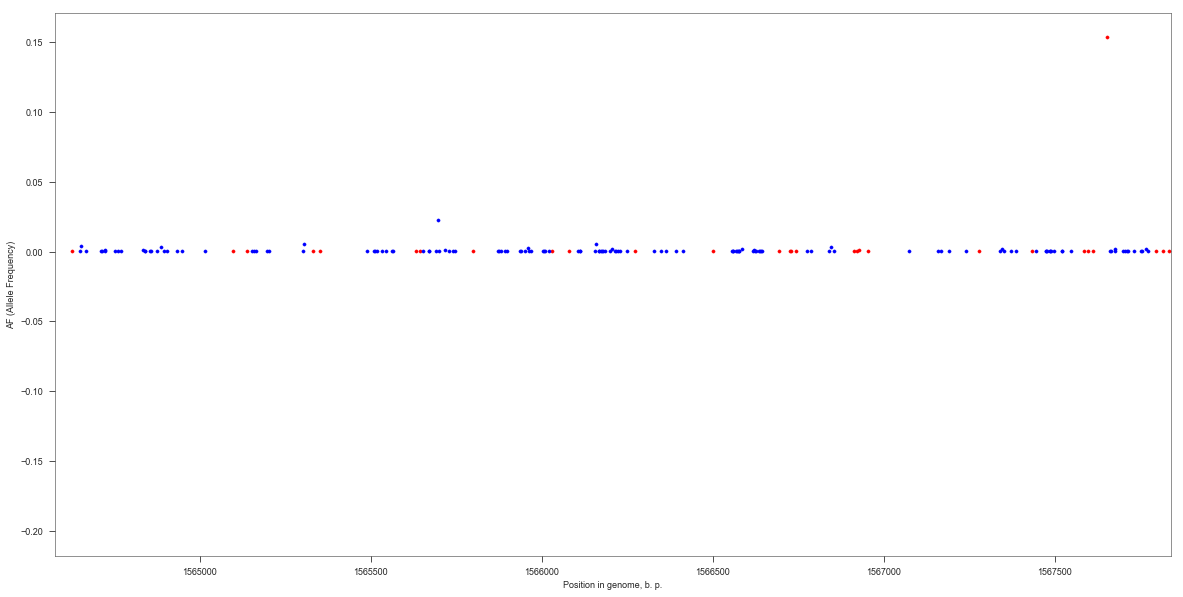

step # 118 PF3D7_0937000 start 1465904.0 end 1467055.0 Plasmodium+exported+protein+%28PHISTb%29%2C+unknown+function Gene name PF3D7_0937000 Conservation score nan


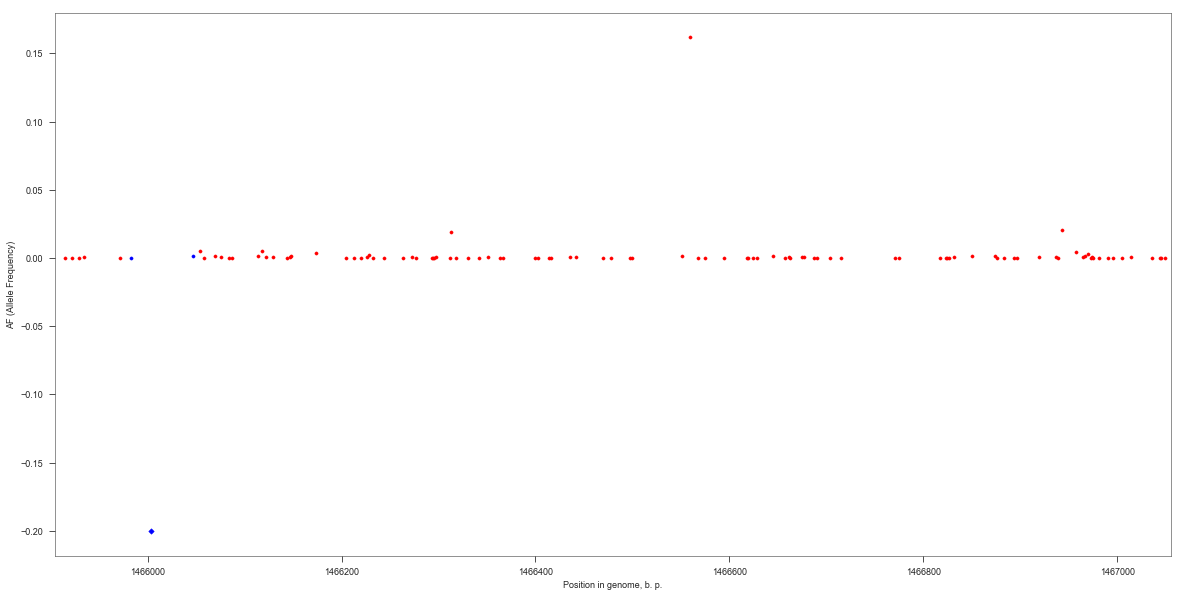

step # 119 PF3D7_1116700 start 630779.0 end 632881.0 cathepsin+C%2C+homolog%2Cdipeptidyl+peptidase+1+%28DPAP1%29 Gene name DPAP1 Conservation score 2.475714286


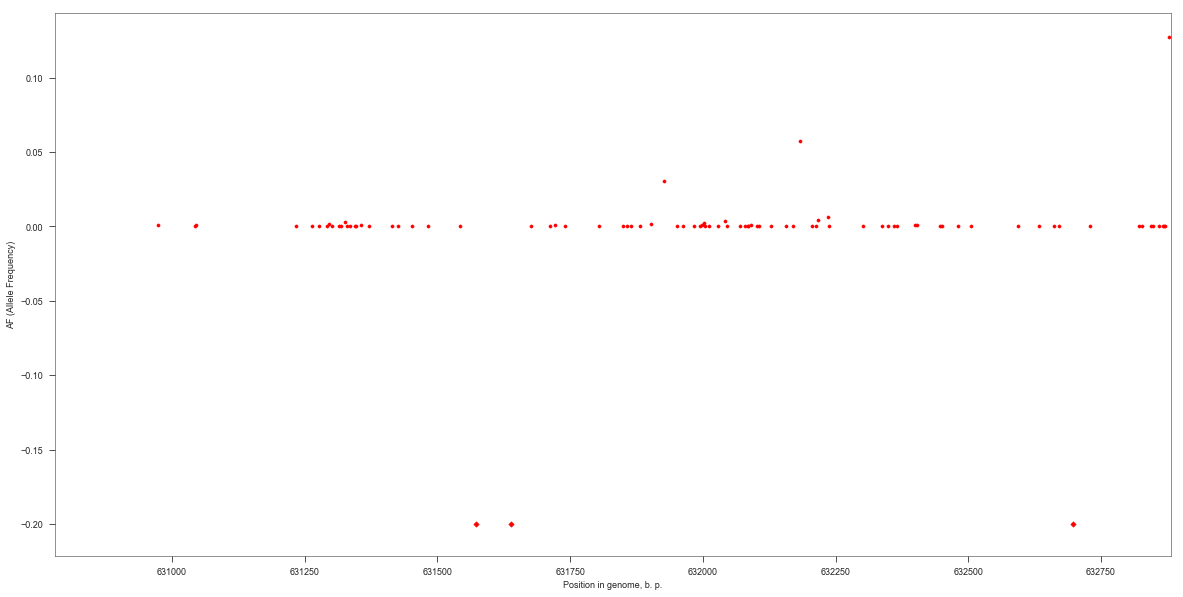

step # 120 PF3D7_1330700 start 1290118.0 end 1292954.0 "GPI transamidase subunit PIG-U, putative" Gene name PF3D7_1330700 Conservation score 1.995090016


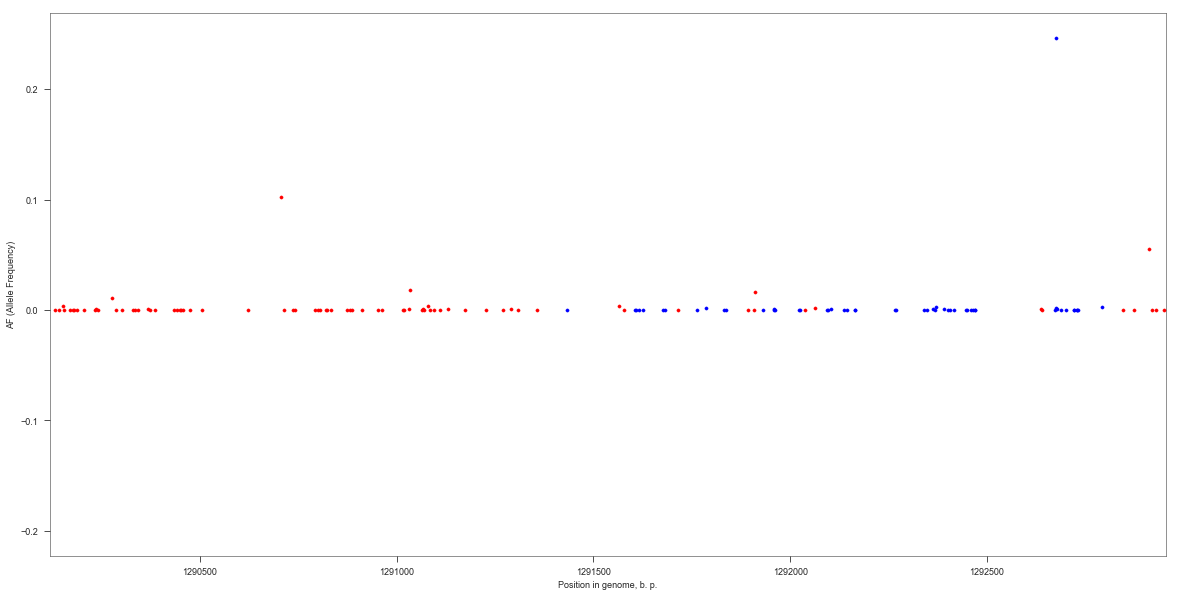

step # 121 PF3D7_0415300 start 681810.0 end 685968.0 cdc2-related protein kinase 3 Gene name CRK3 Conservation score 0.894697535


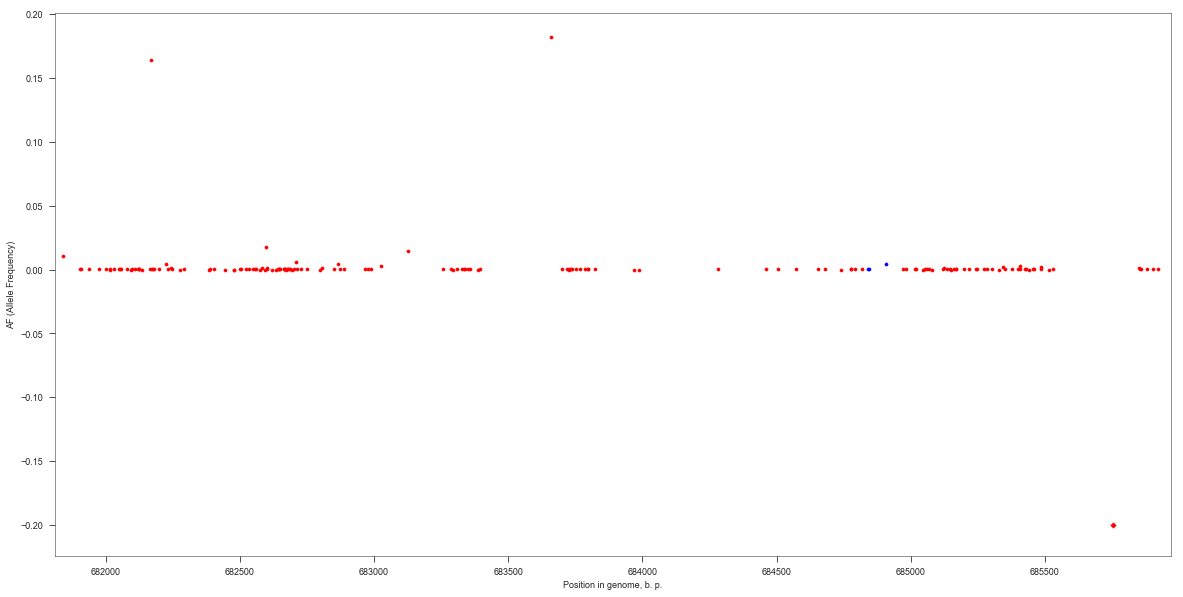

step # 122 PF3D7_0920200 start 827730.0 end 830681.0 "CS domain protein, putative" Gene name PF3D7_0920200 Conservation score 2.511698881


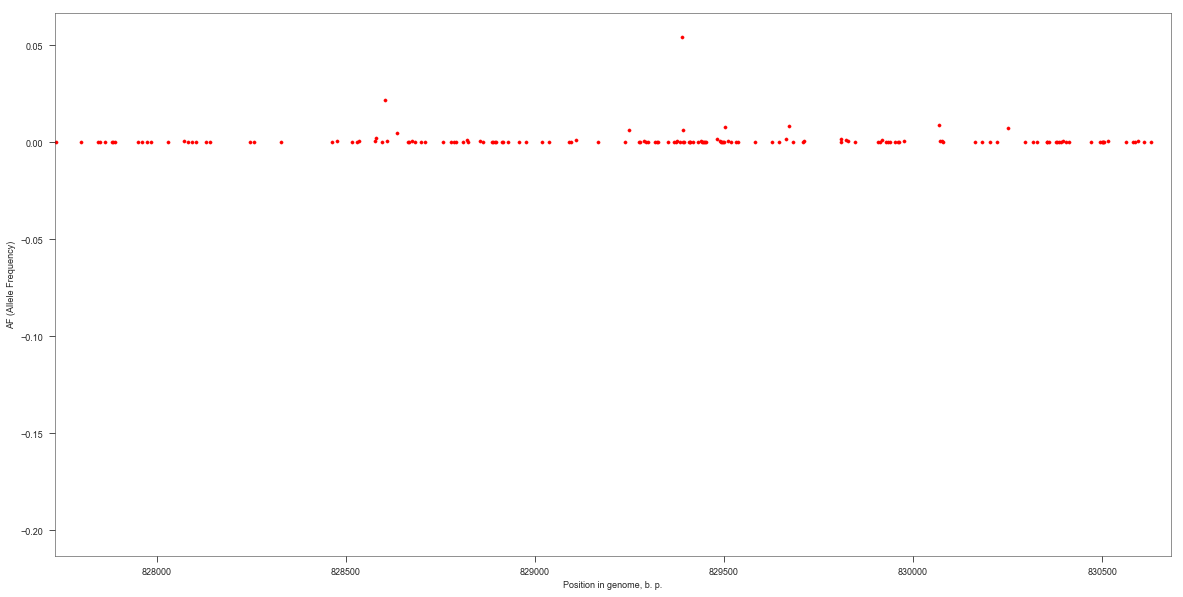

step # 123 PF3D7_0613800 start 566139.0 end 578993.0 transcription+factor+with+AP2+domain%28s%29+%28ApiAP2%29 Gene name ApiAP2 Conservation score -1.505475785


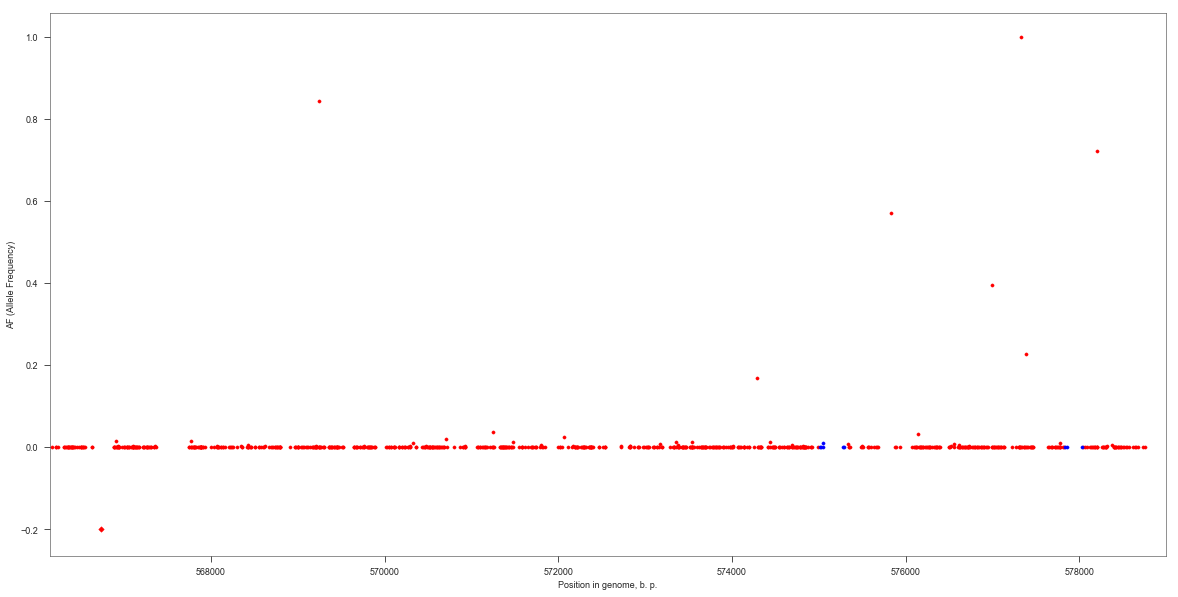

step # 124 PF3D7_0720400 start 882936.0 end 884988.0 ferrodoxin reductase-like protein Gene name PF3D7_0720400 Conservation score 3.023364486


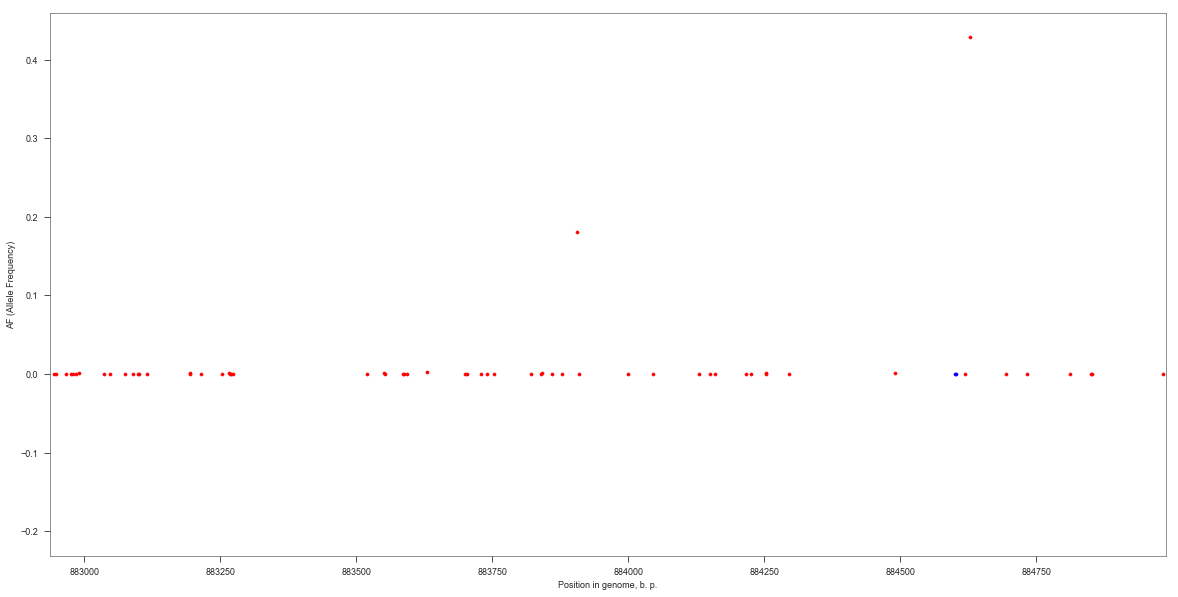

step # 125 PF3D7_0509800 start 410268.0 end 415308.0 phosphatidylinositol+4-kinase Gene name PI4K Conservation score 1.756254009


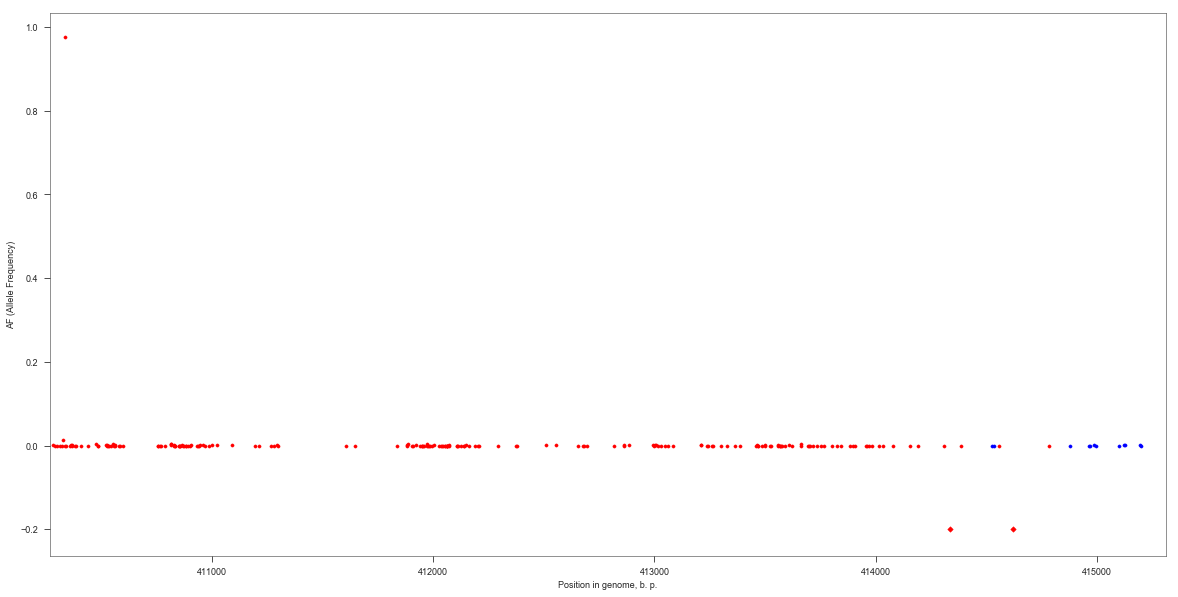

step # 126 PF3D7_0602100 start 92506.0 end 96668.0 ATP-dependent+RNA+helicase%2C+putative Gene name PF3D7_0602100 Conservation score 2.823703704


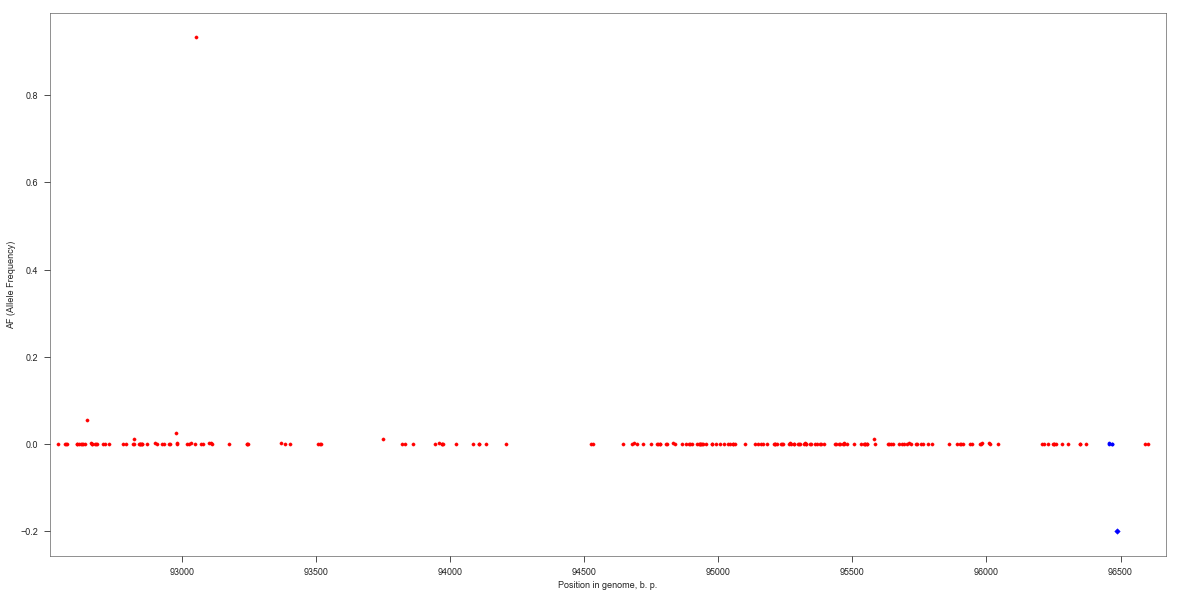

step # 127 PF3D7_0504700 start 180421.0 end 187470.0 conserved+Plasmodium+protein%2C+unknown+function Gene name CEP120 Conservation score nan


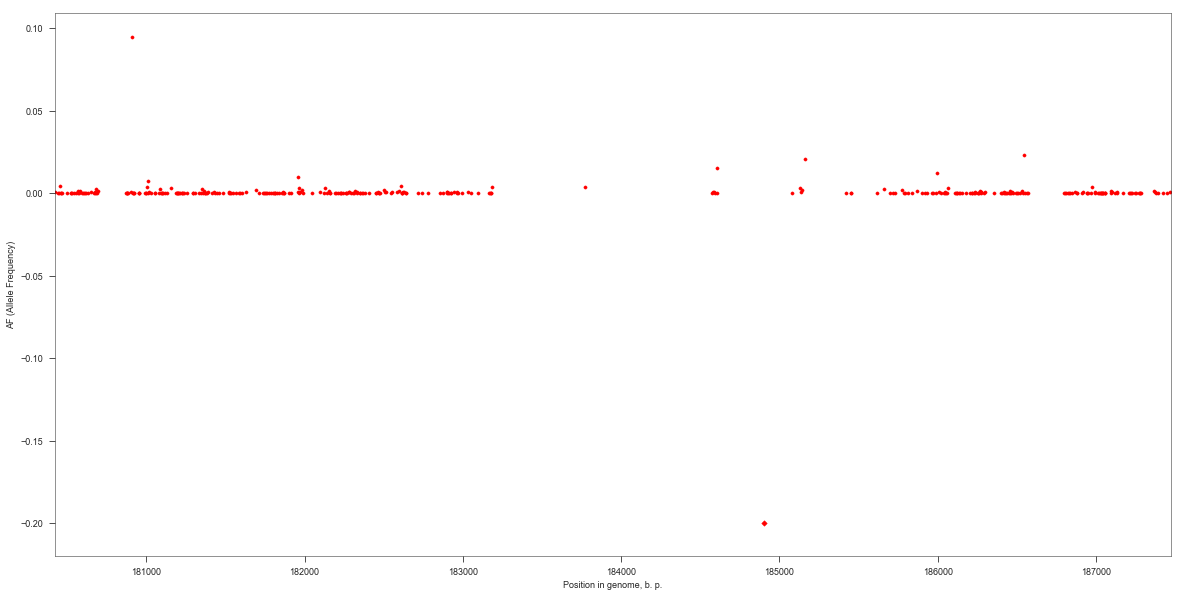

step # 128 PF3D7_0908500 start 389605.0 end 397843.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_0908500 Conservation score nan


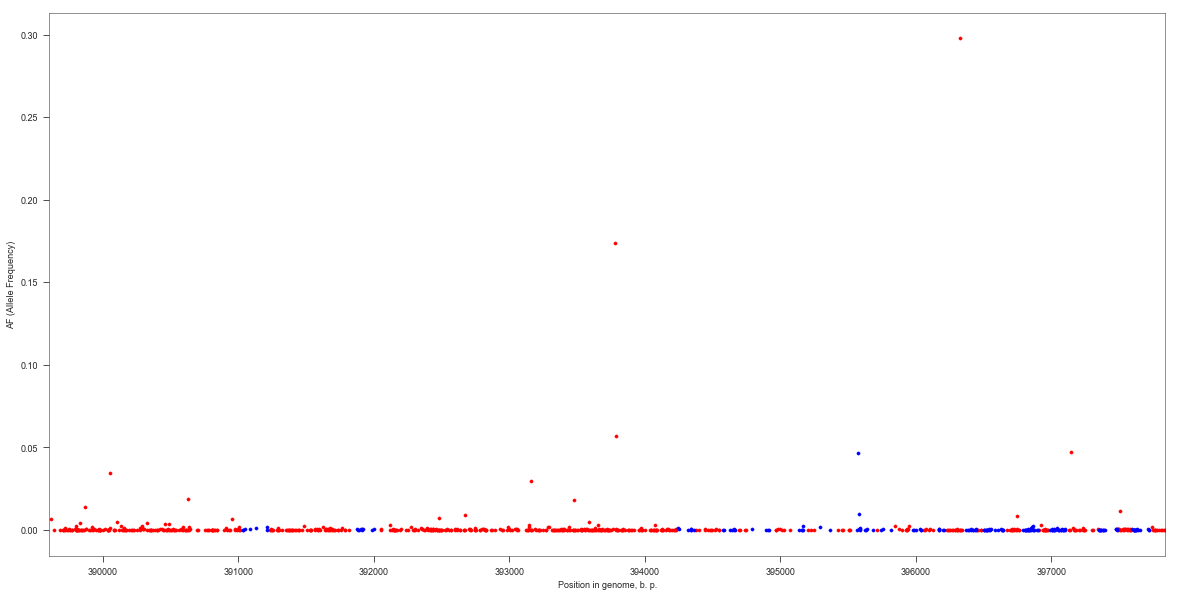

step # 129 PF3D7_0305500 start 261485.0 end 273286.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_0305500 Conservation score 0.560132215


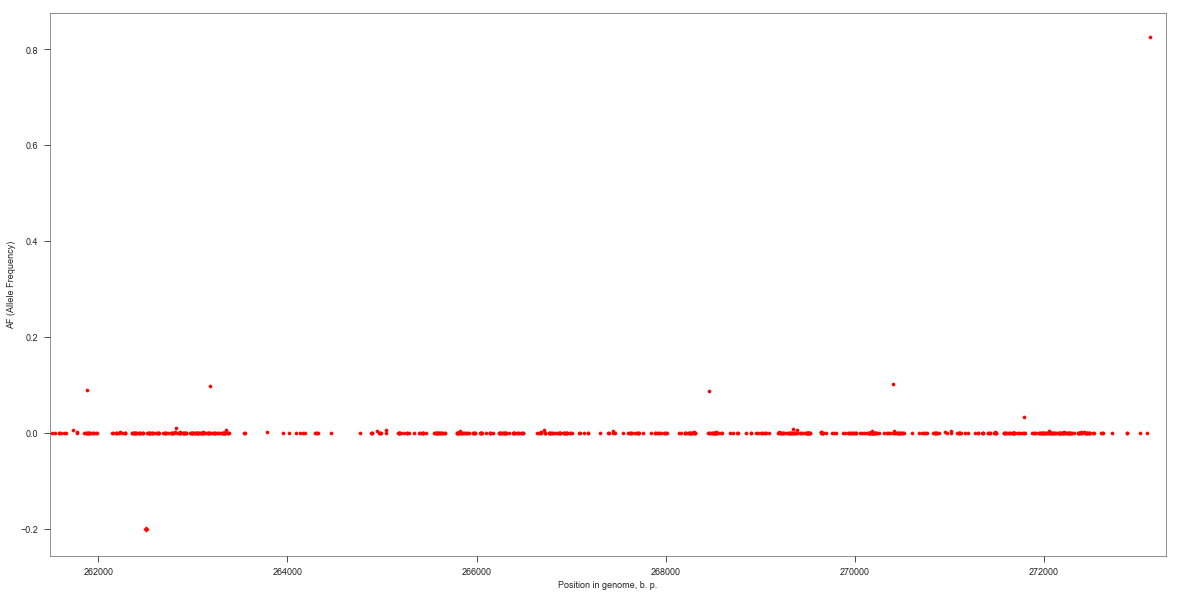

step # 130 PF3D7_0726400 start 1108831.0 end 1124492.0 conserved+Plasmodium+membrane+protein%2C+unknown+function Gene name PF3D7_0726400 Conservation score -0.047734628


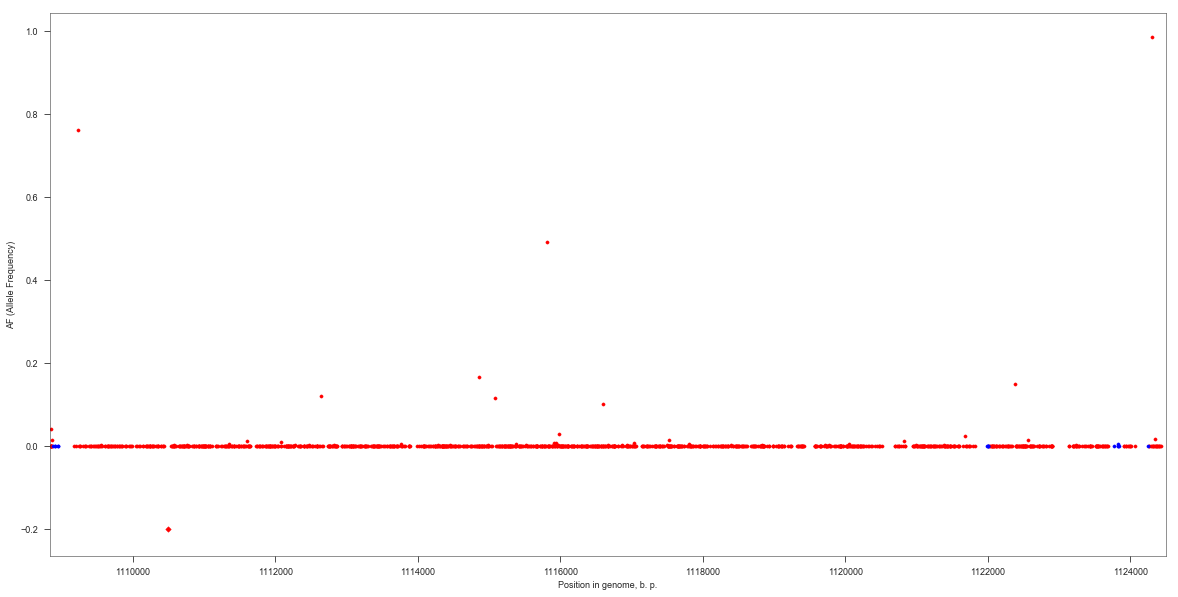

step # 131 PF3D7_0523000 start 957890.0 end 962149.0 multidrug+resistance+protein+%28MDR1%29 Gene name MDR1 Conservation score 3.286116984


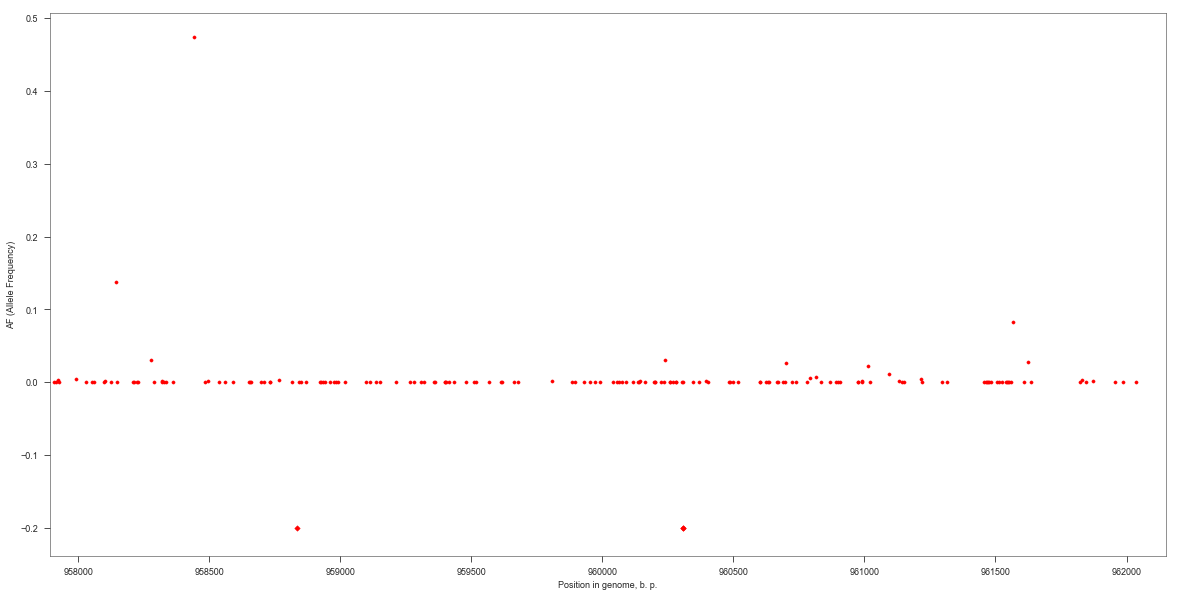

step # 132 PF3D7_0203000 start 141625.0 end 147564.0 conserved+Plasmodium+protein%2C+unknown+function Gene name ROPE Conservation score nan


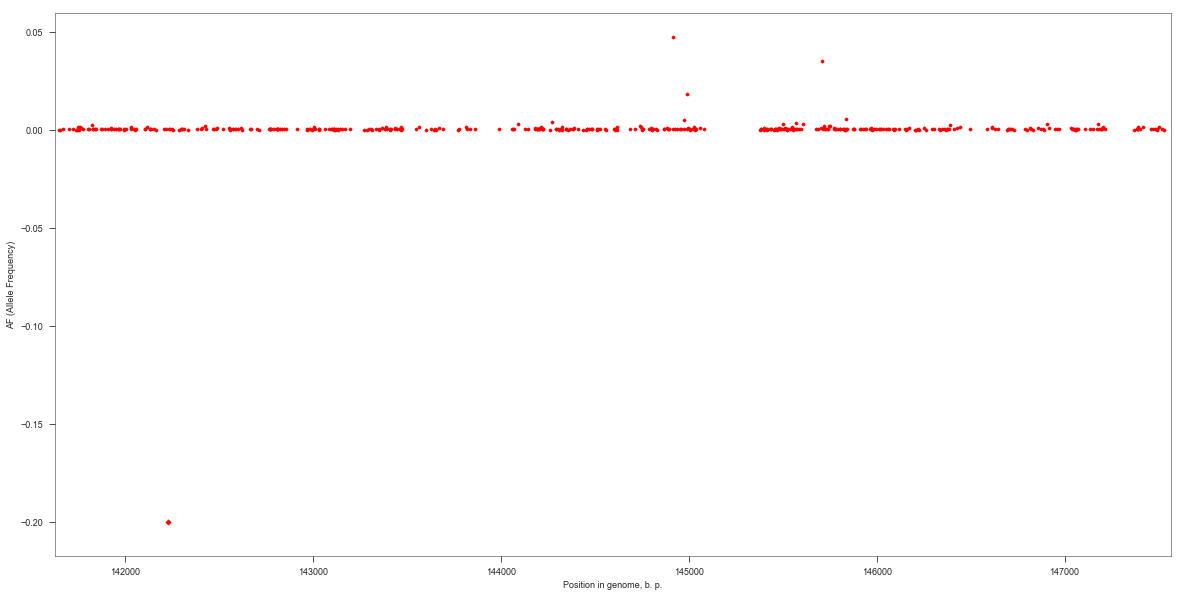

step # 133 PF3D7_1368300 start 2717853.0 end 2719377.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_1368300 Conservation score 2.795652174


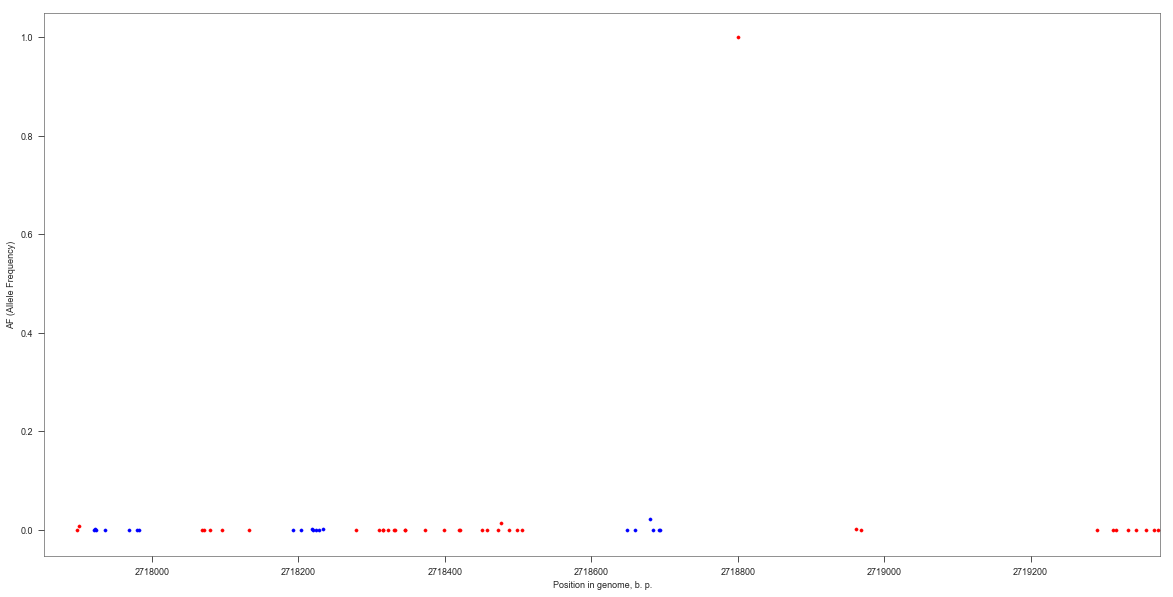

step # 134 PF3D7_1413400 start 534057.0 end 535988.0 "30S ribosomal protein S9, putative" Gene name PF3D7_1413400 Conservation score 1.794712286


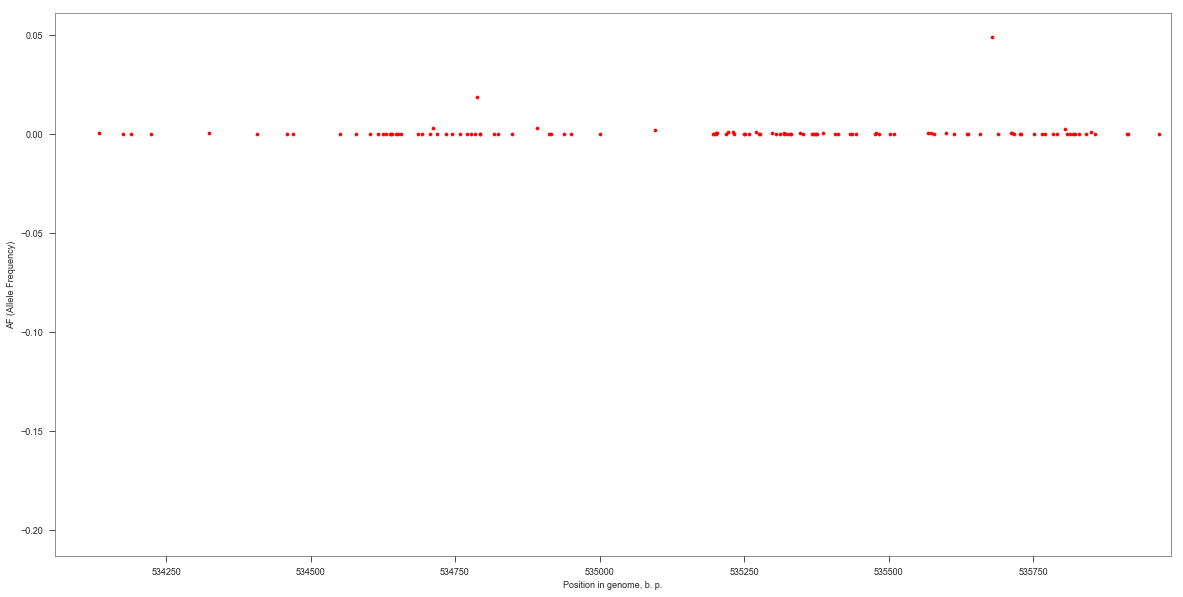

step # 135 PF3D7_0815100 start 711239.0 end 714166.0 RAP+protein%2C+putative Gene name PF3D7_0815100 Conservation score 0.941538462


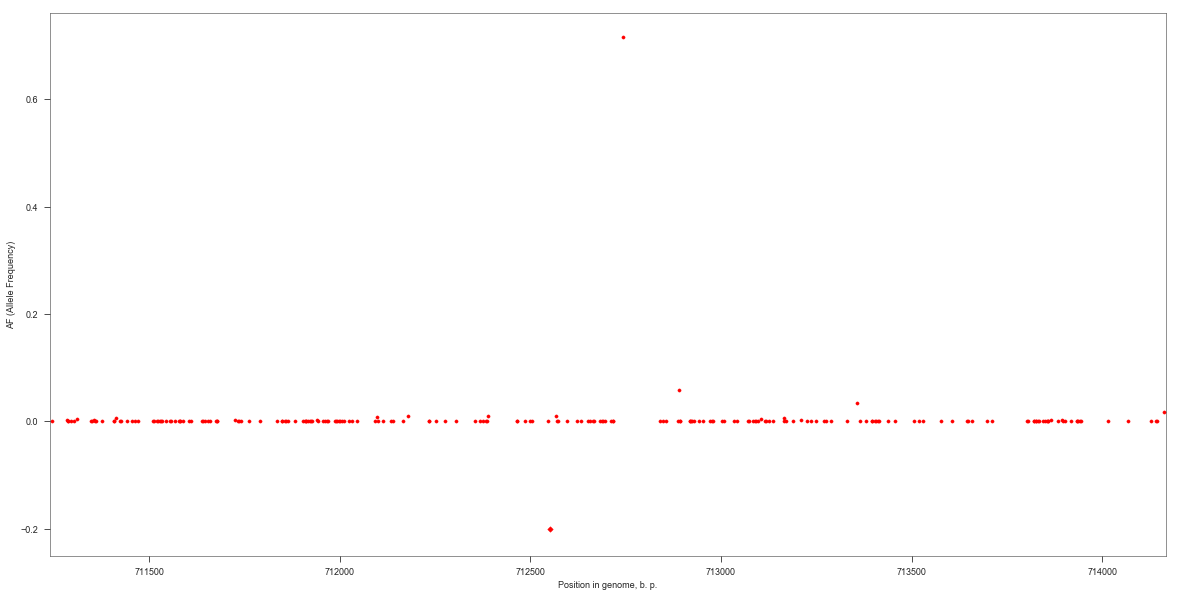

step # 136 PF3D7_0614200 start 593172.0 end 595904.0 cytosolic Fe-S cluster assembly factor NAR1, putative Gene name NAR1 Conservation score nan


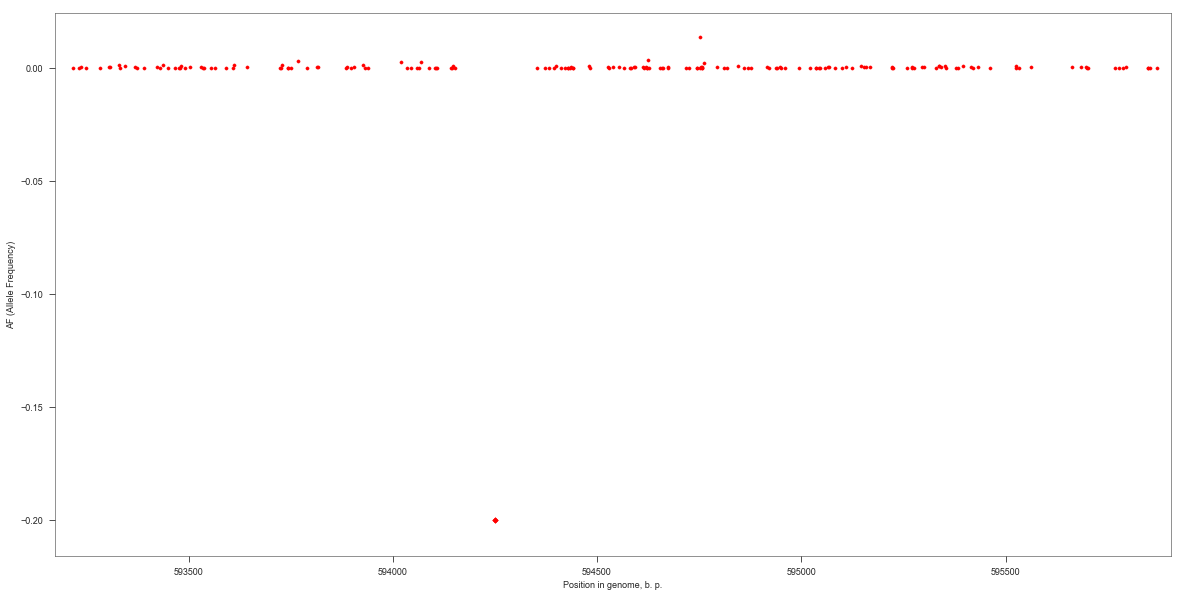

step # 137 PF3D7_0106300 start 265208.0 end 269173.0 calcium-transporting ATPase (ATP6) Gene name ATP6 Conservation score 3.04723127


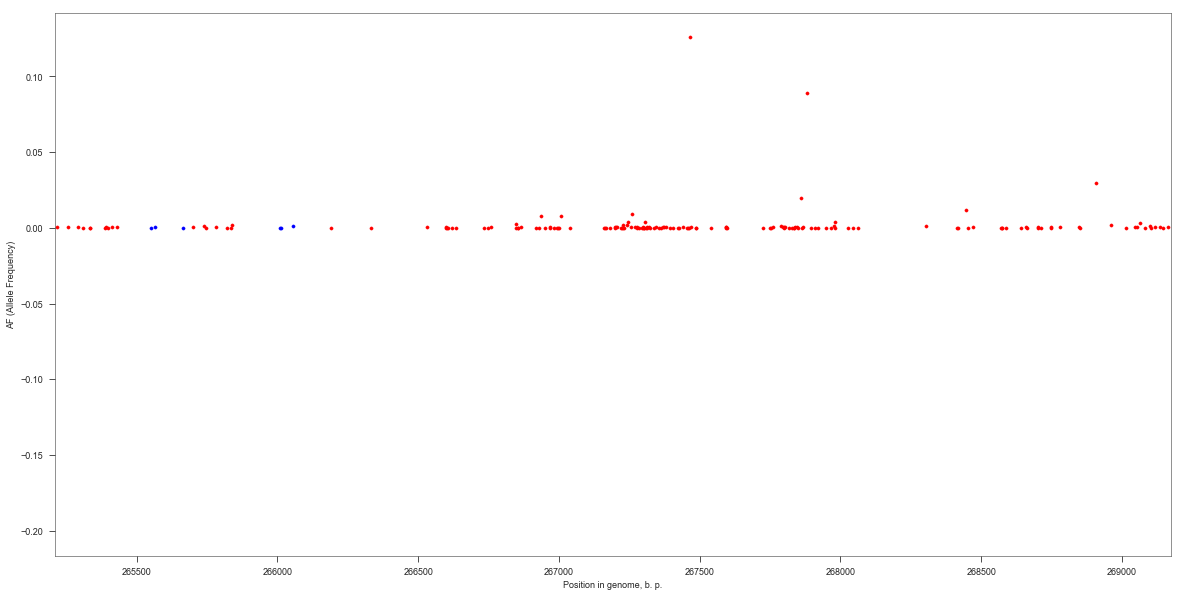

step # 138 PF3D7_0703000 start 115239.0 end 120770.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_0703000 Conservation score 0.352685838


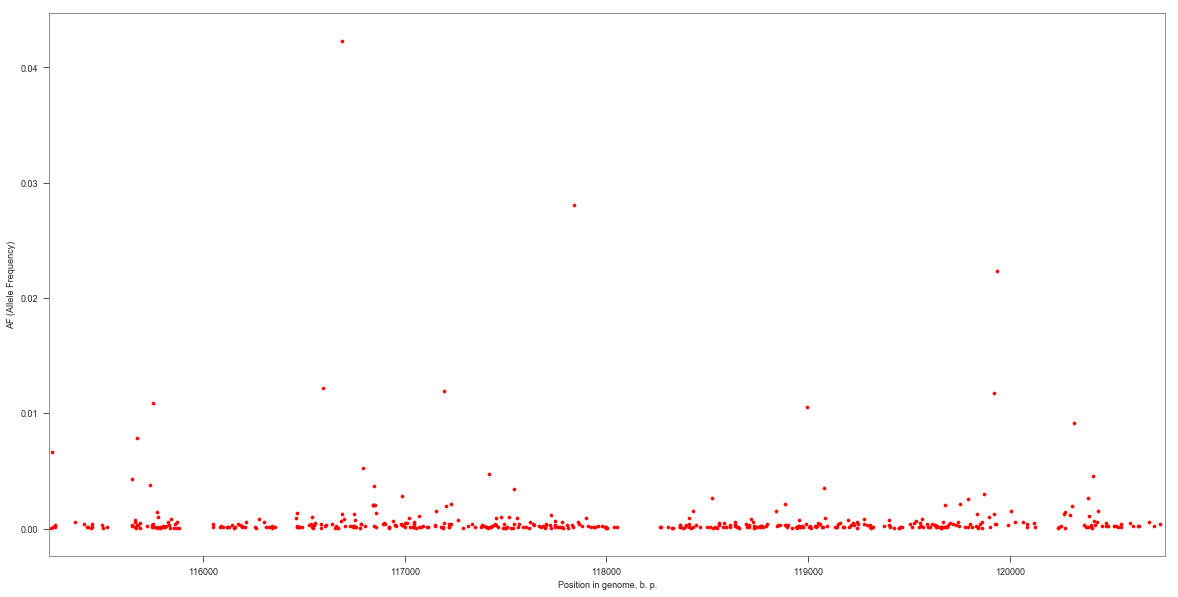

step # 139 PF3D7_1470100 start 2870069.0 end 2877589.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_1470100 Conservation score 1.330480848


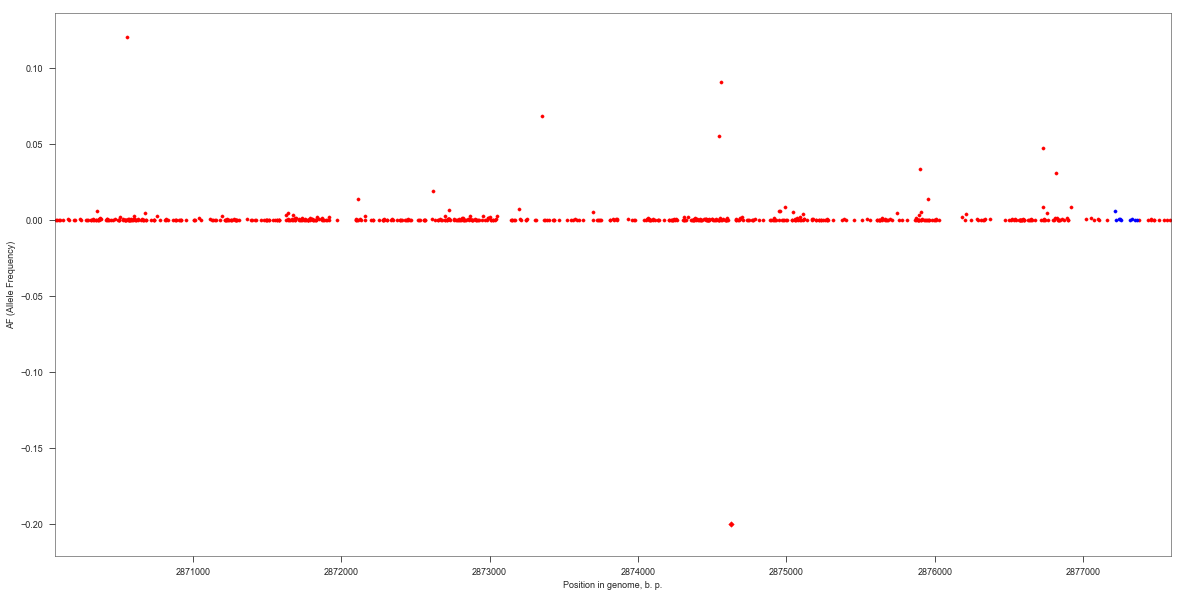

step # 140 PF3D7_1449900 start 2044007.0 end 2045029.0 "conserved Plasmodium protein, unknown function" Gene name PF3D7_1449900 Conservation score 2.105882353


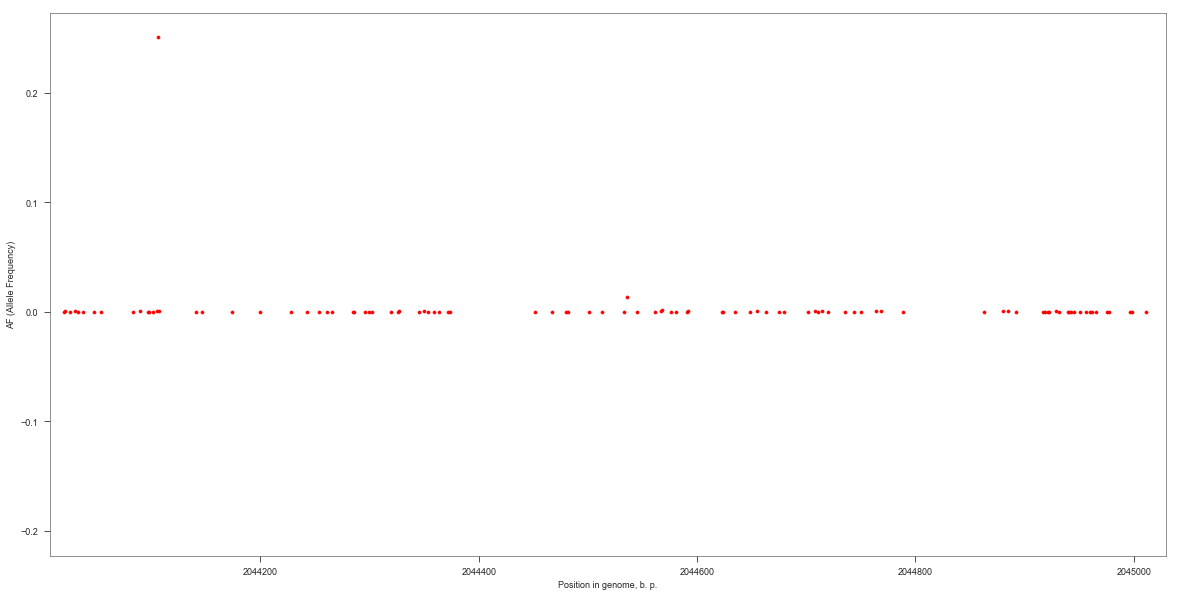

step # 141 PF3D7_1460500 start 2466091.0 end 2470989.0 conserved+Plasmodium+protein%2C+unknown+function Gene name PF3D7_1460500 Conservation score nan


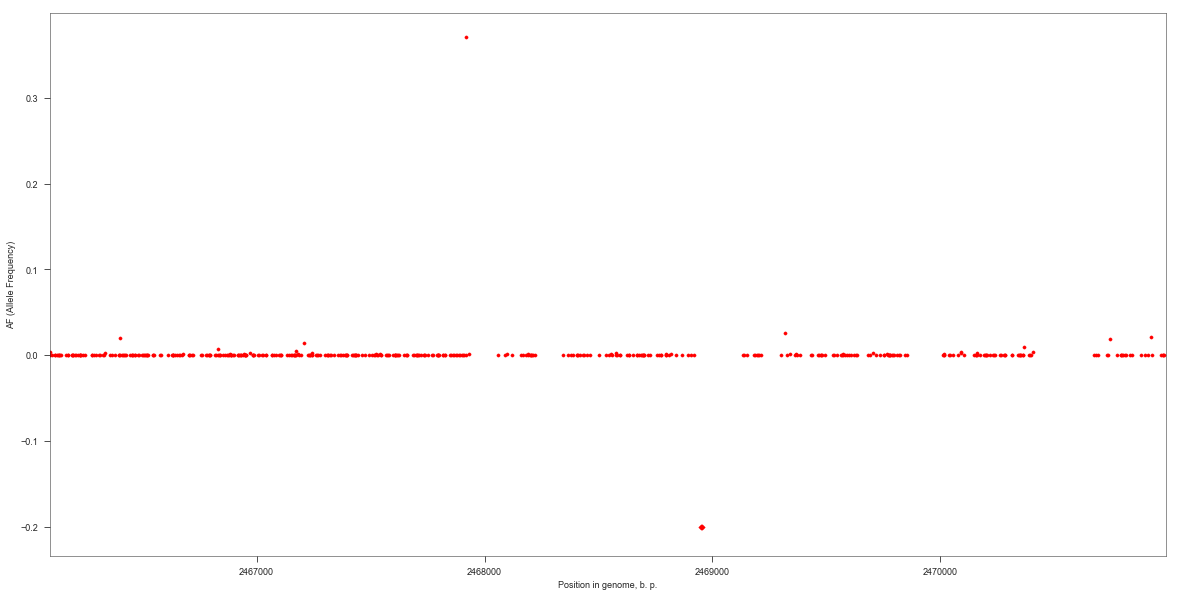

CPU times: user 4min 20s, sys: 3.65 s, total: 4min 23s
Wall time: 4min 25s


In [41]:
%%time
i = 0
for elem in gene_picks:                          # elem is a genen ID from gene_picks
    print('step #',i,                            # some useful information
          elem, 
          'start', df_Cowell_lds_filtered['start'][list(df_Cowell_lds_filtered['Gene_ID']).index(elem)], 
          'end', df_Cowell_lds_filtered['end'][list(df_Cowell_lds_filtered['Gene_ID']).index(elem)], 
          df_Cowell_lds_filtered['Gene_Descrip'][list(df_Cowell_lds_filtered['Gene_ID']).index(elem)], 'Gene name',
          df_variants_filtered_final['SNPEFF_GENE_NAME'][list(df_variants_filtered_final['SNPEFF_TRANSCRIPT_ID']).index(elem + '.1')],
          'Conservation score',
          df_Cowell_lds_filtered['Conservation score'][list(df_Cowell_lds_filtered['Gene_ID']).index(elem)])
    # non-synonymous coding,/// start loss and stop gain SNPs from Cowell
    x_Cowell_important = list(df_Cowell_lds_filtered[    (df_Cowell_lds_filtered.Gene_ID == elem) & 
                                          ( (df_Cowell_lds_filtered['Effect'] == 'non_synonymous_coding') |
                                           (df_Cowell_lds_filtered['Effect'] == 'NON_SYNONYMOUS_CODING') )].Position) 
                                           #|
                                          #(df_Cowell_lds_filtered['Effect'] == 'START_LOST') |
                                          #(df_Cowell_lds_filtered['Effect'] == 'stop_gained') ) 
                                          #].Position)
    y_Cowell_important = [-0.2]*len(x_Cowell_important)
    
    # intergenic, intergenic_region, intron_variant and splice_region_variant+intron_variant SNPs from Cowell
    x_Cowell_noncod = list(df_Cowell_lds_filtered[  (df_Cowell_lds_filtered.Gene_ID == elem) 
                                      & ((df_Cowell_lds_filtered.Effect == 'intergenic') |
                                          (df_Cowell_lds_filtered.Effect == 'intergenic_region') |
                                          (df_Cowell_lds_filtered.Effect == 'intron_variant') |
                                        (df_Cowell_lds_filtered.Effect == 'splice_region_variant+intron_variant'))
                                      ].Position)
    y_Cowell_noncod =  [-0.2]*len(x_Cowell_noncod)
    
    
    
    # non-synonymous coding, start loss, stop gain and stop loss SNPs from Pf6
    x_Pf6_important = list(df_variants_filtered_final[ (df_variants_filtered_final.SNPEFF_TRANSCRIPT_ID == elem + '.1')  
                                             & (df_variants_filtered_final.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')].POS)
                                                  #| (df_variants_filtered_final.SNPEFF_EFFECT == 'START_LOST')
                                                  #| (df_variants_filtered_final.SNPEFF_EFFECT == 'STOP_GAINED')
                                                  #| (df_variants_filtered_final.SNPEFF_EFFECT == 'STOP_LOST'))
                                           #].POS)
    
    
    y_Pf6_important = list(df_variants_filtered_final[(df_variants_filtered_final.SNPEFF_TRANSCRIPT_ID == elem +'.1')
                                               & (df_variants_filtered_final.SNPEFF_EFFECT == 'NON_SYNONYMOUS_CODING')].AF)
                                                  #| (df_variants_filtered_final.SNPEFF_EFFECT == 'START_LOST')
                                                  #| (df_variants_filtered_final.SNPEFF_EFFECT == 'STOP_GAINED')
                                                  #| (df_variants_filtered_final.SNPEFF_EFFECT == 'STOP_LOST'))].AF)
    
    
    # intergenic, intragenic and intron SNPs from Pf6
    x_Pf6_noncod = list(df_variants_filtered_final[ (df_variants_filtered_final.SNPEFF_TRANSCRIPT_ID == elem + '.1')  
                                             & ((df_variants_filtered_final.SNPEFF_EFFECT == 'INTRAGENIC')
                                                | (df_variants_filtered_final.SNPEFF_EFFECT == 'INTERGENIC')
                                                   | (df_variants_filtered_final.SNPEFF_EFFECT == 'INTRON'))
                                           ].POS)
    y_Pf6_noncod = list(df_variants_filtered_final[  (df_variants_filtered_final.SNPEFF_TRANSCRIPT_ID == elem + '.1')  
                                             & ((df_variants_filtered_final.SNPEFF_EFFECT == 'INTRAGENIC')
                                                | (df_variants_filtered_final.SNPEFF_EFFECT == 'INTERGENIC')
                                                   | (df_variants_filtered_final.SNPEFF_EFFECT == 'INTRON'))
                                           ].AF)
    
    
    fig = plt.figure(figsize=[20, 10])
    ax = fig.add_subplot(111)
    plt.xlabel("Position in genome, b. p.")
    plt.xlim( df_Cowell_lds_filtered['start'][list(df_Cowell_lds_filtered['Gene_ID']).index(elem)], 
              df_Cowell_lds_filtered['end'][list(df_Cowell_lds_filtered['Gene_ID']).index(elem)] )
    plt.ylabel("AF (Allele Frequency)")
    ax.scatter(x_Cowell_important,y_Cowell_important,color='red',s=15,marker='D')
    ax.scatter(x_Cowell_noncod,y_Cowell_noncod,c='blue',s=15,marker='D')
    ax.scatter(x_Pf6_important,y_Pf6_important,c='red',s=10)
    ax.scatter(x_Pf6_noncod,y_Pf6_noncod,c='blue',s=10)
#    plt.title(elem,
#             df_variants_filtered_final['SNPEFF_GENE_NAME'][list(df_variants_filtered_final['SNPEFF_TRANSCRIPT_ID']).index(elem + '.1')],   
#             df_Cowell_lds_filtered['Gene_Descrip'][list(df_Cowell_lds_filtered['Gene_ID']).index(elem)])
    
    i += 1
    plt.show()

In [18]:
pf_6_metadata_fn = '/Users/aa22/Documents/malaria_1/Pf_60_complete_metadata_20180201.txt'

In [1]:
#df_samples_all = pd.read_csv(pf_6_metadata_fn, sep='\t', index_col = 0)   # why exactly index_col=0?
#print(df_samples_all.shape)
#df_samples_all.head()